In [51]:
import os
import datetime as dt
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def train_TCN(model, dataloader, learning_rate=0.01, num_epochs=30, criterion = nn.MSELoss()):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    n_total_steps = len(dataloader)
    for epoch in range(num_epochs):
        for i, (forecast, billing) in enumerate(dataloader):
            # forward pass
            outputs = model(forecast)
            loss = criterion(outputs, billing)
            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1)%10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: [{loss}]")

    print("Finished training")
    return model

In [11]:
def create_plot(product, train, test, testpred, pred, save=True):
    fig = plt.figure(figsize=(13,8))
    t = np.arange(dt.datetime(2017,10,7), dt.datetime(2018,1,1), dt.timedelta(days=7)).astype(dt.datetime)
    t0 = np.arange(dt.datetime(2014,1,1), dt.datetime(2017,9,21), dt.timedelta(days=7)).astype(dt.datetime)
    tp = np.arange(dt.datetime(2018,1,1), dt.datetime(2018,4,1), dt.timedelta(days=7)).astype(dt.datetime)
    y0 = train.y
    y1 = test.y[0:13].detach().numpy()
    y2 = testpred.T.detach().numpy()
    y3 = pred.T.detach().numpy()
    print(y3.shape)
    plt.plot(t0, y0, label='train data')
    plt.plot(t, y1, label='test data')
    plt.plot(t, y2, label='test prediction')
    plt.plot(tp, y3, label='prediction')
    plt.title(idx2prod[product])
    plt.legend()
    save_plot(plt, idx2prod[product])
    return plt


In [12]:
def save_plot(plot, name:str):
    DIRPIC = os.path.join(os.getcwd()+"\..\pics")
    PATHPIC = os.path.join(DIRPIC, f'{name}.png')
    plot.savefig(PATHPIC)
    return(f'{name}.png was saved')

In [13]:
idx2prod = {
    0:'Product_19',
    1:'Product_20',
    2:'Product_22',
    3:'Product_30',
    4:'Product_39',
    5:'Product_48',
    6:'Product_50',
    7:'Product_55',
    8:'Product_57',
    9:'Product_67'
}

In [14]:
import os
import datetime as dt
import pandas as pd
import numpy as np
import math
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

'''
global variables for reading the dataset
'''
DIR = os.path.join(os.getcwd()+"\..\data")
if not os.path.exists(DIR):
    print("PROVIDE PATH TO FILE MANUALLY")

FILE_NAME = "q4_2017.xlsx" #rewrite: read file name from settings.py
PATH = os.path.join(DIR, FILE_NAME)

TRAIN_TEST_DATE='2017-09-30'

class BillingDataset(Dataset):
    '''
    create dataset from excel table based on the product number
    PS: products' names are converted into numbers from 0 to 9
    '''    
    def __init__(self, product=None, ttp='train', window=13):
        if product is None:
            self.PROD = 0 # Rewrite to cover all products
        else:
            self.PROD = product
            
        self.ttp = ttp
        self.window=window
        df = pd.read_excel(PATH, index_col=None, header=1)
        df_ = self._df_perparation(df)
        
        x_, y_ = self._df_transformation(df_)
        self.x = torch.from_numpy(x_.values.astype(np.double)).double()
        self.y = torch.from_numpy(y_.values.astype(np.double)).double()
        self.n_samples = x_.values.shape[0]
        self.n_features = x_.values.shape[1]
        
        
    def __getitem__(self, index):
        if len(self.x[index:index+window]) == window:
            x = torch.clone(self.x[index:index+window])
            y = torch.clone(self.y[index:index+self.window])
        else:
            x = torch.clone(self.x[index:])
            y = torch.clone(self.y[index:])
    
        for i in range(x.shape[0]-1):
            if i == 0:
                x[i+1,i] = 0
            else:
                x[i+1,:i+1] = 0
        return x, y
        
    def __len__(self):
        return self.n_samples-self.window
        
    def _df_perparation(self, df_):
        '''
        rename columns, create a column with date in iso format, create unique indexes from products' names
        '''
        df = df_.copy()
        df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
        df['Billing'].loc[df['Billing'].isna()] = 0
        df['Fc_and_order'].loc[df['Fc_and_order'].isna()] = 0
        products = df['Sp_number'].unique()
        prod2idx = {}
        idx2prod = {}
        for idx, prod in enumerate(products):
            if prod not in prod2idx:
                prod2idx[prod] = idx
                idx2prod[idx] = prod

        #Add column with integer product names

        products_int = []
        for idx, row in df['Sp_number'].iteritems():
            products_int.append(prod2idx[row])

        df['products'] = products_int
        
        mapper = {
            'products': 'product',
            'Fc_horizon': 'horizon',
            'Fc_and_order': 'forecast',
            'Billing': 'billing',
            "Due_date": "ddate",
            "Fc_date": "fdate"
        }
        df.rename(columns=mapper, inplace=True)
        df['isodate'] = df[['ddate']].apply(lambda x: dt.datetime.strptime(str(x['ddate'])+'-1',"%Y%W-%w"), axis=1)
        return df
    
    def _df_prediction(self, df_):
        df = df_.copy()
        idxs = df.loc[df['billing'] != 0].index
        df.drop(idxs, inplace=True)
        df1 = df.loc[df['product'] == self.PROD].copy()
        hors = df1.horizon.unique()
        dates = df1.isodate.unique()
        data = {}
        for date in dates:
            for h in hors:
                val = df1.forecast.loc[(df1.horizon == h) & (df1.isodate == date)].values.tolist()
                if not val:
                    val = [0]
                if h not in data:
                    data[h] = []
                data[h].append(val[0])
        df_ = pd.DataFrame(data, columns=data.keys(), index=dates)
        df_.index = pd.DatetimeIndex(df_.index).to_period('W')
        return df_, pd.DataFrame()
    
    
    
    def _df_transformation(self, df_):
        df = df_.copy()
        if self.ttp == 'train' or self.ttp == 'test':
            idxs = df.loc[df['billing'] == 0].index
            train_test_date = TRAIN_TEST_DATE
        elif self.ttp == 'predict':
            return self._df_prediction(df)
#             idxs = df.loc[df['billing'] != 0].index
        
        df.drop(idxs, inplace=True)
        
        
        # CHANGE TO COVER ALL PRODUCTS
        # collect billings
        df_b = df[['isodate', 'billing']].loc[df['product'] == self.PROD].copy().drop_duplicates(['isodate'])
        df_b.set_index(['isodate'], inplace=True)
        df_b.index = pd.DatetimeIndex(df_b.index).to_period('W')
        
        # collect forecast
        df1 = df.loc[df['product'] == self.PROD].copy()
        
        hors = df1.horizon.unique()
        dates = df1.isodate.unique()
        data = {}

        for date in dates:
            for h in hors:
                val = df1.forecast.loc[(df1.horizon == h) & (df1.isodate == date)].values.tolist()
                if not val:
                    val = [0]
                if h not in data:
                    data[h] = []
                data[h].append(val[0])
                
        df_ = pd.DataFrame(data, columns=data.keys(), index=dates)
        
        hors = df1.horizon.unique()
        dates = df1.isodate.unique()
        data = {}

        means = df_.T.mean()

        for date in dates:
            mean = means[date]
            for h in hors:
                val = df1.forecast.loc[(df1.horizon == h) & (df1.isodate == date)].values.tolist()
                if not val:
                    val = [mean]
                if h not in data:
                    data[h] = []
                data[h].append(val[0])
                
        df_ = pd.DataFrame(data, columns=data.keys(), index=dates)
        df_.index = pd.DatetimeIndex(df_.index).to_period('W')
        
        if self.ttp == 'train':
            return df_[train_test_date:], df_b[train_test_date:]
        elif self.ttp == 'test':
            return df_[:train_test_date], df_b[:train_test_date]
        else:
            return df_, df_b
        
        
        
class BillingNormDataset(Dataset):
    '''
    create dataset from excel table based on the product number
    PS: products' names are converted into numbers from 0 to 9
    '''    
    def __init__(self, product=None, ttp='train', window=13):
        if product is None:
            self.PROD = 0 # Rewrite to cover all products
        else:
            self.PROD = product
        self.scaler = MinMaxScaler()
        self.ttp = ttp
        self.window=window
        '''
        get dataset (excel-table) from folder
        '''
        df = pd.read_excel(PATH, index_col=None, header=1)
        df_ = self._df_perparation(df)
        
        #CHANGE TO COVER ALL PRODUCTS
#         self.x_, self.y_ = self._df_transformation(df_)
#         self.x = torch.from_numpy(self.x_.values.astype(np.double)).double()
#         self.y = torch.from_numpy(self.y_.values.astype(np.double)).double()
#         self.n_samples = self.x_.values.shape[0]
#         self.n_features = self.x_.values.shape[1]
        
        x_, y_ = self._df_transformation(df_)
        self.x = torch.from_numpy(x_.values.astype(np.double)).double()
        self.y = torch.from_numpy(y_.values.astype(np.double)).double()
        self.n_samples = x_.values.shape[0]
        self.n_features = x_.values.shape[1]
        
        
    def __getitem__(self, index):
        if len(self.x[index:index+window]) == window:
            x = torch.clone(self.x[index:index+window])
            y = torch.clone(self.y[index:index+self.window])
        else:
            x = torch.clone(self.x[index:])
            y = torch.clone(self.y[index:])
    
        for i in range(x.shape[0]-1):
            if i == 0:
                x[i+1,i] = 0
            else:
                x[i+1,:i+1] = 0
        return x, y
    
    def __len__(self):
        return self.n_samples-self.window
        
    def _df_perparation(self, df_):
        '''
        rename columns, create a column with date in iso format, create unique indexes from products' names
        '''
        df = df_.copy()
        df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
        df['Billing'].loc[df['Billing'].isna()] = 0
        df['Fc_and_order'].loc[df['Fc_and_order'].isna()] = 0
        products = df['Sp_number'].unique()
        prod2idx = {}
        idx2prod = {}
        for idx, prod in enumerate(products):
            if prod not in prod2idx:
                prod2idx[prod] = idx
                idx2prod[idx] = prod

        #Add column with integer product names

        products_int = []
        for idx, row in df['Sp_number'].iteritems():
            products_int.append(prod2idx[row])

        df['products'] = products_int
        
        mapper = {
            'products': 'product',
            'Fc_horizon': 'horizon',
            'Fc_and_order': 'forecast',
            'Billing': 'billing',
            "Due_date": "ddate",
            "Fc_date": "fdate"
        }
        df.rename(columns=mapper, inplace=True)
        df['isodate'] = df[['ddate']].apply(lambda x: dt.datetime.strptime(str(x['ddate'])+'-1',"%Y%W-%w"), axis=1)
        return df
    
    def _df_prediction(self, df_):
        df = df_.copy()
        idxs = df.loc[df['billing'] != 0].index
        df.drop(idxs, inplace=True)
        df1 = df.loc[df['product'] == self.PROD].copy()
        hors = df1.horizon.unique()
        dates = df1.isodate.unique()
        data = {}
        for date in dates:
            for h in hors:
                val = df1.forecast.loc[(df1.horizon == h) & (df1.isodate == date)].values.tolist()
                if not val:
                    val = [0]
                if h not in data:
                    data[h] = []
                data[h].append(val[0])
        df_ = pd.DataFrame(data, columns=data.keys(), index=dates)
        df_.index = pd.DatetimeIndex(df_.index).to_period('W')
        df_[df_.columns] = self.scaler.fit_transform(df_[df_.columns])
        return df_, pd.DataFrame()
    
    def _df_transformation(self, df_):
        df = df_.copy()
        if self.ttp == 'train' or self.ttp == 'test':
            idxs = df.loc[df['billing'] == 0].index
            train_test_date = TRAIN_TEST_DATE
        elif self.ttp == 'predict':
#             idxs = df.loc[df['billing'] != 0].index
            return self._df_prediction(df)
        
        df.drop(idxs, inplace=True)
        
        
        # CHANGE TO COVER ALL PRODUCTS
        # collect billings
        df_b = df[['isodate', 'billing']].loc[df['product'] == self.PROD].drop_duplicates(['isodate'])
        df_b.set_index(['isodate'], inplace=True)
        df_b.index = pd.DatetimeIndex(df_b.index).to_period('W')
        
        # collect forecast
        df1 = df.loc[df['product'] == self.PROD].copy()
        
        hors = df1.horizon.unique()
        dates = df1.isodate.unique()
        data = {}

        for date in dates:
            for h in hors:
                val = df1.forecast.loc[(df1.horizon == h) & (df1.isodate == date)].values.tolist()
                if not val:
                    val = [0]
                if h not in data:
                    data[h] = []
                data[h].append(val[0])
                
        df_ = pd.DataFrame(data, columns=data.keys(), index=dates)
        
        hors = df1.horizon.unique()
        dates = df1.isodate.unique()
        data = {}

        means = df_.T.mean()

        for date in dates:
            mean = means[date]
            for h in hors:
                val = df1.forecast.loc[(df1.horizon == h) & (df1.isodate == date)].values.tolist()
                if not val:
                    val = [mean]
                if h not in data:
                    data[h] = []
                data[h].append(val[0])
                
        df_ = pd.DataFrame(data, columns=data.keys(), index=dates)
        df_.index = pd.DatetimeIndex(df_.index).to_period('W')
        df_[df_.columns] = self.scaler.fit_transform(df_[df_.columns])
        
        if self.ttp == 'train':
            return df_[train_test_date:], df_b[train_test_date:]
        elif self.ttp == 'test':
            return df_[:train_test_date], df_b[:train_test_date]
        else:
            return df_, df_b

In [27]:
DIR = os.path.join(os.getcwd()+"\..\data")
if not os.path.exists(DIR):
    print("PROVIDE PATH TO FILE MANUALLY")

FILE_NAME = "q4_2017.xlsx" #rewrite: read file name from settings.py
PATH = os.path.join(DIR, FILE_NAME)
TRAIN_TEST_DATE='2017-09-30'

class BillingMedianDataset(Dataset):
    '''
    create dataset from excel table based on the product number
    PS: products' names are converted into numbers from 0 to 9
    '''    
    def __init__(self, product=None, ttp='train', window=13, scale=False):
        if product is None:
            self.PROD = 0 # Rewrite to cover all products
        else:
            self.PROD = product
            
        self.ttp = ttp
        self.window=window
        self.scale = scale
        '''
        get dataset (excel-table) from folder
        '''
        df = pd.read_excel(PATH, index_col=None, header=1)
        df_ = self._df_perparation(df)
        
        #CHANGE TO COVER ALL PRODUCTS
#         self.x_, self.y_ = self._df_transformation(df_)
#         self.x = torch.from_numpy(self.x_.values.astype(np.double)).double()
#         self.y = torch.from_numpy(self.y_.values.astype(np.double)).double()
#         self.n_samples = self.x_.values.shape[0]
#         self.n_features = self.x_.values.shape[1]
        
        x_, y_ = self._df_transformation(df_)
        self.x = torch.from_numpy(x_.values.astype(np.double)).double()
        self.y = torch.from_numpy(y_.values.astype(np.double)).double()
        self.n_samples = x_.values.shape[0]
        self.n_features = x_.values.shape[1]
        
        
    def __getitem__(self, index):
        if len(self.x[index:index+self.window]) == self.window:
            return self.x[index:index+self.window], self.y[index:index+self.window]
        
    def __len__(self):
        return self.n_samples-self.window
        
    def _df_perparation(self, df_):
        '''
        rename columns, create a column with date in iso format, create unique indexes from products' names
        '''
        df = df_.copy()
        df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
        df['Billing'].loc[df['Billing'].isna()] = 0
        df['Fc_and_order'].loc[df['Fc_and_order'].isna()] = 0
        products = df['Sp_number'].unique()
        prod2idx = {}
        idx2prod = {}
        for idx, prod in enumerate(products):
            if prod not in prod2idx:
                prod2idx[prod] = idx
                idx2prod[idx] = prod

        #Add column with integer product names

        products_int = []
        for idx, row in df['Sp_number'].iteritems():
            products_int.append(prod2idx[row])

        df['products'] = products_int
        
        mapper = {
            'products': 'product',
            'Fc_horizon': 'horizon',
            'Fc_and_order': 'forecast',
            'Billing': 'billing',
            "Due_date": "ddate",
            "Fc_date": "fdate"
        }
        df.rename(columns=mapper, inplace=True)
        df['isodate'] = df[['ddate']].apply(lambda x: dt.datetime.strptime(str(x['ddate'])+'-1',"%Y%W-%w"), axis=1)
        return df
    
    def _df_transformation(self, df_):
        df = df_.copy()
        if self.ttp == 'train' or self.ttp == 'test':
            idxs = df.loc[df['billing'] == 0].index
            train_test_date = TRAIN_TEST_DATE
        elif self.ttp == 'predict':
            idxs = df.loc[df['billing'] != 0].index
        
        df.drop(idxs, inplace=True)
        
        
        # CHANGE TO COVER ALL PRODUCTS
        # collect billings
        df_b = df[['isodate', 'billing']].loc[df['product'] == self.PROD].drop_duplicates(['isodate'])
        df_b.set_index(['isodate'], inplace=True)
        df_b.index = pd.DatetimeIndex(df_b.index).to_period('W')
        
        # collect forecast
        df1 = df.loc[df['product'] == self.PROD].copy()
        
        hors = df1.horizon.unique()
        dates = df1.isodate.unique()
        data = {}

        for date in dates:
            for h in hors:
                val = df1.forecast.loc[(df1.horizon == h) & (df1.isodate == date)].values.tolist()
                if not val:
                    val = [0]
                if h not in data:
                    data[h] = []
                data[h].append(val[0])
                
        df_ = pd.DataFrame(data, columns=data.keys(), index=dates)
        
        hors = df1.horizon.unique()
        dates = df1.isodate.unique()
        data = {}

        means = df_.T.mean()

        for date in dates:
            mean = means[date]
            for h in hors:
                val = df1.forecast.loc[(df1.horizon == h) & (df1.isodate == date)].values.tolist()
                if not val:
                    val = [mean]
                if h not in data:
                    data[h] = []
                data[h].append(val[0])
                
        df_ = pd.DataFrame(data, columns=data.keys(), index=dates)
        df_.index = pd.DatetimeIndex(df_.index).to_period('W')
        
        if self.scale:
            scaler = MinMaxScaler()
            df_[df_.columns] = self.scaler.fit_transform(df_[df_.columns])
        
        if self.ttp == 'train':
            return df_[train_test_date:], df_b[train_test_date:]
        elif self.ttp == 'test':
            return df_[:train_test_date], df_b[:train_test_date]
        else:
            return df_, df_b

In [28]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
#         self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
#                                            stride=stride, padding=padding, dilation=dilation))
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        self.dropout1 = nn.Dropout(dropout)

#         self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
#                                            stride=stride, padding=padding, dilation=dilation))
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
    
    
class TCN_(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN_, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1[:, :, -1])

In [49]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

input_length=13
output_size=13

model = TCN_(input_length, output_size, [1,2], 2, 0.1)
model.double()

class Trainer:
#     def __init__(self, model, name, norm=False, retrain=False):
    def __init__(self, name, norm=False, retrain=False):
        input_length=13
        output_size=13
        self.m = TCN_(input_length, output_size, [1,2], 2, 0.1)
        self.norm = norm
        self.retrain = retrain
        self.stats = {}
        self.counter = name
        
    def __call__(self,
                 train_loaders, test_loaders,
                 trains, tests, predictions,
                 lr, numepochs):
        mses = {}
        maes = {}
        predictionsdict = {}
        for i,loader in enumerate(train_loaders):
            if self.retrain:
                self.m = TCN_(input_length, output_size, [1,2], 2, 0.1)
            self.m.double()
            self.m = train_TCN(model=self.m, 
                      dataloader=loader, 
                      learning_rate=lr, 
                      num_epochs=numepochs, 
                      criterion = nn.MSELoss())
            
            with torch.no_grad():
                train = trains[i]
                test = tests[i]
                pred = predictions[i]
                testpred = self.m(test.x[0:13].view(1,13,13))
                prediction = self.m(pred.x.view(1,13,13))
                predictionsdict[idx2prod[i]] = prediction.tolist()
                mse_ = mse(test.y[0:13].detach().numpy(), testpred.T.detach().numpy())
                mses[idx2prod[i]] = mse_
                mae_ = mae(test.y[0:13].detach().numpy(), testpred.T.detach().numpy())
                maes[idx2prod[i]] = mae_
            try:
                create_plot(i, train, test, testpred, prediction)
            except:
                continue
        self._create_stats(predictionsdict, mses, maes, lr, numepochs)
#         self.counter+=1
    
    def _create_stats(self, predictions, mses, maes, lr, numepochs):
        self.stats["normalization"] = self.norm
        self.stats['retrain'] = self.retrain
        self.stats["learning rate"] = lr
        self.stats['epochs'] = numepochs
        self.stats['prediction'] = predictions
        self.stats['MSE'] = mses
        self.stats['MAE'] = maes
        self._save_stats(f'stats_{self.counter}')
        
    def _save_stats(self, name):
        DIRSTATS = os.path.join(os.getcwd()+"\..\stats")
        PATHSTATS = os.path.join(DIRSTATS, f'{name}.json')
        file = open(PATHSTATS, "w")
        json.dump(self.stats,file)
        file.close()
        return(f'{name} was saved')

# GOGOGO

In [237]:
testpr = BillingDataset(product=1, ttp='predict')
testtr = BillingDataset(product=1, ttp='train')
testte = BillingDataset(product=1, ttp='test')


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [242]:
testpr.x.shape

torch.Size([13, 13])

In [244]:
products = list(range(0,10))
print(products)

trains = []
tests = []
predictions = []

for prod in products:
    train_set = BillingDataset(product=prod, ttp='train')
    test_set = BillingDataset(product=prod, ttp='test')
    predict_set = BillingDataset(product=prod, ttp='predict')
    trains.append(train_set)
    tests.append(test_set)
    predictions.append(predict_set)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [253]:
predictions[0].x

tensor([[176316.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.],
        [345894., 337246.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.],
        [256438., 264364., 266735.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.],
        [     0., 292372., 278796., 274827.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.],
        [120652.,      0., 142284., 132288., 130324.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.],
        [263464., 255054.,      0., 248557., 247297., 201536.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.],
        [273874., 264644., 277997.,      0., 279786., 321637., 308403.,      0.,
              0.,      0.,      0.,      0.,      0.],
        [258491., 258875., 237095., 244418.,    

In [245]:
batch_size = 1

trains_loaders = [DataLoader(dataset=x, batch_size=batch_size, shuffle=False) for x in trains]
tests_loaders = [DataLoader(dataset=x, batch_size=batch_size, shuffle=False) for x in tests]

TCN_(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(13, 1, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (conv2): Conv1d(1, 1, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d()
        (relu2): LeakyReLU(negative_slope=0.01, inplace=True)
        (dropout2): Dropout(p=0.1, inplace=False)
        (net): Sequential(
          (0): Conv1d(13, 1, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Chomp1d()
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3): Dropout(p=0.1, inplace=False)
          (4): Conv1d(1, 1, kernel_size=(2,), stride=(1,), padding=(1,))
          (5): Chomp1d()
          (6): LeakyReLU(negative_slope=0.01, inplace=True)
          (7): Dropout(p=0.1, inplace=False)
        )
        (downsample): Conv1d(13, 1, kern

In [247]:
model.parameters

<bound method Module.parameters of TCN_(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(13, 1, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (conv2): Conv1d(1, 1, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d()
        (relu2): LeakyReLU(negative_slope=0.01, inplace=True)
        (dropout2): Dropout(p=0.1, inplace=False)
        (net): Sequential(
          (0): Conv1d(13, 1, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Chomp1d()
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3): Dropout(p=0.1, inplace=False)
          (4): Conv1d(1, 1, kernel_size=(2,), stride=(1,), padding=(1,))
          (5): Chomp1d()
          (6): LeakyReLU(negative_slope=0.01, inplace=True)
          (7): Dropout(p=0.1, inplace=False)
        )
     

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [80669595388.74138]
Epoch [1/15], Step [20/182], Loss: [70385946663.65596]
Epoch [1/15], Step [30/182], Loss: [76495660436.30455]
Epoch [1/15], Step [40/182], Loss: [55358483746.756355]
Epoch [1/15], Step [50/182], Loss: [51471292031.405685]
Epoch [1/15], Step [60/182], Loss: [50692944370.299126]
Epoch [1/15], Step [70/182], Loss: [56367206895.58757]
Epoch [1/15], Step [80/182], Loss: [60505377941.93713]
Epoch [1/15], Step [90/182], Loss: [53992581994.91969]
Epoch [1/15], Step [100/182], Loss: [54674147481.937386]
Epoch [1/15], Step [110/182], Loss: [54247107356.94122]
Epoch [1/15], Step [120/182], Loss: [55799382487.25263]
Epoch [1/15], Step [130/182], Loss: [68788711606.2728]
Epoch [1/15], Step [140/182], Loss: [71161577406.56905]
Epoch [1/15], Step [150/182], Loss: [66946854332.155]
Epoch [1/15], Step [160/182], Loss: [62583826998.20369]
Epoch [1/15], Step [170/182], Loss: [71664421253.01468]
Epoch [1/15], Step [180/182], Loss: [58793922127.74823]


Epoch [9/15], Step [70/182], Loss: [56360774423.30933]
Epoch [9/15], Step [80/182], Loss: [60498541080.63317]
Epoch [9/15], Step [90/182], Loss: [53986093900.375916]
Epoch [9/15], Step [100/182], Loss: [54667536916.002045]
Epoch [9/15], Step [110/182], Loss: [54240539906.3435]
Epoch [9/15], Step [120/182], Loss: [55792967718.58901]
Epoch [9/15], Step [130/182], Loss: [68781467393.35461]
Epoch [9/15], Step [140/182], Loss: [71154000614.96286]
Epoch [9/15], Step [150/182], Loss: [66939548097.16453]
Epoch [9/15], Step [160/182], Loss: [62576777703.52464]
Epoch [9/15], Step [170/182], Loss: [71656932113.99704]
Epoch [9/15], Step [180/182], Loss: [58787234600.64482]
Epoch [10/15], Step [10/182], Loss: [80660573810.5564]
Epoch [10/15], Step [20/182], Loss: [70377649074.05096]
Epoch [10/15], Step [30/182], Loss: [76486898886.79866]
Epoch [10/15], Step [40/182], Loss: [55351308578.272766]
Epoch [10/15], Step [50/182], Loss: [51464223030.35779]
Epoch [10/15], Step [60/182], Loss: [50685854340.3

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [715158692632.8397]
Epoch [1/15], Step [20/182], Loss: [647878797864.5441]
Epoch [1/15], Step [30/182], Loss: [736185665802.1237]
Epoch [1/15], Step [40/182], Loss: [456224887557.61957]
Epoch [1/15], Step [50/182], Loss: [469011578143.61176]
Epoch [1/15], Step [60/182], Loss: [472601266427.6884]
Epoch [1/15], Step [70/182], Loss: [429396822127.2353]
Epoch [1/15], Step [80/182], Loss: [395360661725.77466]
Epoch [1/15], Step [90/182], Loss: [345363814175.91455]
Epoch [1/15], Step [100/182], Loss: [317494136576.8608]
Epoch [1/15], Step [110/182], Loss: [393538703902.88965]
Epoch [1/15], Step [120/182], Loss: [438354922724.55896]
Epoch [1/15], Step [130/182], Loss: [365303050770.9698]
Epoch [1/15], Step [140/182], Loss: [325376279558.635]
Epoch [1/15], Step [150/182], Loss: [329711919237.8842]
Epoch [1/15], Step [160/182], Loss: [392887997574.8605]
Epoch [1/15], Step [170/182], Loss: [574029507296.0266]
Epoch [1/15], Step [180/182], Loss: [404943583824.87

Epoch [9/15], Step [90/182], Loss: [345347422015.67017]
Epoch [9/15], Step [100/182], Loss: [317478349547.2766]
Epoch [9/15], Step [110/182], Loss: [393521205987.5332]
Epoch [9/15], Step [120/182], Loss: [438336961517.9336]
Epoch [9/15], Step [130/182], Loss: [365286617834.3889]
Epoch [9/15], Step [140/182], Loss: [325360207893.6431]
Epoch [9/15], Step [150/182], Loss: [329695714142.0367]
Epoch [9/15], Step [160/182], Loss: [392870332159.8555]
Epoch [9/15], Step [170/182], Loss: [574008487803.8873]
Epoch [9/15], Step [180/182], Loss: [404926139918.908]
Epoch [10/15], Step [10/182], Loss: [715132101630.2731]
Epoch [10/15], Step [20/182], Loss: [647854515568.1725]
Epoch [10/15], Step [30/182], Loss: [736159511067.8356]
Epoch [10/15], Step [40/182], Loss: [456203753196.39154]
Epoch [10/15], Step [50/182], Loss: [468989909005.70953]
Epoch [10/15], Step [60/182], Loss: [472580099206.89264]
Epoch [10/15], Step [70/182], Loss: [429376706521.3713]
Epoch [10/15], Step [80/182], Loss: [395341043

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [201739431610.24118]
Epoch [1/15], Step [20/182], Loss: [233998385081.53754]
Epoch [1/15], Step [30/182], Loss: [150966006306.87033]
Epoch [1/15], Step [40/182], Loss: [74297346050.10359]
Epoch [1/15], Step [50/182], Loss: [100494998375.6853]
Epoch [1/15], Step [60/182], Loss: [112800253640.15773]
Epoch [1/15], Step [70/182], Loss: [63428843354.45259]
Epoch [1/15], Step [80/182], Loss: [63059334977.08326]
Epoch [1/15], Step [90/182], Loss: [52964528533.67724]
Epoch [1/15], Step [100/182], Loss: [57449238773.83381]
Epoch [1/15], Step [110/182], Loss: [45830340189.19265]
Epoch [1/15], Step [120/182], Loss: [57241320656.52014]
Epoch [1/15], Step [130/182], Loss: [113812820327.42952]
Epoch [1/15], Step [140/182], Loss: [110220709904.78642]
Epoch [1/15], Step [150/182], Loss: [70965619647.90872]
Epoch [1/15], Step [160/182], Loss: [163676098318.9382]
Epoch [1/15], Step [170/182], Loss: [153341771124.41037]
Epoch [1/15], Step [180/182], Loss: [78433272155.1

Epoch [9/15], Step [70/182], Loss: [63422417463.01082]
Epoch [9/15], Step [80/182], Loss: [63053213720.19201]
Epoch [9/15], Step [90/182], Loss: [52958389045.12738]
Epoch [9/15], Step [100/182], Loss: [57443130599.8964]
Epoch [9/15], Step [110/182], Loss: [45824940007.4247]
Epoch [9/15], Step [120/182], Loss: [57235293551.5294]
Epoch [9/15], Step [130/182], Loss: [113804436894.53735]
Epoch [9/15], Step [140/182], Loss: [110212392518.8803]
Epoch [9/15], Step [150/182], Loss: [70958346466.757]
Epoch [9/15], Step [160/182], Loss: [163665886289.3749]
Epoch [9/15], Step [170/182], Loss: [153332018777.51822]
Epoch [9/15], Step [180/182], Loss: [78426129697.48358]
Epoch [10/15], Step [10/182], Loss: [201726334884.16586]
Epoch [10/15], Step [20/182], Loss: [233984129126.9146]
Epoch [10/15], Step [30/182], Loss: [150954902445.96252]
Epoch [10/15], Step [40/182], Loss: [74289332652.50983]
Epoch [10/15], Step [50/182], Loss: [100486028863.7998]
Epoch [10/15], Step [60/182], Loss: [112790583861.83

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/180], Loss: [243517971718.26654]
Epoch [1/15], Step [20/180], Loss: [207773844376.5717]
Epoch [1/15], Step [30/180], Loss: [177083275651.93973]
Epoch [1/15], Step [40/180], Loss: [130549885925.91019]
Epoch [1/15], Step [50/180], Loss: [161228801010.58914]
Epoch [1/15], Step [60/180], Loss: [199758301820.90445]
Epoch [1/15], Step [70/180], Loss: [148960157404.1861]
Epoch [1/15], Step [80/180], Loss: [146603743066.02945]
Epoch [1/15], Step [90/180], Loss: [175968294153.67682]
Epoch [1/15], Step [100/180], Loss: [158402937832.5352]
Epoch [1/15], Step [110/180], Loss: [194623694152.13214]
Epoch [1/15], Step [120/180], Loss: [182425923826.49747]
Epoch [1/15], Step [130/180], Loss: [160585630394.51053]
Epoch [1/15], Step [140/180], Loss: [200500837124.85867]
Epoch [1/15], Step [150/180], Loss: [205916401227.21448]
Epoch [1/15], Step [160/180], Loss: [265962823538.26166]
Epoch [1/15], Step [170/180], Loss: [212649613353.97125]
Epoch [1/15], Step [180/180], Loss: [145592

Epoch [9/15], Step [60/180], Loss: [199745689032.7239]
Epoch [9/15], Step [70/180], Loss: [148949338563.0557]
Epoch [9/15], Step [80/180], Loss: [146592908043.13577]
Epoch [9/15], Step [90/180], Loss: [175956427939.72153]
Epoch [9/15], Step [100/180], Loss: [158391663745.378]
Epoch [9/15], Step [110/180], Loss: [194611246381.96222]
Epoch [9/15], Step [120/180], Loss: [182414228293.66827]
Epoch [9/15], Step [130/180], Loss: [160574725397.66736]
Epoch [9/15], Step [140/180], Loss: [200488140945.2467]
Epoch [9/15], Step [150/180], Loss: [205903585398.6919]
Epoch [9/15], Step [160/180], Loss: [265948387400.13315]
Epoch [9/15], Step [170/180], Loss: [212636671908.02246]
Epoch [9/15], Step [180/180], Loss: [145581803251.37656]
Epoch [10/15], Step [10/180], Loss: [243502287185.37222]
Epoch [10/15], Step [20/180], Loss: [207759539842.3917]
Epoch [10/15], Step [30/180], Loss: [177069907161.94138]
Epoch [10/15], Step [40/180], Loss: [130538314265.93755]
Epoch [10/15], Step [50/180], Loss: [16121

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [20995072511.37304]
Epoch [1/15], Step [20/182], Loss: [14409421344.256506]
Epoch [1/15], Step [30/182], Loss: [14313959362.268183]
Epoch [1/15], Step [40/182], Loss: [12088120560.263891]
Epoch [1/15], Step [50/182], Loss: [14073620627.561888]
Epoch [1/15], Step [60/182], Loss: [11577619841.352545]
Epoch [1/15], Step [70/182], Loss: [8498689698.531685]
Epoch [1/15], Step [80/182], Loss: [9664108025.498514]
Epoch [1/15], Step [90/182], Loss: [9054951350.024237]
Epoch [1/15], Step [100/182], Loss: [13847124873.69576]
Epoch [1/15], Step [110/182], Loss: [18026682155.840034]
Epoch [1/15], Step [120/182], Loss: [15213722086.657946]
Epoch [1/15], Step [130/182], Loss: [13386079753.56525]
Epoch [1/15], Step [140/182], Loss: [11078239205.115545]
Epoch [1/15], Step [150/182], Loss: [8464295766.6819725]
Epoch [1/15], Step [160/182], Loss: [11305147435.89007]
Epoch [1/15], Step [170/182], Loss: [9423920987.045586]
Epoch [1/15], Step [180/182], Loss: [7727209369.

Epoch [9/15], Step [40/182], Loss: [12085070667.451572]
Epoch [9/15], Step [50/182], Loss: [14070496813.475536]
Epoch [9/15], Step [60/182], Loss: [11574708901.967375]
Epoch [9/15], Step [70/182], Loss: [8496152131.8671]
Epoch [9/15], Step [80/182], Loss: [9661448365.792877]
Epoch [9/15], Step [90/182], Loss: [9052418042.964025]
Epoch [9/15], Step [100/182], Loss: [13844001259.649324]
Epoch [9/15], Step [110/182], Loss: [18023017721.073986]
Epoch [9/15], Step [120/182], Loss: [15210509227.713255]
Epoch [9/15], Step [130/182], Loss: [13383092281.788715]
Epoch [9/15], Step [140/182], Loss: [11075361429.97703]
Epoch [9/15], Step [150/182], Loss: [8461737686.479719]
Epoch [9/15], Step [160/182], Loss: [11302208165.907053]
Epoch [9/15], Step [170/182], Loss: [9421240994.81027]
Epoch [9/15], Step [180/182], Loss: [7724838474.028739]
Epoch [10/15], Step [10/182], Loss: [20990592480.571182]
Epoch [10/15], Step [20/182], Loss: [14405721934.573376]
Epoch [10/15], Step [30/182], Loss: [1431021906

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [3813720260046.3506]
Epoch [1/15], Step [20/182], Loss: [3544064787817.0576]
Epoch [1/15], Step [30/182], Loss: [3214114767874.3696]
Epoch [1/15], Step [40/182], Loss: [2254139422107.4604]
Epoch [1/15], Step [50/182], Loss: [1899478901609.758]
Epoch [1/15], Step [60/182], Loss: [1712178990601.108]
Epoch [1/15], Step [70/182], Loss: [1359210322142.294]
Epoch [1/15], Step [80/182], Loss: [1263790728142.4873]
Epoch [1/15], Step [90/182], Loss: [907221212030.7593]
Epoch [1/15], Step [100/182], Loss: [757053396412.0985]
Epoch [1/15], Step [110/182], Loss: [767230442447.0725]
Epoch [1/15], Step [120/182], Loss: [670291431799.5205]
Epoch [1/15], Step [130/182], Loss: [573883538716.7198]
Epoch [1/15], Step [140/182], Loss: [550680875181.8486]
Epoch [1/15], Step [150/182], Loss: [668614359137.4548]
Epoch [1/15], Step [160/182], Loss: [822548579538.6858]
Epoch [1/15], Step [170/182], Loss: [547041223795.7482]
Epoch [1/15], Step [180/182], Loss: [379742268221.44

Epoch [9/15], Step [80/182], Loss: [1263761053149.7112]
Epoch [9/15], Step [90/182], Loss: [907196058785.5518]
Epoch [9/15], Step [100/182], Loss: [757030181238.8048]
Epoch [9/15], Step [110/182], Loss: [767207135853.1161]
Epoch [9/15], Step [120/182], Loss: [670269974238.0371]
Epoch [9/15], Step [130/182], Loss: [573863538816.6322]
Epoch [9/15], Step [140/182], Loss: [550661279952.3542]
Epoch [9/15], Step [150/182], Loss: [668592746750.6465]
Epoch [9/15], Step [160/182], Loss: [822524650962.0597]
Epoch [9/15], Step [170/182], Loss: [547021811602.4898]
Epoch [9/15], Step [180/182], Loss: [379726255252.5988]
Epoch [10/15], Step [10/182], Loss: [3813662872950.552]
Epoch [10/15], Step [20/182], Loss: [3544010150796.9033]
Epoch [10/15], Step [30/182], Loss: [3214061967482.487]
Epoch [10/15], Step [40/182], Loss: [2254095322510.119]
Epoch [10/15], Step [50/182], Loss: [1899438307580.0164]
Epoch [10/15], Step [60/182], Loss: [1712140166592.2715]
Epoch [10/15], Step [70/182], Loss: [135917585

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [109238313437.91559]
Epoch [1/15], Step [20/182], Loss: [117278371168.10988]
Epoch [1/15], Step [30/182], Loss: [127902773780.61243]
Epoch [1/15], Step [40/182], Loss: [108464651943.82552]
Epoch [1/15], Step [50/182], Loss: [87880311715.36057]
Epoch [1/15], Step [60/182], Loss: [70313699418.89531]
Epoch [1/15], Step [70/182], Loss: [52974804192.14464]
Epoch [1/15], Step [80/182], Loss: [53739664327.67903]
Epoch [1/15], Step [90/182], Loss: [48003036563.7289]
Epoch [1/15], Step [100/182], Loss: [43563225488.77788]
Epoch [1/15], Step [110/182], Loss: [40673875027.8526]
Epoch [1/15], Step [120/182], Loss: [27589093537.36825]
Epoch [1/15], Step [130/182], Loss: [28191168827.866043]
Epoch [1/15], Step [140/182], Loss: [33918172529.614918]
Epoch [1/15], Step [150/182], Loss: [12970268937.939394]
Epoch [1/15], Step [160/182], Loss: [15031942720.127947]
Epoch [1/15], Step [170/182], Loss: [10351412648.341864]
Epoch [1/15], Step [180/182], Loss: [5692042105.16

Epoch [9/15], Step [50/182], Loss: [87872821234.8452]
Epoch [9/15], Step [60/182], Loss: [70307001406.5181]
Epoch [9/15], Step [70/182], Loss: [52969128397.968254]
Epoch [9/15], Step [80/182], Loss: [53733938475.664375]
Epoch [9/15], Step [90/182], Loss: [47997535983.68056]
Epoch [9/15], Step [100/182], Loss: [43558165177.69816]
Epoch [9/15], Step [110/182], Loss: [40668738405.04249]
Epoch [9/15], Step [120/182], Loss: [27584934761.89955]
Epoch [9/15], Step [130/182], Loss: [28186981861.42973]
Epoch [9/15], Step [140/182], Loss: [33913514578.251553]
Epoch [9/15], Step [150/182], Loss: [12967454357.61591]
Epoch [9/15], Step [160/182], Loss: [15028821490.463585]
Epoch [9/15], Step [170/182], Loss: [10348908019.13719]
Epoch [9/15], Step [180/182], Loss: [5690154435.887602]
Epoch [10/15], Step [10/182], Loss: [109228844000.2962]
Epoch [10/15], Step [20/182], Loss: [117268773589.91064]
Epoch [10/15], Step [30/182], Loss: [127892614698.27141]
Epoch [10/15], Step [40/182], Loss: [108455523670

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [41168223988.433464]
Epoch [1/15], Step [20/182], Loss: [45487072888.02298]
Epoch [1/15], Step [30/182], Loss: [50938365648.67053]
Epoch [1/15], Step [40/182], Loss: [47560145716.60996]
Epoch [1/15], Step [50/182], Loss: [51771107099.892845]
Epoch [1/15], Step [60/182], Loss: [39422194046.23852]
Epoch [1/15], Step [70/182], Loss: [33385950029.81845]
Epoch [1/15], Step [80/182], Loss: [39637913091.78769]
Epoch [1/15], Step [90/182], Loss: [40189389024.749565]
Epoch [1/15], Step [100/182], Loss: [50509936471.44483]
Epoch [1/15], Step [110/182], Loss: [80808448686.6368]
Epoch [1/15], Step [120/182], Loss: [84196342675.49883]
Epoch [1/15], Step [130/182], Loss: [68127753064.3393]
Epoch [1/15], Step [140/182], Loss: [82089105182.75212]
Epoch [1/15], Step [150/182], Loss: [69673591017.19067]
Epoch [1/15], Step [160/182], Loss: [47757211039.906166]
Epoch [1/15], Step [170/182], Loss: [42751090910.656654]
Epoch [1/15], Step [180/182], Loss: [28199666217.93783

Epoch [9/15], Step [80/182], Loss: [39632225168.96366]
Epoch [9/15], Step [90/182], Loss: [40183709615.88446]
Epoch [9/15], Step [100/182], Loss: [50503576956.46869]
Epoch [9/15], Step [110/182], Loss: [80800366021.12755]
Epoch [9/15], Step [120/182], Loss: [84188373784.25064]
Epoch [9/15], Step [130/182], Loss: [68120739698.339615]
Epoch [9/15], Step [140/182], Loss: [82080921404.69067]
Epoch [9/15], Step [150/182], Loss: [69666150055.33081]
Epoch [9/15], Step [160/182], Loss: [47750967798.43004]
Epoch [9/15], Step [170/182], Loss: [42745346528.60648]
Epoch [9/15], Step [180/182], Loss: [28195009421.40921]
Epoch [10/15], Step [10/182], Loss: [41161653829.71833]
Epoch [10/15], Step [20/182], Loss: [45480307572.29937]
Epoch [10/15], Step [30/182], Loss: [50931084895.9877]
Epoch [10/15], Step [40/182], Loss: [47553225762.04484]
Epoch [10/15], Step [50/182], Loss: [51763845885.92517]
Epoch [10/15], Step [60/182], Loss: [39415799010.52212]
Epoch [10/15], Step [70/182], Loss: [33380095329.0

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [24762191248.810814]
Epoch [1/15], Step [20/182], Loss: [22333466624.481762]
Epoch [1/15], Step [30/182], Loss: [21070565188.86741]
Epoch [1/15], Step [40/182], Loss: [36600571662.90614]
Epoch [1/15], Step [50/182], Loss: [17839321995.156315]
Epoch [1/15], Step [60/182], Loss: [27989683165.78198]
Epoch [1/15], Step [70/182], Loss: [20466606947.875755]
Epoch [1/15], Step [80/182], Loss: [16751940428.515396]
Epoch [1/15], Step [90/182], Loss: [19418334779.010307]
Epoch [1/15], Step [100/182], Loss: [13799002616.547373]
Epoch [1/15], Step [110/182], Loss: [15451816914.089956]
Epoch [1/15], Step [120/182], Loss: [16949546773.943844]
Epoch [1/15], Step [130/182], Loss: [14585136439.833118]
Epoch [1/15], Step [140/182], Loss: [19434176605.95452]
Epoch [1/15], Step [150/182], Loss: [13426789337.654228]
Epoch [1/15], Step [160/182], Loss: [18021216192.879055]
Epoch [1/15], Step [170/182], Loss: [17818632120.517284]
Epoch [1/15], Step [180/182], Loss: [9815765

Epoch [9/15], Step [40/182], Loss: [36595415656.65434]
Epoch [9/15], Step [50/182], Loss: [17835678647.97955]
Epoch [9/15], Step [60/182], Loss: [27985250786.119133]
Epoch [9/15], Step [70/182], Loss: [20462661146.38614]
Epoch [9/15], Step [80/182], Loss: [16748432594.89053]
Epoch [9/15], Step [90/182], Loss: [19414447845.59492]
Epoch [9/15], Step [100/182], Loss: [13795783321.570122]
Epoch [9/15], Step [110/182], Loss: [15448397812.20011]
Epoch [9/15], Step [120/182], Loss: [16946104573.13404]
Epoch [9/15], Step [130/182], Loss: [14582118413.592514]
Epoch [9/15], Step [140/182], Loss: [19430346741.513153]
Epoch [9/15], Step [150/182], Loss: [13423566175.470379]
Epoch [9/15], Step [160/182], Loss: [18017909853.920963]
Epoch [9/15], Step [170/182], Loss: [17815054952.296432]
Epoch [9/15], Step [180/182], Loss: [9813132677.847692]
Epoch [10/15], Step [10/182], Loss: [24757669293.83425]
Epoch [10/15], Step [20/182], Loss: [22328882280.644917]
Epoch [10/15], Step [30/182], Loss: [210661338

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [1200986222933.8804]
Epoch [1/15], Step [20/182], Loss: [1430847838014.7795]
Epoch [1/15], Step [30/182], Loss: [1203200828638.3225]
Epoch [1/15], Step [40/182], Loss: [1023580413774.2809]
Epoch [1/15], Step [50/182], Loss: [1234463765519.0862]
Epoch [1/15], Step [60/182], Loss: [1884729159128.1619]
Epoch [1/15], Step [70/182], Loss: [1183901753285.3406]
Epoch [1/15], Step [80/182], Loss: [826496006930.308]
Epoch [1/15], Step [90/182], Loss: [646203001586.8531]
Epoch [1/15], Step [100/182], Loss: [526220559853.3088]
Epoch [1/15], Step [110/182], Loss: [581534339324.9937]
Epoch [1/15], Step [120/182], Loss: [630515319809.6897]
Epoch [1/15], Step [130/182], Loss: [659216215948.3212]
Epoch [1/15], Step [140/182], Loss: [664314791111.0541]
Epoch [1/15], Step [150/182], Loss: [1135510100059.2537]
Epoch [1/15], Step [160/182], Loss: [1170292201636.7668]
Epoch [1/15], Step [170/182], Loss: [965083611108.8082]
Epoch [1/15], Step [180/182], Loss: [600645995286

Epoch [9/15], Step [70/182], Loss: [1183871338276.6218]
Epoch [9/15], Step [80/182], Loss: [826470314391.3077]
Epoch [9/15], Step [90/182], Loss: [646180388942.9338]
Epoch [9/15], Step [100/182], Loss: [526200141474.51685]
Epoch [9/15], Step [110/182], Loss: [581512877925.074]
Epoch [9/15], Step [120/182], Loss: [630493931143.9159]
Epoch [9/15], Step [130/182], Loss: [659194512335.7639]
Epoch [9/15], Step [140/182], Loss: [664291775147.3575]
Epoch [9/15], Step [150/182], Loss: [1135480416288.9097]
Epoch [9/15], Step [160/182], Loss: [1170261749115.4229]
Epoch [9/15], Step [170/182], Loss: [965056384113.2032]
Epoch [9/15], Step [180/182], Loss: [600624870556.0227]
Epoch [10/15], Step [10/182], Loss: [1200952242316.3528]
Epoch [10/15], Step [20/182], Loss: [1430810901452.2053]
Epoch [10/15], Step [30/182], Loss: [1203166244402.2488]
Epoch [10/15], Step [40/182], Loss: [1023548674317.6437]
Epoch [10/15], Step [50/182], Loss: [1234430320059.7566]
Epoch [10/15], Step [60/182], Loss: [188468

TypeError: Object of type ndarray is not JSON serializable

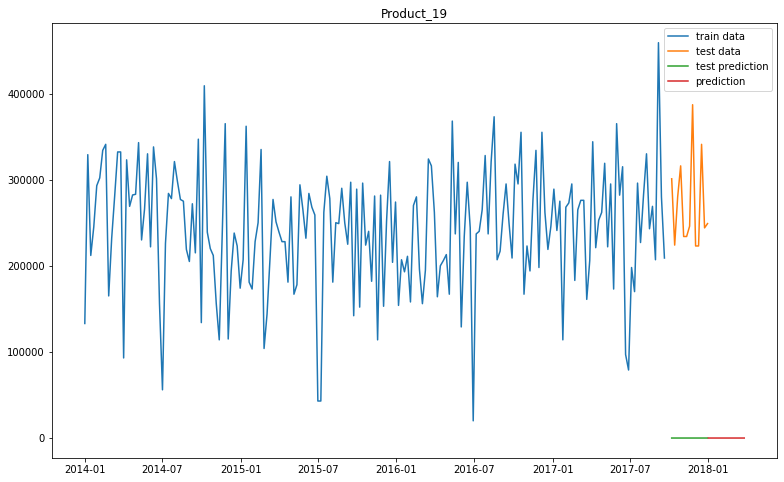

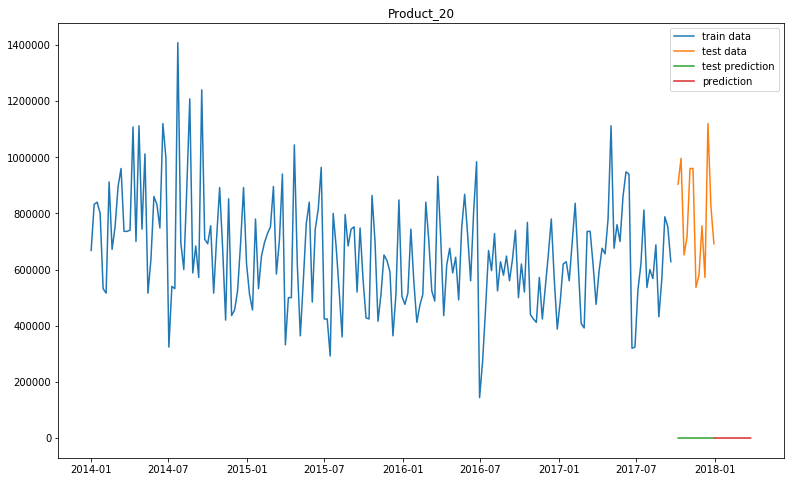

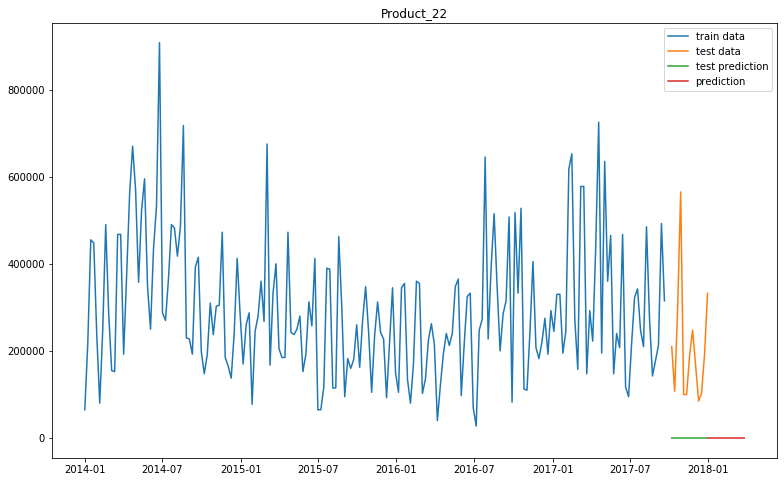

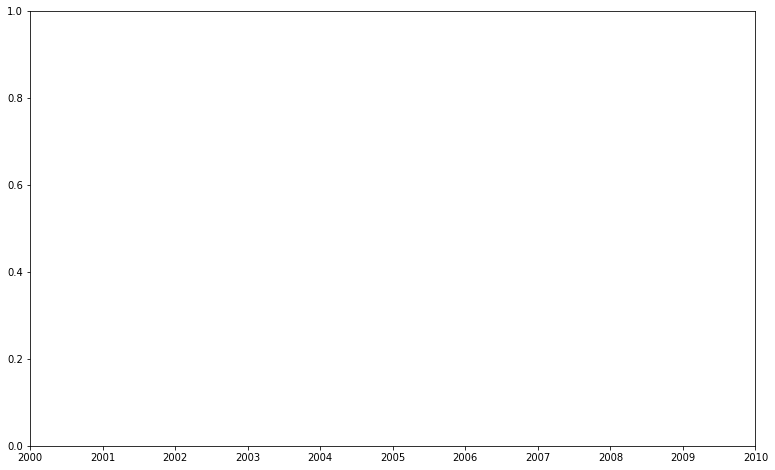

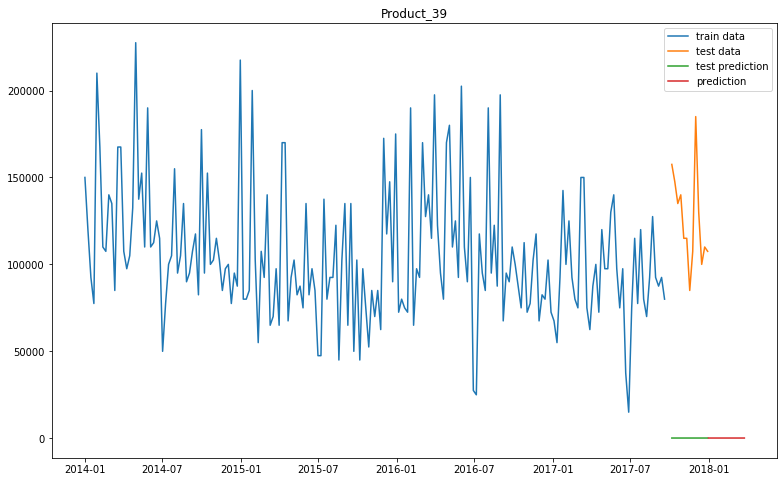

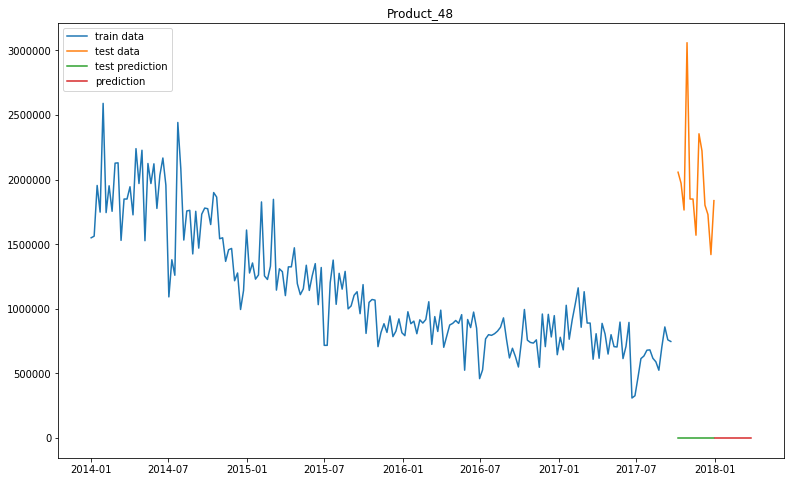

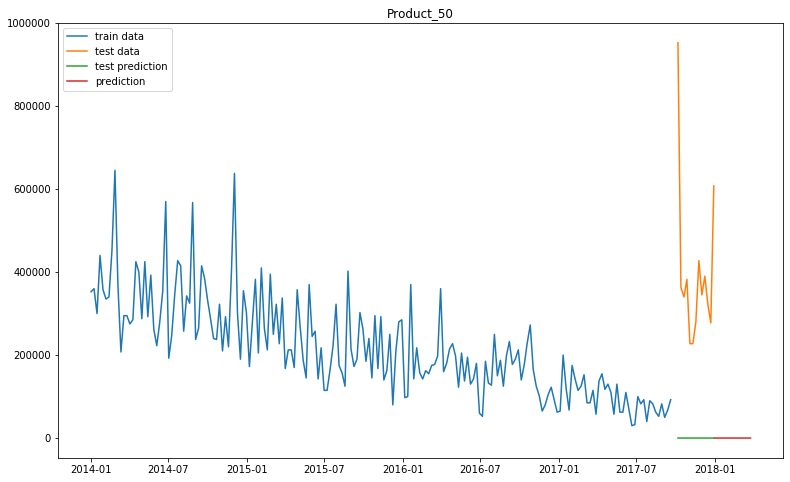

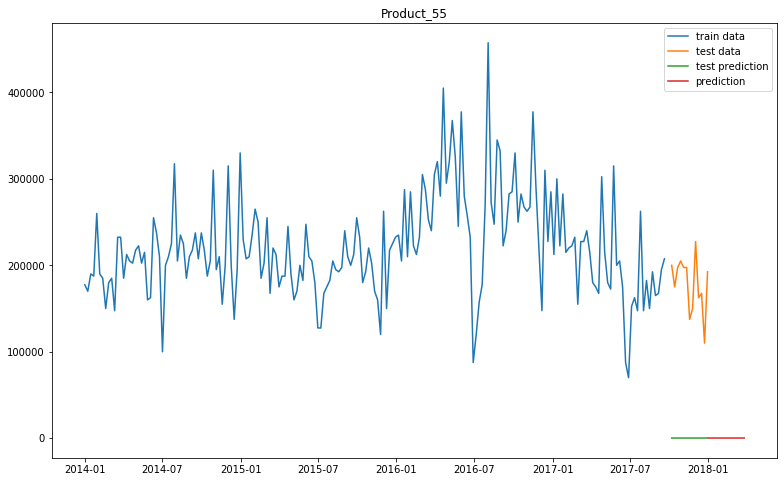

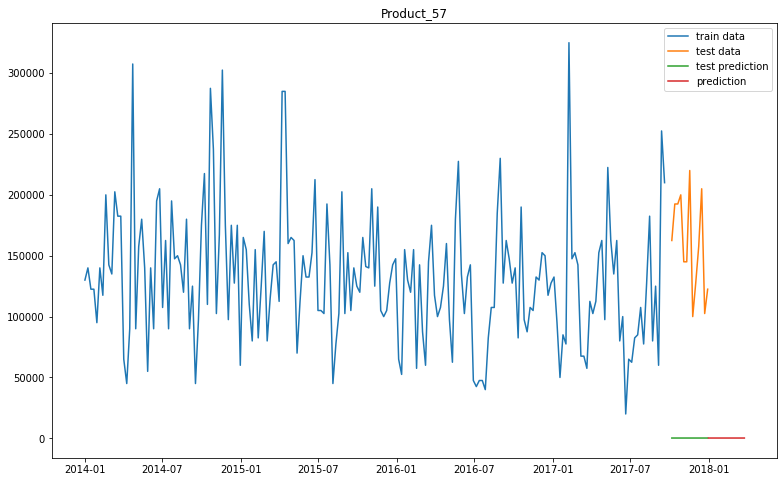

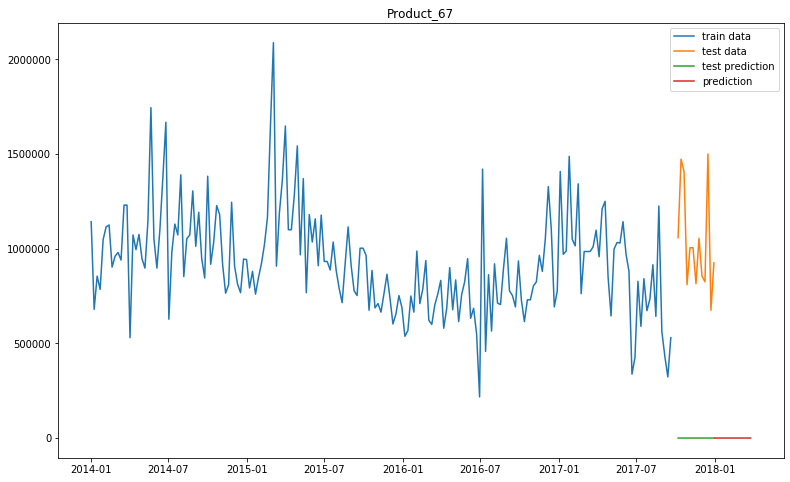

In [274]:
trainer = Trainer(name='NOnorm_NOretrain', retrain=False)
trainer(trains_loaders, tests_loaders, trains, tests, predictions, 0.01, 15)

In [279]:
# NORMAL
products = list(range(0,10))
print(products)

trains = []
tests = []
predictions = []

for prod in products:
    train_set = BillingNormDataset(product=prod, ttp='train')
    test_set = BillingNormDataset(product=prod, ttp='test')
    predict_set = BillingNormDataset(product=prod, ttp='predict')
    trains.append(train_set)
    tests.append(test_set)
    predictions.append(predict_set)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [280]:
batch_size = 1

trains_loaders = [DataLoader(dataset=x, batch_size=batch_size, shuffle=False) for x in trains]
tests_loaders = [DataLoader(dataset=x, batch_size=batch_size, shuffle=False) for x in tests]

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/182], Loss: [80669570311.72342]
Epoch [1/30], Step [20/182], Loss: [70385964405.58069]
Epoch [1/30], Step [30/182], Loss: [76495721152.7732]
Epoch [1/30], Step [40/182], Loss: [55358567182.09795]
Epoch [1/30], Step [50/182], Loss: [51471405578.97146]
Epoch [1/30], Step [60/182], Loss: [50693088846.16638]
Epoch [1/30], Step [70/182], Loss: [56367385525.20694]
Epoch [1/30], Step [80/182], Loss: [60505603012.58569]
Epoch [1/30], Step [90/182], Loss: [53992824517.42937]
Epoch [1/30], Step [100/182], Loss: [54674425820.20349]
Epoch [1/30], Step [110/182], Loss: [54247412902.66799]
Epoch [1/30], Step [120/182], Loss: [55799709157.50918]
Epoch [1/30], Step [130/182], Loss: [68789106377.57924]
Epoch [1/30], Step [140/182], Loss: [71162006940.666]
Epoch [1/30], Step [150/182], Loss: [66947284053.87146]
Epoch [1/30], Step [160/182], Loss: [62584230404.46302]
Epoch [1/30], Step [170/182], Loss: [71664882528.76625]
Epoch [1/30], Step [180/182], Loss: [58794262499.49984]
Epoc

Epoch [9/30], Step [100/182], Loss: [25350327939.33024]
Epoch [9/30], Step [110/182], Loss: [34428022749.97138]
Epoch [9/30], Step [120/182], Loss: [25283482285.701668]
Epoch [9/30], Step [130/182], Loss: [39793047924.047935]
Epoch [9/30], Step [140/182], Loss: [46689033334.72113]
Epoch [9/30], Step [150/182], Loss: [25850435690.001682]
Epoch [9/30], Step [160/182], Loss: [42969324067.94648]
Epoch [9/30], Step [170/182], Loss: [27500580326.957886]
Epoch [9/30], Step [180/182], Loss: [44103231953.738205]
Epoch [10/30], Step [10/182], Loss: [58618768869.51913]
Epoch [10/30], Step [20/182], Loss: [29372734921.25028]
Epoch [10/30], Step [30/182], Loss: [47312643672.94589]
Epoch [10/30], Step [40/182], Loss: [40597608765.094864]
Epoch [10/30], Step [50/182], Loss: [22815540178.354614]
Epoch [10/30], Step [60/182], Loss: [32755305044.337273]
Epoch [10/30], Step [70/182], Loss: [35116290196.80962]
Epoch [10/30], Step [80/182], Loss: [35622316353.827866]
Epoch [10/30], Step [90/182], Loss: [30

Epoch [25/30], Step [120/182], Loss: [15302074309.762568]
Epoch [25/30], Step [130/182], Loss: [7190934737.636774]
Epoch [25/30], Step [140/182], Loss: [3498822691.0575624]
Epoch [25/30], Step [150/182], Loss: [3935115288.089245]
Epoch [25/30], Step [160/182], Loss: [8037093436.478909]
Epoch [25/30], Step [170/182], Loss: [12761697893.174568]
Epoch [25/30], Step [180/182], Loss: [15306646881.06569]
Epoch [26/30], Step [10/182], Loss: [38837419814.15881]
Epoch [26/30], Step [20/182], Loss: [6046772867.945171]
Epoch [26/30], Step [30/182], Loss: [30866333107.588753]
Epoch [26/30], Step [40/182], Loss: [12117201732.872793]
Epoch [26/30], Step [50/182], Loss: [7390809592.326091]
Epoch [26/30], Step [60/182], Loss: [10421917729.023933]
Epoch [26/30], Step [70/182], Loss: [41221680950.917]
Epoch [26/30], Step [80/182], Loss: [9297365020.695976]
Epoch [26/30], Step [90/182], Loss: [6363264207.23993]
Epoch [26/30], Step [100/182], Loss: [9353563450.803463]
Epoch [26/30], Step [110/182], Loss: 

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/182], Loss: [199983968261.5433]
Epoch [1/30], Step [20/182], Loss: [238855730628.98645]
Epoch [1/30], Step [30/182], Loss: [388812340528.1776]
Epoch [1/30], Step [40/182], Loss: [331497423546.7821]
Epoch [1/30], Step [50/182], Loss: [252089094570.94962]
Epoch [1/30], Step [60/182], Loss: [174847547351.49155]
Epoch [1/30], Step [70/182], Loss: [302620684345.921]
Epoch [1/30], Step [80/182], Loss: [130851385952.91792]
Epoch [1/30], Step [90/182], Loss: [66772160915.5449]
Epoch [1/30], Step [100/182], Loss: [230584817398.1938]
Epoch [1/30], Step [110/182], Loss: [102295428376.71936]
Epoch [1/30], Step [120/182], Loss: [164478532084.09042]
Epoch [1/30], Step [130/182], Loss: [93542879274.50969]
Epoch [1/30], Step [140/182], Loss: [54700057240.89884]
Epoch [1/30], Step [150/182], Loss: [188505165143.7066]
Epoch [1/30], Step [160/182], Loss: [51629567766.78524]
Epoch [1/30], Step [170/182], Loss: [171339202688.80298]
Epoch [1/30], Step [180/182], Loss: [352481734367.98

Epoch [9/30], Step [80/182], Loss: [102734290470.49368]
Epoch [9/30], Step [90/182], Loss: [74665987783.24702]
Epoch [9/30], Step [100/182], Loss: [121005412610.89166]
Epoch [9/30], Step [110/182], Loss: [30924276207.774765]
Epoch [9/30], Step [120/182], Loss: [229265015953.24634]
Epoch [9/30], Step [130/182], Loss: [65685690615.53497]
Epoch [9/30], Step [140/182], Loss: [133465850783.80501]
Epoch [9/30], Step [150/182], Loss: [36680250259.03323]
Epoch [9/30], Step [160/182], Loss: [62588623008.6948]
Epoch [9/30], Step [170/182], Loss: [71760157448.79665]
Epoch [9/30], Step [180/182], Loss: [99260358707.56735]
Epoch [10/30], Step [10/182], Loss: [145673523259.19687]
Epoch [10/30], Step [20/182], Loss: [195978255888.28674]
Epoch [10/30], Step [30/182], Loss: [77489233777.30905]
Epoch [10/30], Step [40/182], Loss: [27883293670.76614]
Epoch [10/30], Step [50/182], Loss: [100612570652.5251]
Epoch [10/30], Step [60/182], Loss: [75291079738.36195]
Epoch [10/30], Step [70/182], Loss: [8031559

Epoch [17/30], Step [90/182], Loss: [72361912698.79451]
Epoch [17/30], Step [100/182], Loss: [56180315573.92839]
Epoch [17/30], Step [110/182], Loss: [92115631057.39421]
Epoch [17/30], Step [120/182], Loss: [57614909431.9806]
Epoch [17/30], Step [130/182], Loss: [76135555428.09477]
Epoch [17/30], Step [140/182], Loss: [140038993014.8382]
Epoch [17/30], Step [150/182], Loss: [21659112626.020947]
Epoch [17/30], Step [160/182], Loss: [28780136375.731903]
Epoch [17/30], Step [170/182], Loss: [88846863373.84613]
Epoch [17/30], Step [180/182], Loss: [276675518731.1704]
Epoch [18/30], Step [10/182], Loss: [31501840339.051285]
Epoch [18/30], Step [20/182], Loss: [122281874820.30846]
Epoch [18/30], Step [30/182], Loss: [86216799669.26683]
Epoch [18/30], Step [40/182], Loss: [34664273227.95816]
Epoch [18/30], Step [50/182], Loss: [156538494042.21695]
Epoch [18/30], Step [60/182], Loss: [44284278385.10998]
Epoch [18/30], Step [70/182], Loss: [45648954339.08416]
Epoch [18/30], Step [80/182], Loss:

Epoch [25/30], Step [140/182], Loss: [99568093406.92549]
Epoch [25/30], Step [150/182], Loss: [76002528917.01033]
Epoch [25/30], Step [160/182], Loss: [23265917076.42466]
Epoch [25/30], Step [170/182], Loss: [114914755533.8049]
Epoch [25/30], Step [180/182], Loss: [74716364787.17664]
Epoch [26/30], Step [10/182], Loss: [31205433714.255386]
Epoch [26/30], Step [20/182], Loss: [86539619836.8685]
Epoch [26/30], Step [30/182], Loss: [203232926899.96832]
Epoch [26/30], Step [40/182], Loss: [33356184434.23157]
Epoch [26/30], Step [50/182], Loss: [31719287689.853615]
Epoch [26/30], Step [60/182], Loss: [43301921047.208984]
Epoch [26/30], Step [70/182], Loss: [82940204318.60852]
Epoch [26/30], Step [80/182], Loss: [81172489517.27284]
Epoch [26/30], Step [90/182], Loss: [239386444062.4744]
Epoch [26/30], Step [100/182], Loss: [22136973926.01674]
Epoch [26/30], Step [110/182], Loss: [86885717523.08484]
Epoch [26/30], Step [120/182], Loss: [84774559817.13765]
Epoch [26/30], Step [130/182], Loss: 

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/182], Loss: [37479448499.97995]
Epoch [1/30], Step [20/182], Loss: [31075448086.369736]
Epoch [1/30], Step [30/182], Loss: [79841687289.23679]
Epoch [1/30], Step [40/182], Loss: [27455628634.638176]
Epoch [1/30], Step [50/182], Loss: [20693906530.06183]
Epoch [1/30], Step [60/182], Loss: [110273845649.97957]
Epoch [1/30], Step [70/182], Loss: [13251819964.739695]
Epoch [1/30], Step [80/182], Loss: [60928575135.352196]
Epoch [1/30], Step [90/182], Loss: [18448993009.02847]
Epoch [1/30], Step [100/182], Loss: [17234033403.990772]
Epoch [1/30], Step [110/182], Loss: [10185746626.698322]
Epoch [1/30], Step [120/182], Loss: [17748247723.27802]
Epoch [1/30], Step [130/182], Loss: [62190991612.42529]
Epoch [1/30], Step [140/182], Loss: [66035250780.56418]
Epoch [1/30], Step [150/182], Loss: [6663080480.707267]
Epoch [1/30], Step [160/182], Loss: [61327238076.9562]
Epoch [1/30], Step [170/182], Loss: [33034549379.1807]
Epoch [1/30], Step [180/182], Loss: [14511935508.043

Epoch [17/30], Step [80/182], Loss: [22872085002.021587]
Epoch [17/30], Step [90/182], Loss: [17636979111.22112]
Epoch [17/30], Step [100/182], Loss: [13988144036.405325]
Epoch [17/30], Step [110/182], Loss: [21371649280.866154]
Epoch [17/30], Step [120/182], Loss: [35659568811.07399]
Epoch [17/30], Step [130/182], Loss: [30557440880.38227]
Epoch [17/30], Step [140/182], Loss: [51195318621.29109]
Epoch [17/30], Step [150/182], Loss: [4450151431.477597]
Epoch [17/30], Step [160/182], Loss: [49876113458.23542]
Epoch [17/30], Step [170/182], Loss: [33120323879.853966]
Epoch [17/30], Step [180/182], Loss: [26914982125.560074]
Epoch [18/30], Step [10/182], Loss: [129799300410.00726]
Epoch [18/30], Step [20/182], Loss: [72077960432.75023]
Epoch [18/30], Step [30/182], Loss: [26808672539.90067]
Epoch [18/30], Step [40/182], Loss: [12680019003.375717]
Epoch [18/30], Step [50/182], Loss: [23936110666.03927]
Epoch [18/30], Step [60/182], Loss: [40373271133.4906]
Epoch [18/30], Step [70/182], Los

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/180], Loss: [37120931122.02397]
Epoch [1/30], Step [20/180], Loss: [75432059479.09016]
Epoch [1/30], Step [30/180], Loss: [106370326598.20851]
Epoch [1/30], Step [40/180], Loss: [91641583986.2153]
Epoch [1/30], Step [50/180], Loss: [84769973040.43558]
Epoch [1/30], Step [60/180], Loss: [42638195664.03845]
Epoch [1/30], Step [70/180], Loss: [19310368692.735664]
Epoch [1/30], Step [80/180], Loss: [49789296215.4225]
Epoch [1/30], Step [90/180], Loss: [72717630287.94446]
Epoch [1/30], Step [100/180], Loss: [35450019303.8776]
Epoch [1/30], Step [110/180], Loss: [93035023256.57828]
Epoch [1/30], Step [120/180], Loss: [16282979592.606693]
Epoch [1/30], Step [130/180], Loss: [30933713093.553215]
Epoch [1/30], Step [140/180], Loss: [21637232157.1702]
Epoch [1/30], Step [150/180], Loss: [26684476850.425644]
Epoch [1/30], Step [160/180], Loss: [30393397157.43542]
Epoch [1/30], Step [170/180], Loss: [10645760220.850786]
Epoch [1/30], Step [180/180], Loss: [60740508896.92868]

Epoch [9/30], Step [50/180], Loss: [23672174060.689297]
Epoch [9/30], Step [60/180], Loss: [6800166532.320229]
Epoch [9/30], Step [70/180], Loss: [20986489251.206867]
Epoch [9/30], Step [80/180], Loss: [8330877033.437067]
Epoch [9/30], Step [90/180], Loss: [14966351018.048824]
Epoch [9/30], Step [100/180], Loss: [127313089536.1576]
Epoch [9/30], Step [110/180], Loss: [8734678371.865753]
Epoch [9/30], Step [120/180], Loss: [17062818290.80759]
Epoch [9/30], Step [130/180], Loss: [16216392850.344559]
Epoch [9/30], Step [140/180], Loss: [42467388542.27807]
Epoch [9/30], Step [150/180], Loss: [7086916363.522776]
Epoch [9/30], Step [160/180], Loss: [46586848008.37994]
Epoch [9/30], Step [170/180], Loss: [65464107959.811844]
Epoch [9/30], Step [180/180], Loss: [68739305046.81702]
Epoch [10/30], Step [10/180], Loss: [6915127020.548991]
Epoch [10/30], Step [20/180], Loss: [11214039694.818062]
Epoch [10/30], Step [30/180], Loss: [20506222584.51744]
Epoch [10/30], Step [40/180], Loss: [1179658446

Epoch [17/30], Step [80/180], Loss: [19015804373.800014]
Epoch [17/30], Step [90/180], Loss: [13534050698.62454]
Epoch [17/30], Step [100/180], Loss: [15463328676.831797]
Epoch [17/30], Step [110/180], Loss: [21815062496.511288]
Epoch [17/30], Step [120/180], Loss: [23274114480.001762]
Epoch [17/30], Step [130/180], Loss: [31061536214.954487]
Epoch [17/30], Step [140/180], Loss: [15680596905.90125]
Epoch [17/30], Step [150/180], Loss: [25339256425.425602]
Epoch [17/30], Step [160/180], Loss: [116012873329.85965]
Epoch [17/30], Step [170/180], Loss: [26763419579.453396]
Epoch [17/30], Step [180/180], Loss: [12337594922.196852]
Epoch [18/30], Step [10/180], Loss: [84694433111.99736]
Epoch [18/30], Step [20/180], Loss: [27069364622.141388]
Epoch [18/30], Step [30/180], Loss: [9397213172.274733]
Epoch [18/30], Step [40/180], Loss: [5382564728.712058]
Epoch [18/30], Step [50/180], Loss: [23114051290.225212]
Epoch [18/30], Step [60/180], Loss: [9052948213.08611]
Epoch [18/30], Step [70/180],

Epoch [25/30], Step [110/180], Loss: [12614764162.062513]
Epoch [25/30], Step [120/180], Loss: [18293774433.63658]
Epoch [25/30], Step [130/180], Loss: [32805294231.004807]
Epoch [25/30], Step [140/180], Loss: [23637180840.4856]
Epoch [25/30], Step [150/180], Loss: [28253826255.46179]
Epoch [25/30], Step [160/180], Loss: [16072768791.261763]
Epoch [25/30], Step [170/180], Loss: [11424539752.62879]
Epoch [25/30], Step [180/180], Loss: [20641178692.49586]
Epoch [26/30], Step [10/180], Loss: [6899494037.422854]
Epoch [26/30], Step [20/180], Loss: [27465463363.71931]
Epoch [26/30], Step [30/180], Loss: [122306210637.18724]
Epoch [26/30], Step [40/180], Loss: [9668790944.43282]
Epoch [26/30], Step [50/180], Loss: [96474999867.48259]
Epoch [26/30], Step [60/180], Loss: [64076042402.32127]
Epoch [26/30], Step [70/180], Loss: [15177432146.654938]
Epoch [26/30], Step [80/180], Loss: [9124760474.319824]
Epoch [26/30], Step [90/180], Loss: [7476139122.357]
Epoch [26/30], Step [100/180], Loss: [15

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch [1/30], Step [40/182], Loss: [100693279132.23752]
Epoch [1/30], Step [50/182], Loss: [62606386228.2439]
Epoch [1/30], Step [60/182], Loss: [43728731481.55819]
Epoch [1/30], Step [70/182], Loss: [13728217207.719276]
Epoch [1/30], Step [80/182], Loss: [26933150894.522835]
Epoch [1/30], Step [90/182], Loss: [12279634364.821148]
Epoch [1/30], Step [100/182], Loss: [17837629716.95141]
Epoch [1/30], Step [110/182], Loss: [3243091203.953324]
Epoch [1/30], Step [120/182], Loss: [87008533633.57845]
Epoch [1/30], Step [130/182], Loss: [3245388536.727239]
Epoch [1/30], Step [140/182], Loss: [3260541259.5581713]
Epoch [1/30], Step [150/182], Loss: [37592694249.674965]
Epoch [1/30], Step [160/182], Loss: [23107175008.95097]
Epoch [1/30], Step [170/182], Loss: [55281484253.45451]
Epoch [1/30], Step [180/182], Loss: [8874261823.479929]
Epoch [2/30], Step [10/182], Loss: [10334218361.178625]
Epoch [2/30], Step [20/182], Loss: [15381997415.607708]
Epoch [2/30], Step [30/182], Loss: [38796475497.

Epoch [9/30], Step [80/182], Loss: [1249266751.659808]
Epoch [9/30], Step [90/182], Loss: [4863306538.108289]
Epoch [9/30], Step [100/182], Loss: [10468349723.831053]
Epoch [9/30], Step [110/182], Loss: [3470925294.549966]
Epoch [9/30], Step [120/182], Loss: [24397449724.165283]
Epoch [9/30], Step [130/182], Loss: [2770656939.5771155]
Epoch [9/30], Step [140/182], Loss: [1028360152.7983012]
Epoch [9/30], Step [150/182], Loss: [6885416580.089247]
Epoch [9/30], Step [160/182], Loss: [8915718486.446182]
Epoch [9/30], Step [170/182], Loss: [8237724139.229169]
Epoch [9/30], Step [180/182], Loss: [975791864.0118356]
Epoch [10/30], Step [10/182], Loss: [15280799433.853926]
Epoch [10/30], Step [20/182], Loss: [1441426015.4803545]
Epoch [10/30], Step [30/182], Loss: [11502565703.210812]
Epoch [10/30], Step [40/182], Loss: [9040131998.595171]
Epoch [10/30], Step [50/182], Loss: [6055373848.996696]
Epoch [10/30], Step [60/182], Loss: [4218146651.4517293]
Epoch [10/30], Step [70/182], Loss: [43952

Epoch [17/30], Step [90/182], Loss: [2833506992.1203303]
Epoch [17/30], Step [100/182], Loss: [6974779119.052304]
Epoch [17/30], Step [110/182], Loss: [1778817030.7853575]
Epoch [17/30], Step [120/182], Loss: [4545510398.8278055]
Epoch [17/30], Step [130/182], Loss: [3062666588.21972]
Epoch [17/30], Step [140/182], Loss: [2271173512.105949]
Epoch [17/30], Step [150/182], Loss: [2575026909.1147485]
Epoch [17/30], Step [160/182], Loss: [922259784.5110867]
Epoch [17/30], Step [170/182], Loss: [5666651272.144615]
Epoch [17/30], Step [180/182], Loss: [1620244284.8330438]
Epoch [18/30], Step [10/182], Loss: [1752461767.6587372]
Epoch [18/30], Step [20/182], Loss: [1414131923.4486983]
Epoch [18/30], Step [30/182], Loss: [1059300991.6838199]
Epoch [18/30], Step [40/182], Loss: [783067559.31928]
Epoch [18/30], Step [50/182], Loss: [6601171537.511795]
Epoch [18/30], Step [60/182], Loss: [1487893922.2114449]
Epoch [18/30], Step [70/182], Loss: [2776405131.183397]
Epoch [18/30], Step [80/182], Los

Epoch [25/30], Step [120/182], Loss: [2669193122.658694]
Epoch [25/30], Step [130/182], Loss: [3562796446.6736813]
Epoch [25/30], Step [140/182], Loss: [1582200889.557597]
Epoch [25/30], Step [150/182], Loss: [3519633101.846816]
Epoch [25/30], Step [160/182], Loss: [1383728853.9194264]
Epoch [25/30], Step [170/182], Loss: [1053144889.0678924]
Epoch [25/30], Step [180/182], Loss: [1302785643.3302116]
Epoch [26/30], Step [10/182], Loss: [3044923586.729839]
Epoch [26/30], Step [20/182], Loss: [2500865953.9162235]
Epoch [26/30], Step [30/182], Loss: [887812903.7269167]
Epoch [26/30], Step [40/182], Loss: [1575894407.119304]
Epoch [26/30], Step [50/182], Loss: [6254158479.098776]
Epoch [26/30], Step [60/182], Loss: [2527151854.3548064]
Epoch [26/30], Step [70/182], Loss: [2763593806.9744067]
Epoch [26/30], Step [80/182], Loss: [1094271612.0492876]
Epoch [26/30], Step [90/182], Loss: [2519763860.95691]
Epoch [26/30], Step [100/182], Loss: [2561261858.1580176]
Epoch [26/30], Step [110/182], L

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/182], Loss: [3470279129987.9746]
Epoch [1/30], Step [20/182], Loss: [3199217408417.6714]
Epoch [1/30], Step [30/182], Loss: [2903070430875.8687]
Epoch [1/30], Step [40/182], Loss: [2095538435135.983]
Epoch [1/30], Step [50/182], Loss: [1592685028305.8816]
Epoch [1/30], Step [60/182], Loss: [1469273369616.2686]
Epoch [1/30], Step [70/182], Loss: [1122055245448.2495]
Epoch [1/30], Step [80/182], Loss: [1132047499262.056]
Epoch [1/30], Step [90/182], Loss: [828284542071.9044]
Epoch [1/30], Step [100/182], Loss: [634934434346.6892]
Epoch [1/30], Step [110/182], Loss: [661842289047.709]
Epoch [1/30], Step [120/182], Loss: [637436529221.7705]
Epoch [1/30], Step [130/182], Loss: [459826133934.4991]
Epoch [1/30], Step [140/182], Loss: [514645500733.92224]
Epoch [1/30], Step [150/182], Loss: [564706273857.0007]
Epoch [1/30], Step [160/182], Loss: [725037545622.6945]
Epoch [1/30], Step [170/182], Loss: [494978353872.2302]
Epoch [1/30], Step [180/182], Loss: [340960751000.8

Epoch [17/30], Step [50/182], Loss: [95044992889.19154]
Epoch [17/30], Step [60/182], Loss: [36494108625.65591]
Epoch [17/30], Step [70/182], Loss: [1111311258851.286]
Epoch [17/30], Step [80/182], Loss: [27429625176.343918]
Epoch [17/30], Step [90/182], Loss: [89019793680.83961]
Epoch [17/30], Step [100/182], Loss: [85666270745.89705]
Epoch [17/30], Step [110/182], Loss: [21574743493.12347]
Epoch [17/30], Step [120/182], Loss: [95790858886.87769]
Epoch [17/30], Step [130/182], Loss: [124538217617.53148]
Epoch [17/30], Step [140/182], Loss: [445253331038.3124]
Epoch [17/30], Step [150/182], Loss: [331800668039.6385]
Epoch [17/30], Step [160/182], Loss: [43768118488.692665]
Epoch [17/30], Step [170/182], Loss: [50247237798.24793]
Epoch [17/30], Step [180/182], Loss: [94828253661.303]
Epoch [18/30], Step [10/182], Loss: [893006083745.8779]
Epoch [18/30], Step [20/182], Loss: [1433431328021.73]
Epoch [18/30], Step [30/182], Loss: [110684637806.81276]
Epoch [18/30], Step [40/182], Loss: [1

Epoch [25/30], Step [70/182], Loss: [475622935922.65106]
Epoch [25/30], Step [80/182], Loss: [108021183207.42322]
Epoch [25/30], Step [90/182], Loss: [163721034778.23138]
Epoch [25/30], Step [100/182], Loss: [8097611801.4106865]
Epoch [25/30], Step [110/182], Loss: [62797800341.93358]
Epoch [25/30], Step [120/182], Loss: [51220817680.459114]
Epoch [25/30], Step [130/182], Loss: [459884307513.8903]
Epoch [25/30], Step [140/182], Loss: [59461854963.371254]
Epoch [25/30], Step [150/182], Loss: [20328356941.863777]
Epoch [25/30], Step [160/182], Loss: [29493099112.368183]
Epoch [25/30], Step [170/182], Loss: [102071873233.04395]
Epoch [25/30], Step [180/182], Loss: [41310410132.81393]
Epoch [26/30], Step [10/182], Loss: [374493764221.34143]
Epoch [26/30], Step [20/182], Loss: [514494548922.1352]
Epoch [26/30], Step [30/182], Loss: [227543407490.47647]
Epoch [26/30], Step [40/182], Loss: [87396618503.60452]
Epoch [26/30], Step [50/182], Loss: [204292852442.64703]
Epoch [26/30], Step [60/182

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/182], Loss: [577705061433.6545]
Epoch [1/30], Step [20/182], Loss: [1955931556036.0889]
Epoch [1/30], Step [30/182], Loss: [346185049197.1275]
Epoch [1/30], Step [40/182], Loss: [102760391748.79623]
Epoch [1/30], Step [50/182], Loss: [2516373302011.4307]
Epoch [1/30], Step [60/182], Loss: [641166015887.7263]
Epoch [1/30], Step [70/182], Loss: [2375596349993.909]
Epoch [1/30], Step [80/182], Loss: [394341226329.067]
Epoch [1/30], Step [90/182], Loss: [218472398188.71625]
Epoch [1/30], Step [100/182], Loss: [944451612799.3142]
Epoch [1/30], Step [110/182], Loss: [1037584124899.963]
Epoch [1/30], Step [120/182], Loss: [306911065934.5894]
Epoch [1/30], Step [130/182], Loss: [109971455229.28911]
Epoch [1/30], Step [140/182], Loss: [583479274314.5806]
Epoch [1/30], Step [150/182], Loss: [671090376133.0206]
Epoch [1/30], Step [160/182], Loss: [12448223958.041634]
Epoch [1/30], Step [170/182], Loss: [346940851066.37665]
Epoch [1/30], Step [180/182], Loss: [6537597497.392

Epoch [9/30], Step [90/182], Loss: [359815244342.3346]
Epoch [9/30], Step [100/182], Loss: [296868805746.7371]
Epoch [9/30], Step [110/182], Loss: [23968972609.143272]
Epoch [9/30], Step [120/182], Loss: [276596146591.08344]
Epoch [9/30], Step [130/182], Loss: [49962047724.20451]
Epoch [9/30], Step [140/182], Loss: [149136687882.08765]
Epoch [9/30], Step [150/182], Loss: [118200850223.43976]
Epoch [9/30], Step [160/182], Loss: [77944253544.22018]
Epoch [9/30], Step [170/182], Loss: [61574063453.153175]
Epoch [9/30], Step [180/182], Loss: [33594639413.241978]
Epoch [10/30], Step [10/182], Loss: [126985615885.37958]
Epoch [10/30], Step [20/182], Loss: [483829566381.1925]
Epoch [10/30], Step [30/182], Loss: [90115890580.61414]
Epoch [10/30], Step [40/182], Loss: [80245852595.52573]
Epoch [10/30], Step [50/182], Loss: [464710835476.0305]
Epoch [10/30], Step [60/182], Loss: [9352925573.842087]
Epoch [10/30], Step [70/182], Loss: [478773082660.2276]
Epoch [10/30], Step [80/182], Loss: [12253

Epoch [17/30], Step [130/182], Loss: [22574990124.79403]
Epoch [17/30], Step [140/182], Loss: [70667867246.30838]
Epoch [17/30], Step [150/182], Loss: [12447710934.139608]
Epoch [17/30], Step [160/182], Loss: [8244592810.807971]
Epoch [17/30], Step [170/182], Loss: [25582305201.277737]
Epoch [17/30], Step [180/182], Loss: [5899801097.627862]
Epoch [18/30], Step [10/182], Loss: [16928808443.828804]
Epoch [18/30], Step [20/182], Loss: [40731293213.70962]
Epoch [18/30], Step [30/182], Loss: [13082142472.231674]
Epoch [18/30], Step [40/182], Loss: [158074946952.05682]
Epoch [18/30], Step [50/182], Loss: [6158473523.279349]
Epoch [18/30], Step [60/182], Loss: [5226103856.020053]
Epoch [18/30], Step [70/182], Loss: [155282688095.5051]
Epoch [18/30], Step [80/182], Loss: [16206503079.296783]
Epoch [18/30], Step [90/182], Loss: [11557914620.701008]
Epoch [18/30], Step [100/182], Loss: [7215054465.675877]
Epoch [18/30], Step [110/182], Loss: [57593273484.33335]
Epoch [18/30], Step [120/182], Lo

Epoch [25/30], Step [170/182], Loss: [5801022650.669253]
Epoch [25/30], Step [180/182], Loss: [1488585107.3760529]
Epoch [26/30], Step [10/182], Loss: [35691830327.55718]
Epoch [26/30], Step [20/182], Loss: [71776546107.83589]
Epoch [26/30], Step [30/182], Loss: [49075255775.73942]
Epoch [26/30], Step [40/182], Loss: [21913759961.28489]
Epoch [26/30], Step [50/182], Loss: [46504810017.07028]
Epoch [26/30], Step [60/182], Loss: [61688676610.90946]
Epoch [26/30], Step [70/182], Loss: [8476591856.246908]
Epoch [26/30], Step [80/182], Loss: [11706715929.229115]
Epoch [26/30], Step [90/182], Loss: [36220732205.64143]
Epoch [26/30], Step [100/182], Loss: [6868494595.39835]
Epoch [26/30], Step [110/182], Loss: [3665358914.9090075]
Epoch [26/30], Step [120/182], Loss: [8251552676.978109]
Epoch [26/30], Step [130/182], Loss: [14010752224.809969]
Epoch [26/30], Step [140/182], Loss: [20399165707.323906]
Epoch [26/30], Step [150/182], Loss: [17160850926.505535]
Epoch [26/30], Step [160/182], Loss

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/182], Loss: [117213067308.06865]
Epoch [1/30], Step [20/182], Loss: [4885207066.824455]
Epoch [1/30], Step [30/182], Loss: [11620321263.12057]
Epoch [1/30], Step [40/182], Loss: [54014903951.838135]
Epoch [1/30], Step [50/182], Loss: [5413080356.702552]
Epoch [1/30], Step [60/182], Loss: [119327189795.51155]
Epoch [1/30], Step [70/182], Loss: [3806489603.4384594]
Epoch [1/30], Step [80/182], Loss: [935768411.4826758]
Epoch [1/30], Step [90/182], Loss: [67602216994.85829]
Epoch [1/30], Step [100/182], Loss: [30275513528.0854]
Epoch [1/30], Step [110/182], Loss: [5671313078.8771515]
Epoch [1/30], Step [120/182], Loss: [106283612772.95964]
Epoch [1/30], Step [130/182], Loss: [53393295445.48729]
Epoch [1/30], Step [140/182], Loss: [14449314037.636747]
Epoch [1/30], Step [150/182], Loss: [3661615506.8861365]
Epoch [1/30], Step [160/182], Loss: [68376240024.31032]
Epoch [1/30], Step [170/182], Loss: [48707128749.84079]
Epoch [1/30], Step [180/182], Loss: [2327441755.59

Epoch [9/30], Step [40/182], Loss: [9697574199.66693]
Epoch [9/30], Step [50/182], Loss: [2167893348.9587617]
Epoch [9/30], Step [60/182], Loss: [811280621.4958904]
Epoch [9/30], Step [70/182], Loss: [9615806021.326847]
Epoch [9/30], Step [80/182], Loss: [3842159615.4569807]
Epoch [9/30], Step [90/182], Loss: [4274690913.4370074]
Epoch [9/30], Step [100/182], Loss: [8549490112.021083]
Epoch [9/30], Step [110/182], Loss: [2831856414.093702]
Epoch [9/30], Step [120/182], Loss: [8020034017.94392]
Epoch [9/30], Step [130/182], Loss: [10358375807.667969]
Epoch [9/30], Step [140/182], Loss: [5840975411.663156]
Epoch [9/30], Step [150/182], Loss: [8977585346.916643]
Epoch [9/30], Step [160/182], Loss: [5049827906.150116]
Epoch [9/30], Step [170/182], Loss: [11419435849.523403]
Epoch [9/30], Step [180/182], Loss: [5838062650.866149]
Epoch [10/30], Step [10/182], Loss: [4642064437.629472]
Epoch [10/30], Step [20/182], Loss: [11911750205.922302]
Epoch [10/30], Step [30/182], Loss: [2136917675.97

Epoch [17/30], Step [90/182], Loss: [11326484706.172264]
Epoch [17/30], Step [100/182], Loss: [2318579641.861885]
Epoch [17/30], Step [110/182], Loss: [23540607573.004807]
Epoch [17/30], Step [120/182], Loss: [31552358789.22956]
Epoch [17/30], Step [130/182], Loss: [28533023618.467155]
Epoch [17/30], Step [140/182], Loss: [2137127117.1088157]
Epoch [17/30], Step [150/182], Loss: [9520184673.165327]
Epoch [17/30], Step [160/182], Loss: [1488919818.0811224]
Epoch [17/30], Step [170/182], Loss: [6564373218.803197]
Epoch [17/30], Step [180/182], Loss: [14735382023.664993]
Epoch [18/30], Step [10/182], Loss: [772550376.047335]
Epoch [18/30], Step [20/182], Loss: [10584119663.69127]
Epoch [18/30], Step [30/182], Loss: [3463004005.8524804]
Epoch [18/30], Step [40/182], Loss: [12983547667.475912]
Epoch [18/30], Step [50/182], Loss: [15233933305.676826]
Epoch [18/30], Step [60/182], Loss: [2792826486.49836]
Epoch [18/30], Step [70/182], Loss: [3750026846.2760444]
Epoch [18/30], Step [80/182], L

Epoch [25/30], Step [100/182], Loss: [2247282056.600949]
Epoch [25/30], Step [110/182], Loss: [2406007502.96309]
Epoch [25/30], Step [120/182], Loss: [7935105041.310685]
Epoch [25/30], Step [130/182], Loss: [16566111788.295229]
Epoch [25/30], Step [140/182], Loss: [4322669189.798165]
Epoch [25/30], Step [150/182], Loss: [11357898367.408401]
Epoch [25/30], Step [160/182], Loss: [6990828289.6384]
Epoch [25/30], Step [170/182], Loss: [4147753952.545673]
Epoch [25/30], Step [180/182], Loss: [3707983017.2643647]
Epoch [26/30], Step [10/182], Loss: [5877246696.167117]
Epoch [26/30], Step [20/182], Loss: [9395035285.439175]
Epoch [26/30], Step [30/182], Loss: [10534604522.25018]
Epoch [26/30], Step [40/182], Loss: [4325007383.2752905]
Epoch [26/30], Step [50/182], Loss: [24067560614.87118]
Epoch [26/30], Step [60/182], Loss: [11616395463.745632]
Epoch [26/30], Step [70/182], Loss: [1013928850.9542735]
Epoch [26/30], Step [80/182], Loss: [3493969132.169808]
Epoch [26/30], Step [90/182], Loss: 

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/182], Loss: [16196345647.07222]
Epoch [1/30], Step [20/182], Loss: [2021894802.1509745]
Epoch [1/30], Step [30/182], Loss: [2494373300.915362]
Epoch [1/30], Step [40/182], Loss: [11317270347.921404]
Epoch [1/30], Step [50/182], Loss: [3994615195.979328]
Epoch [1/30], Step [60/182], Loss: [7027319958.489101]
Epoch [1/30], Step [70/182], Loss: [1662804674.709042]
Epoch [1/30], Step [80/182], Loss: [1897519435.5410178]
Epoch [1/30], Step [90/182], Loss: [2761551099.6467576]
Epoch [1/30], Step [100/182], Loss: [7169408649.923374]
Epoch [1/30], Step [110/182], Loss: [2672508920.6049905]
Epoch [1/30], Step [120/182], Loss: [3772967930.162286]
Epoch [1/30], Step [130/182], Loss: [7258626135.55029]
Epoch [1/30], Step [140/182], Loss: [2237586622.5947237]
Epoch [1/30], Step [150/182], Loss: [2810977710.5698423]
Epoch [1/30], Step [160/182], Loss: [6433284359.314636]
Epoch [1/30], Step [170/182], Loss: [3817567973.2795987]
Epoch [1/30], Step [180/182], Loss: [1409658860.88

Epoch [9/30], Step [90/182], Loss: [2179389588.572515]
Epoch [9/30], Step [100/182], Loss: [1402441368.182107]
Epoch [9/30], Step [110/182], Loss: [4421502912.329895]
Epoch [9/30], Step [120/182], Loss: [2564406474.3078113]
Epoch [9/30], Step [130/182], Loss: [3560087840.071986]
Epoch [9/30], Step [140/182], Loss: [3505185228.0128036]
Epoch [9/30], Step [150/182], Loss: [4001013353.691562]
Epoch [9/30], Step [160/182], Loss: [5424205379.903428]
Epoch [9/30], Step [170/182], Loss: [2576440961.2206607]
Epoch [9/30], Step [180/182], Loss: [1497682549.9622216]
Epoch [10/30], Step [10/182], Loss: [7392548496.8582945]
Epoch [10/30], Step [20/182], Loss: [8142699792.095966]
Epoch [10/30], Step [30/182], Loss: [2275275994.0711536]
Epoch [10/30], Step [40/182], Loss: [12106479137.268913]
Epoch [10/30], Step [50/182], Loss: [3132401530.1301484]
Epoch [10/30], Step [60/182], Loss: [10108344495.951353]
Epoch [10/30], Step [70/182], Loss: [2186379089.964136]
Epoch [10/30], Step [80/182], Loss: [222

Epoch [17/30], Step [140/182], Loss: [3081175785.098485]
Epoch [17/30], Step [150/182], Loss: [2958345553.6887484]
Epoch [17/30], Step [160/182], Loss: [5326951595.242243]
Epoch [17/30], Step [170/182], Loss: [4459657509.8870125]
Epoch [17/30], Step [180/182], Loss: [1429969335.1466768]
Epoch [18/30], Step [10/182], Loss: [9595883851.089092]
Epoch [18/30], Step [20/182], Loss: [2088238452.4585576]
Epoch [18/30], Step [30/182], Loss: [11227474586.633615]
Epoch [18/30], Step [40/182], Loss: [18581207815.975414]
Epoch [18/30], Step [50/182], Loss: [2214642786.4095263]
Epoch [18/30], Step [60/182], Loss: [4041872796.343253]
Epoch [18/30], Step [70/182], Loss: [2187448310.406273]
Epoch [18/30], Step [80/182], Loss: [2527811978.514433]
Epoch [18/30], Step [90/182], Loss: [3253608988.8822274]
Epoch [18/30], Step [100/182], Loss: [4198704788.7825255]
Epoch [18/30], Step [110/182], Loss: [1967884368.50701]
Epoch [18/30], Step [120/182], Loss: [3138243359.573174]
Epoch [18/30], Step [130/182], L

Epoch [26/30], Step [10/182], Loss: [5923164378.415482]
Epoch [26/30], Step [20/182], Loss: [2084549821.0319889]
Epoch [26/30], Step [30/182], Loss: [3026289733.680686]
Epoch [26/30], Step [40/182], Loss: [8534977553.235115]
Epoch [26/30], Step [50/182], Loss: [2994065113.081731]
Epoch [26/30], Step [60/182], Loss: [4034137726.87821]
Epoch [26/30], Step [70/182], Loss: [2147170008.4573867]
Epoch [26/30], Step [80/182], Loss: [2240343576.5267944]
Epoch [26/30], Step [90/182], Loss: [1238599430.9103782]
Epoch [26/30], Step [100/182], Loss: [1760947504.0299697]
Epoch [26/30], Step [110/182], Loss: [2641794054.772621]
Epoch [26/30], Step [120/182], Loss: [6607305421.130899]
Epoch [26/30], Step [130/182], Loss: [4677675101.834643]
Epoch [26/30], Step [140/182], Loss: [1848820268.7954907]
Epoch [26/30], Step [150/182], Loss: [1566108675.6637142]
Epoch [26/30], Step [160/182], Loss: [5336744838.959722]
Epoch [26/30], Step [170/182], Loss: [2302847118.0351696]
Epoch [26/30], Step [180/182], Lo

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/182], Loss: [1007248219394.6232]
Epoch [1/30], Step [20/182], Loss: [1071733780096.6512]
Epoch [1/30], Step [30/182], Loss: [961864797279.272]
Epoch [1/30], Step [40/182], Loss: [843543108142.3524]
Epoch [1/30], Step [50/182], Loss: [1039865220328.6143]
Epoch [1/30], Step [60/182], Loss: [1621748175651.4346]
Epoch [1/30], Step [70/182], Loss: [867400768079.6189]
Epoch [1/30], Step [80/182], Loss: [542692705600.41394]
Epoch [1/30], Step [90/182], Loss: [496500168879.2907]
Epoch [1/30], Step [100/182], Loss: [395292025344.8312]
Epoch [1/30], Step [110/182], Loss: [536582327901.9351]
Epoch [1/30], Step [120/182], Loss: [451120772920.9287]
Epoch [1/30], Step [130/182], Loss: [495168346102.5491]
Epoch [1/30], Step [140/182], Loss: [580379809367.9904]
Epoch [1/30], Step [150/182], Loss: [997810550265.7644]
Epoch [1/30], Step [160/182], Loss: [975730846744.9674]
Epoch [1/30], Step [170/182], Loss: [741890495888.767]
Epoch [1/30], Step [180/182], Loss: [523204019489.5057

Epoch [9/30], Step [60/182], Loss: [925210521831.8813]
Epoch [9/30], Step [70/182], Loss: [800114974626.6229]
Epoch [9/30], Step [80/182], Loss: [29730645605.223602]
Epoch [9/30], Step [90/182], Loss: [217474188749.7616]
Epoch [9/30], Step [100/182], Loss: [47426943069.31501]
Epoch [9/30], Step [110/182], Loss: [193733023012.99564]
Epoch [9/30], Step [120/182], Loss: [96779399465.631]
Epoch [9/30], Step [130/182], Loss: [296195986376.7954]
Epoch [9/30], Step [140/182], Loss: [353247624986.639]
Epoch [9/30], Step [150/182], Loss: [625534027600.8645]
Epoch [9/30], Step [160/182], Loss: [567164581714.5852]
Epoch [9/30], Step [170/182], Loss: [364118571282.5477]
Epoch [9/30], Step [180/182], Loss: [112310238066.07436]
Epoch [10/30], Step [10/182], Loss: [265333005164.6867]
Epoch [10/30], Step [20/182], Loss: [747507282255.501]
Epoch [10/30], Step [30/182], Loss: [344395798471.8068]
Epoch [10/30], Step [40/182], Loss: [279444037599.16223]
Epoch [10/30], Step [50/182], Loss: [148609558620.45

Epoch [17/30], Step [100/182], Loss: [14231067839.695072]
Epoch [17/30], Step [110/182], Loss: [79680597788.9319]
Epoch [17/30], Step [120/182], Loss: [85692153678.03763]
Epoch [17/30], Step [130/182], Loss: [147579440034.2376]
Epoch [17/30], Step [140/182], Loss: [100225469123.39674]
Epoch [17/30], Step [150/182], Loss: [78404880318.4784]
Epoch [17/30], Step [160/182], Loss: [646595084046.9254]
Epoch [17/30], Step [170/182], Loss: [539956201589.3484]
Epoch [17/30], Step [180/182], Loss: [77727859198.7561]
Epoch [18/30], Step [10/182], Loss: [112947180332.17815]
Epoch [18/30], Step [20/182], Loss: [93348890235.90785]
Epoch [18/30], Step [30/182], Loss: [232703005097.44864]
Epoch [18/30], Step [40/182], Loss: [169219319642.20688]
Epoch [18/30], Step [50/182], Loss: [143331633499.04938]
Epoch [18/30], Step [60/182], Loss: [200108131985.41446]
Epoch [18/30], Step [70/182], Loss: [509961038620.2121]
Epoch [18/30], Step [80/182], Loss: [293672007022.8898]
Epoch [18/30], Step [90/182], Loss:

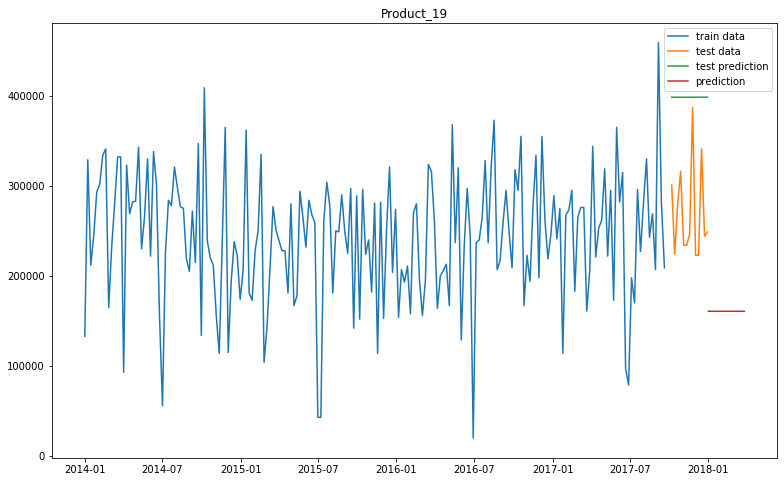

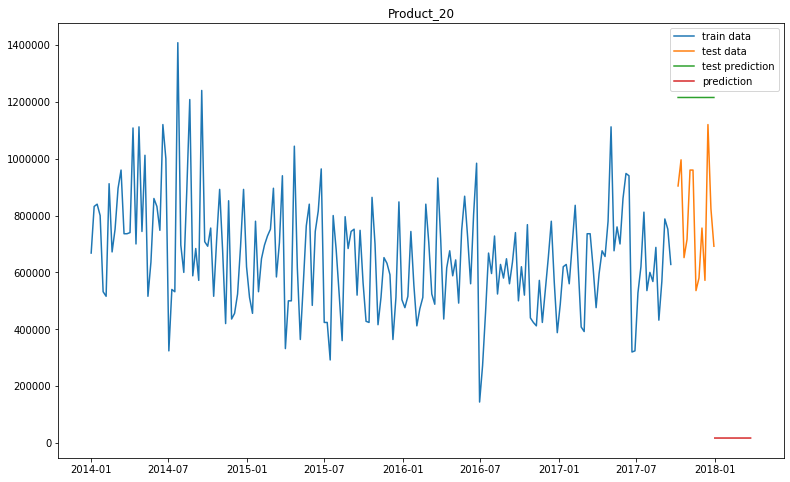

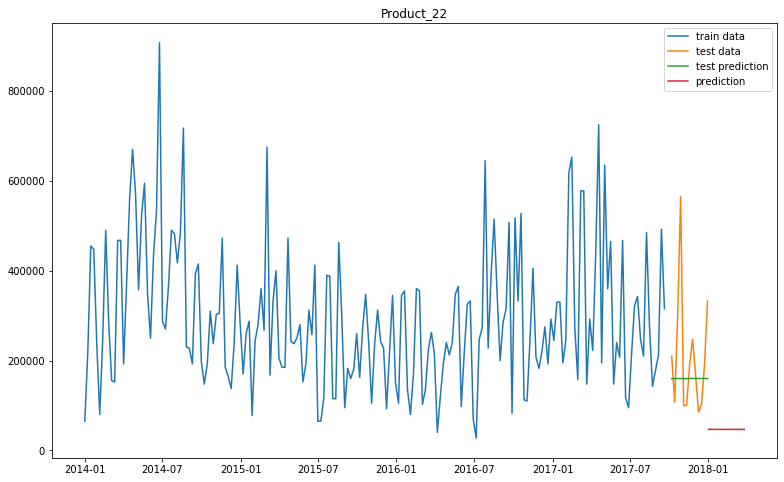

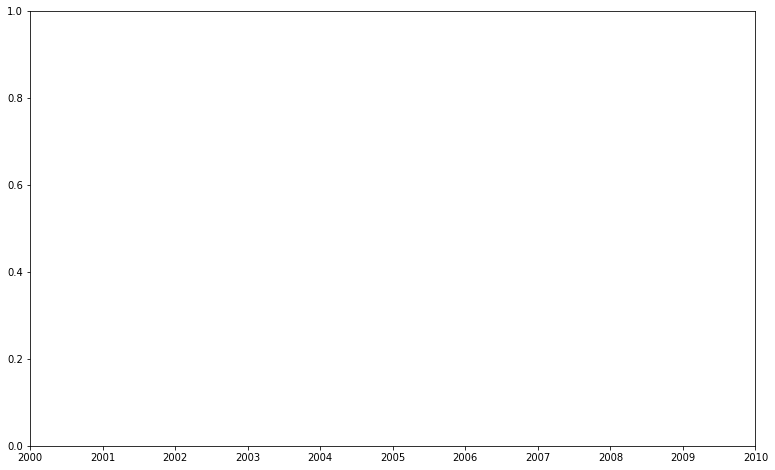

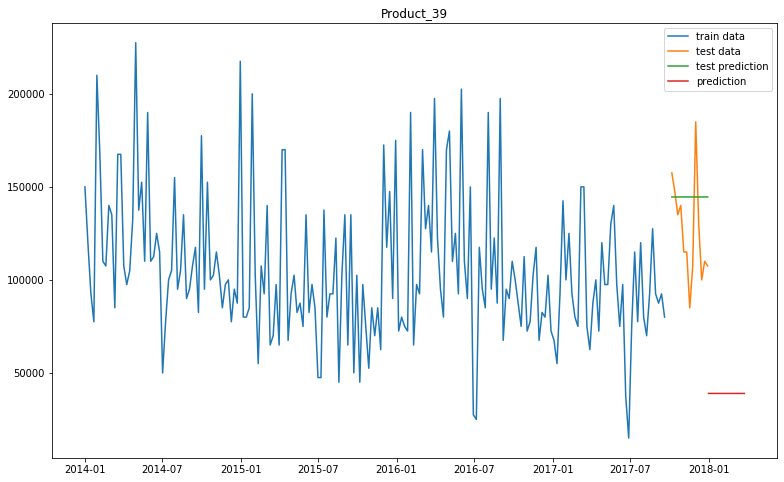

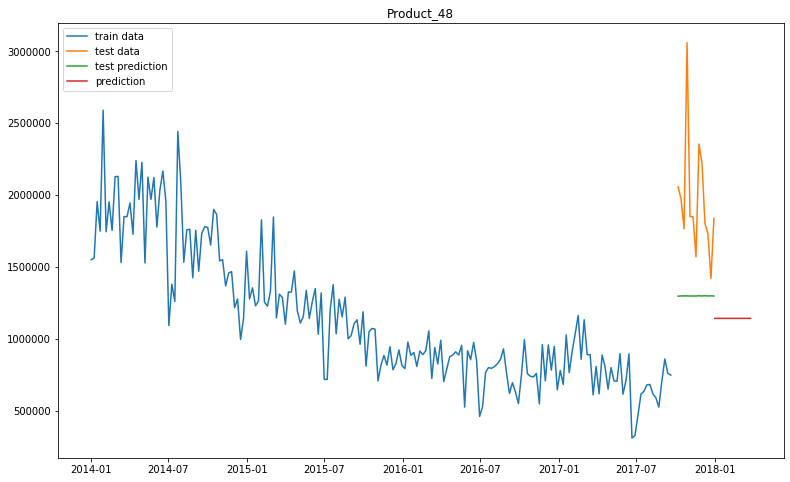

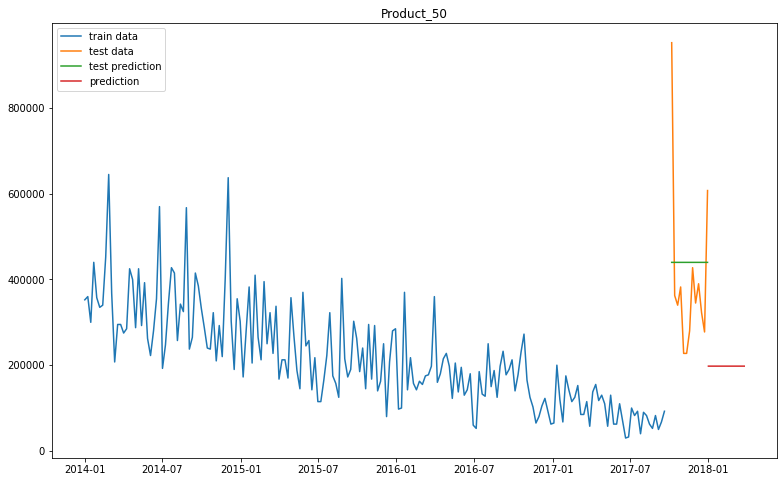

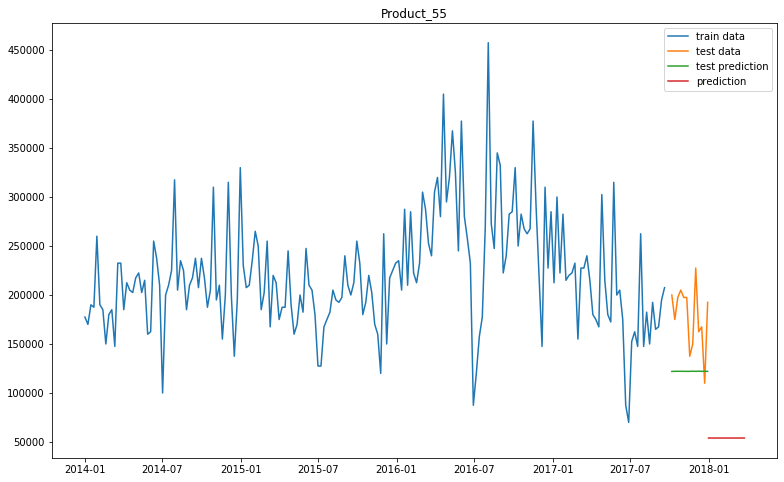

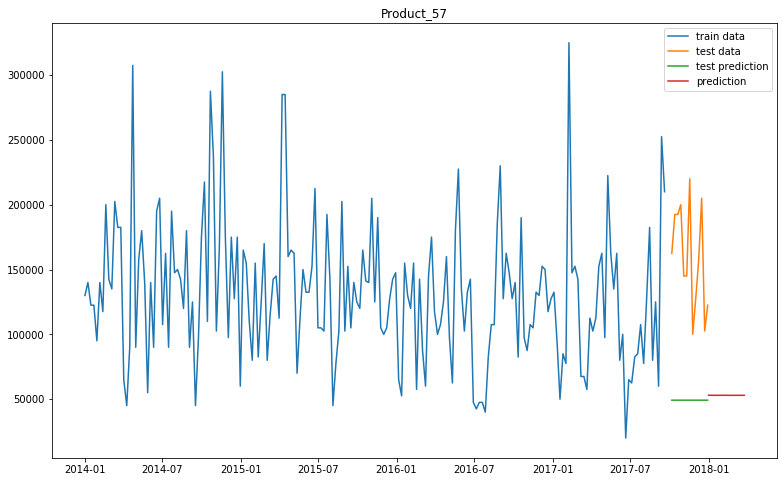

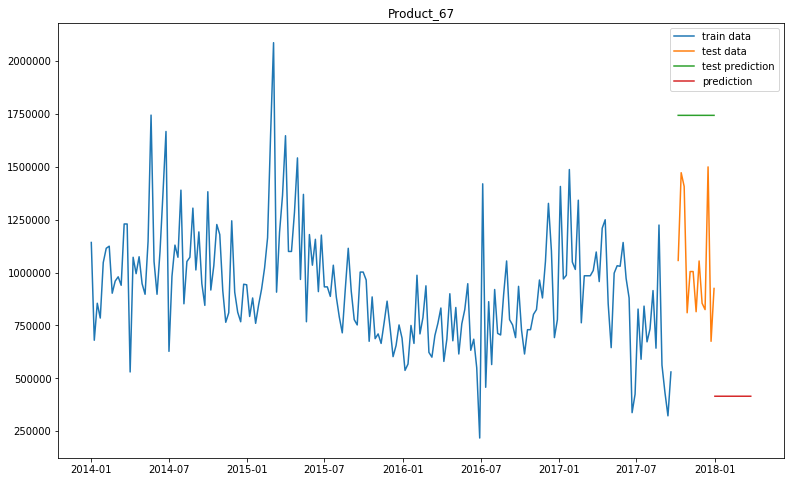

In [292]:
model = TCN_(input_length, output_size, [1,2], 2, 0.1)
model.double()

trainer = Trainer(name='norm_retrain', retrain=True, norm=True)
trainer(trains_loaders, tests_loaders, trains, tests, predictions, 0.001, 30)

# Compare stats 

In [294]:
filenames = ['stats_0.json', 'stats_1.json', 'stats_2.json']

DIR = os.path.join(os.getcwd()+"\..\stats")
if not os.path.exists(DIR):
    print("PROVIDE PATH TO FILE MANUALLY")

PATH = os.path.join(DIR, FILE_NAME)

In [298]:
def compare_mae(fname):
    f1 = open(fname, 'r')
    data = json.load(f1)
    f1.close()
    return data

In [306]:
compare_mae(os.path.join(DIR, filenames[1]))['MSE']

{'Product_19': 74351301154.67055,
 'Product_20': 645388012989.3198,
 'Product_22': 52852149126.22657,
 'Product_30': 161438386986.64923,
 'Product_39': 16272296175.395124,
 'Product_48': 3632056496784.68,
 'Product_50': 103606009382.40736,
 'Product_55': 1005690403.2241877,
 'Product_57': 1553658430.3592,
 'Product_67': 913701357219.1294}

In [ ]:
81419.64690841427


# Median DataSet

In [18]:

products = list(range(0,10))
print(products)

trains = []
tests = []
predictions = []

for prod in products:
    train_set = BillingMedianDataset(product=prod, ttp='train')
    test_set = BillingMedianDataset(product=prod, ttp='test')
    predict_set = BillingMedianDataset(product=prod, ttp='predict')
    trains.append(train_set)
    tests.append(test_set)
    predictions.append(predict_set)
    
batch_size = 1

trains_loaders = [DataLoader(dataset=x, batch_size=batch_size, shuffle=False) for x in trains]
tests_loaders = [DataLoader(dataset=x, batch_size=batch_size, shuffle=False) for x in tests]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [44]:
len(trains_loaders[0])

182

In [47]:
for i,v in enumerate(trains_loaders):
    print(i)
    print(tests[i].x.shape, tests[i].x)

0
torch.Size([14, 13]) tensor([[196910., 171074., 167090., 178101., 178765., 191804., 189891., 192361.,
         193309., 201367., 209772., 182723., 189891.],
        [251957., 246320., 255379., 239889., 249216., 255357., 269261., 279558.,
         222492., 225748., 246320., 194600., 215511.],
        [253764., 245842., 248384., 241125., 251200., 237929., 272773., 295784.,
         303023., 280945., 329160., 253764., 284936.],
        [268371., 242886., 240649., 253228., 239771., 220126., 256083., 265061.,
         277310., 422807., 344773., 328866., 319621.],
        [224634., 216072., 213490., 216830., 230485., 212731., 235650., 224019.,
         224469., 241484., 222646., 183804., 297679.],
        [142888., 146664., 149747., 151589., 134333., 137355., 151507., 113869.,
         125931.,  99626., 241555., 230685., 101019.],
        [203992., 207202., 227478., 245453., 248153., 251527., 249460., 229658.,
         308321., 313362., 326489., 304025., 299827.],
        [234051., 227930.

In [ ]:
input_length=13
output_size=13

model = TCN_(input_length, output_size, [1,2], 2, 0.1)
model.double()

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [80669565315.99779]
Epoch [1/15], Step [20/182], Loss: [70385919020.02022]
Epoch [1/15], Step [30/182], Loss: [76495631262.48982]
Epoch [1/15], Step [40/182], Loss: [55358459865.904274]
Epoch [1/15], Step [50/182], Loss: [51471268510.11718]
Epoch [1/15], Step [60/182], Loss: [50692920782.12786]
Epoch [1/15], Step [70/182], Loss: [56367182822.44895]
Epoch [1/15], Step [80/182], Loss: [60505352355.34312]
Epoch [1/15], Step [90/182], Loss: [53992557712.76049]
Epoch [1/15], Step [100/182], Loss: [54674122739.89602]
Epoch [1/15], Step [110/182], Loss: [54247082773.78287]
Epoch [1/15], Step [120/182], Loss: [55799358472.700165]
Epoch [1/15], Step [130/182], Loss: [68788684483.20558]
Epoch [1/15], Step [140/182], Loss: [71161549035.59717]
Epoch [1/15], Step [150/182], Loss: [66946826972.958664]
Epoch [1/15], Step [160/182], Loss: [62583800600.61279]
Epoch [1/15], Step [170/182], Loss: [71664393208.18138]
Epoch [1/15], Step [180/182], Loss: [58793897084.77325

Epoch [9/15], Step [60/182], Loss: [50686618285.51413]
Epoch [9/15], Step [70/182], Loss: [56360750351.75737]
Epoch [9/15], Step [80/182], Loss: [60498515495.62632]
Epoch [9/15], Step [90/182], Loss: [53986069619.80343]
Epoch [9/15], Step [100/182], Loss: [54667512175.54752]
Epoch [9/15], Step [110/182], Loss: [54240515324.77191]
Epoch [9/15], Step [120/182], Loss: [55792943705.62311]
Epoch [9/15], Step [130/182], Loss: [68781440271.87506]
Epoch [9/15], Step [140/182], Loss: [71153972245.5791]
Epoch [9/15], Step [150/182], Loss: [66939520739.55594]
Epoch [9/15], Step [160/182], Loss: [62576751307.52114]
Epoch [9/15], Step [170/182], Loss: [71656904070.75172]
Epoch [9/15], Step [180/182], Loss: [58787209559.25674]
Epoch [10/15], Step [10/182], Loss: [80660543739.60031]
Epoch [10/15], Step [20/182], Loss: [70377621432.20152]
Epoch [10/15], Step [30/182], Loss: [76486869714.77087]
Epoch [10/15], Step [40/182], Loss: [55351284699.20548]
Epoch [10/15], Step [50/182], Loss: [51464199510.8540

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [715158602697.6038]
Epoch [1/15], Step [20/182], Loss: [647878715822.7513]
Epoch [1/15], Step [30/182], Loss: [736185577539.2467]
Epoch [1/15], Step [40/182], Loss: [456224816319.14777]
Epoch [1/15], Step [50/182], Loss: [469011505165.9199]
Epoch [1/15], Step [60/182], Loss: [472601195189.23816]
Epoch [1/15], Step [70/182], Loss: [429396754467.59766]
Epoch [1/15], Step [80/182], Loss: [395360595771.9319]
Epoch [1/15], Step [90/182], Loss: [345363752168.7983]
Epoch [1/15], Step [100/182], Loss: [317494076877.5805]
Epoch [1/15], Step [110/182], Loss: [393538637748.39856]
Epoch [1/15], Step [120/182], Loss: [438354854830.8481]
Epoch [1/15], Step [130/182], Loss: [365302988663.55615]
Epoch [1/15], Step [140/182], Loss: [325376218822.5485]
Epoch [1/15], Step [150/182], Loss: [329711858000.10736]
Epoch [1/15], Step [160/182], Loss: [392887930818.3823]
Epoch [1/15], Step [170/182], Loss: [574029427863.2449]
Epoch [1/15], Step [180/182], Loss: [404943517904.5

Epoch [9/15], Step [70/182], Loss: [429378885184.2565]
Epoch [9/15], Step [80/182], Loss: [395343167652.4555]
Epoch [9/15], Step [90/182], Loss: [345347360010.1439]
Epoch [9/15], Step [100/182], Loss: [317478289849.5855]
Epoch [9/15], Step [110/182], Loss: [393521139834.63416]
Epoch [9/15], Step [120/182], Loss: [438336893625.8157]
Epoch [9/15], Step [130/182], Loss: [365286555728.56586]
Epoch [9/15], Step [140/182], Loss: [325360147159.1466]
Epoch [9/15], Step [150/182], Loss: [329695652905.85004]
Epoch [9/15], Step [160/182], Loss: [392870265404.9698]
Epoch [9/15], Step [170/182], Loss: [574008408372.7036]
Epoch [9/15], Step [180/182], Loss: [404926074000.21234]
Epoch [10/15], Step [10/182], Loss: [715132011696.8416]
Epoch [10/15], Step [20/182], Loss: [647854433528.179]
Epoch [10/15], Step [30/182], Loss: [736159422806.7614]
Epoch [10/15], Step [40/182], Loss: [456203681959.71265]
Epoch [10/15], Step [50/182], Loss: [468989836029.8116]
Epoch [10/15], Step [60/182], Loss: [4725800279

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [201739386212.3137]
Epoch [1/15], Step [20/182], Loss: [233998335732.72754]
Epoch [1/15], Step [30/182], Loss: [150965967953.67972]
Epoch [1/15], Step [40/182], Loss: [74297318420.77745]
Epoch [1/15], Step [50/182], Loss: [100494967485.31474]
Epoch [1/15], Step [60/182], Loss: [112800220366.71948]
Epoch [1/15], Step [70/182], Loss: [63428818484.51127]
Epoch [1/15], Step [80/182], Loss: [63059311298.69112]
Epoch [1/15], Step [90/182], Loss: [52964504792.58259]
Epoch [1/15], Step [100/182], Loss: [57449215158.17444]
Epoch [1/15], Step [110/182], Loss: [45830319311.99195]
Epoch [1/15], Step [120/182], Loss: [57241297354.443985]
Epoch [1/15], Step [130/182], Loss: [113812787911.14018]
Epoch [1/15], Step [140/182], Loss: [110220677739.35854]
Epoch [1/15], Step [150/182], Loss: [70965591516.99916]
Epoch [1/15], Step [160/182], Loss: [163676058816.16504]
Epoch [1/15], Step [170/182], Loss: [153341733398.50372]
Epoch [1/15], Step [180/182], Loss: [78433244525

Epoch [9/15], Step [40/182], Loss: [74290201241.85416]
Epoch [9/15], Step [50/182], Loss: [100487000014.3958]
Epoch [9/15], Step [60/182], Loss: [112791629970.72171]
Epoch [9/15], Step [70/182], Loss: [63422392594.67387]
Epoch [9/15], Step [80/182], Loss: [63053190043.40093]
Epoch [9/15], Step [90/182], Loss: [52958365305.63429]
Epoch [9/15], Step [100/182], Loss: [57443106985.83834]
Epoch [9/15], Step [110/182], Loss: [45824919131.81685]
Epoch [9/15], Step [120/182], Loss: [57235270251.053505]
Epoch [9/15], Step [130/182], Loss: [113804404479.87636]
Epoch [9/15], Step [140/182], Loss: [110212360355.07988]
Epoch [9/15], Step [150/182], Loss: [70958318337.46233]
Epoch [9/15], Step [160/182], Loss: [163665846788.25195]
Epoch [9/15], Step [170/182], Loss: [153331981053.25623]
Epoch [9/15], Step [180/182], Loss: [78426102069.92162]
Epoch [10/15], Step [10/182], Loss: [201726289488.11722]
Epoch [10/15], Step [20/182], Loss: [233984079779.99777]
Epoch [10/15], Step [30/182], Loss: [150954864

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/180], Loss: [243517918839.80856]
Epoch [1/15], Step [20/180], Loss: [207773796180.63687]
Epoch [1/15], Step [30/180], Loss: [177083230633.4347]
Epoch [1/15], Step [40/180], Loss: [130549846969.59685]
Epoch [1/15], Step [50/180], Loss: [161228757936.1845]
Epoch [1/15], Step [60/180], Loss: [199758254063.99872]
Epoch [1/15], Step [70/180], Loss: [148960116441.11435]
Epoch [1/15], Step [80/180], Loss: [146603702040.25635]
Epoch [1/15], Step [90/180], Loss: [175968249218.87848]
Epoch [1/15], Step [100/180], Loss: [158402895134.45816]
Epoch [1/15], Step [110/180], Loss: [194623647001.49918]
Epoch [1/15], Step [120/180], Loss: [182425879518.82886]
Epoch [1/15], Step [130/180], Loss: [160585589076.13486]
Epoch [1/15], Step [140/180], Loss: [200500789012.67126]
Epoch [1/15], Step [150/180], Loss: [205916352655.1484]
Epoch [1/15], Step [160/180], Loss: [265962768820.40985]
Epoch [1/15], Step [170/180], Loss: [212649564301.13333]
Epoch [1/15], Step [180/180], Loss: [145592

Epoch [9/15], Step [40/180], Loss: [130539559643.40465]
Epoch [9/15], Step [50/180], Loss: [161217382038.47214]
Epoch [9/15], Step [60/180], Loss: [199745641277.39108]
Epoch [9/15], Step [70/180], Loss: [148949297601.55508]
Epoch [9/15], Step [80/180], Loss: [146592867018.93384]
Epoch [9/15], Step [90/180], Loss: [175956383006.49536]
Epoch [9/15], Step [100/180], Loss: [158391621048.87247]
Epoch [9/15], Step [110/180], Loss: [194611199232.90195]
Epoch [9/15], Step [120/180], Loss: [182414183987.57162]
Epoch [9/15], Step [130/180], Loss: [160574684080.86276]
Epoch [9/15], Step [140/180], Loss: [200488092834.6323]
Epoch [9/15], Step [150/180], Loss: [205903536828.19907]
Epoch [9/15], Step [160/180], Loss: [265948332683.8564]
Epoch [9/15], Step [170/180], Loss: [212636622856.75787]
Epoch [9/15], Step [180/180], Loss: [145581763167.9666]
Epoch [10/15], Step [10/180], Loss: [243502234308.68552]
Epoch [10/15], Step [20/180], Loss: [207759491648.22638]
Epoch [10/15], Step [30/180], Loss: [177

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch [1/15], Step [60/182], Loss: [11577608794.924688]
Epoch [1/15], Step [70/182], Loss: [8498680073.590214]
Epoch [1/15], Step [80/182], Loss: [9664097940.678541]
Epoch [1/15], Step [90/182], Loss: [9054941746.008005]
Epoch [1/15], Step [100/182], Loss: [13847113032.957546]
Epoch [1/15], Step [110/182], Loss: [18026668266.516636]
Epoch [1/15], Step [120/182], Loss: [15213709911.476994]
Epoch [1/15], Step [130/182], Loss: [13386068435.461105]
Epoch [1/15], Step [140/182], Loss: [11078228305.103258]
Epoch [1/15], Step [150/182], Loss: [8464286079.11508]
Epoch [1/15], Step [160/182], Loss: [11305136305.955088]
Epoch [1/15], Step [170/182], Loss: [9423910839.611332]
Epoch [1/15], Step [180/182], Loss: [7727200392.85393]
Epoch [2/15], Step [10/182], Loss: [20994582725.249302]
Epoch [2/15], Step [20/182], Loss: [14409014057.334177]
Epoch [2/15], Step [30/182], Loss: [14313544746.860722]
Epoch [2/15], Step [40/182], Loss: [12087737856.664827]
Epoch [2/15], Step [50/182], Loss: [1407322701

Epoch [9/15], Step [80/182], Loss: [9661438282.565859]
Epoch [9/15], Step [90/182], Loss: [9052408440.53919]
Epoch [9/15], Step [100/182], Loss: [13843989420.510187]
Epoch [9/15], Step [110/182], Loss: [18023003833.356647]
Epoch [9/15], Step [120/182], Loss: [15210497054.132486]
Epoch [9/15], Step [130/182], Loss: [13383080965.28186]
Epoch [9/15], Step [140/182], Loss: [11075350531.56067]
Epoch [9/15], Step [150/182], Loss: [8461728000.50481]
Epoch [9/15], Step [160/182], Loss: [11302197037.568829]
Epoch [9/15], Step [170/182], Loss: [9421230848.969585]
Epoch [9/15], Step [180/182], Loss: [7724829498.821095]
Epoch [10/15], Step [10/182], Loss: [20990577317.802322]
Epoch [10/15], Step [20/182], Loss: [14405709426.619192]
Epoch [10/15], Step [30/182], Loss: [14310206433.343681]
Epoch [10/15], Step [40/182], Loss: [12084675222.029175]
Epoch [10/15], Step [50/182], Loss: [14070092087.325829]
Epoch [10/15], Step [60/182], Loss: [11574331989.857924]
Epoch [10/15], Step [70/182], Loss: [84958

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [3813720049224.06]
Epoch [1/15], Step [20/182], Loss: [3544064587593.0664]
Epoch [1/15], Step [30/182], Loss: [3214114574987.6665]
Epoch [1/15], Step [40/182], Loss: [2254139261496.4272]
Epoch [1/15], Step [50/182], Loss: [1899478754147.3037]
Epoch [1/15], Step [60/182], Loss: [1712178849869.7275]
Epoch [1/15], Step [70/182], Loss: [1359210197444.233]
Epoch [1/15], Step [80/182], Loss: [1263790607248.9507]
Epoch [1/15], Step [90/182], Loss: [907221109699.9159]
Epoch [1/15], Step [100/182], Loss: [757053302066.5631]
Epoch [1/15], Step [110/182], Loss: [767230347808.8917]
Epoch [1/15], Step [120/182], Loss: [670291344728.5688]
Epoch [1/15], Step [130/182], Loss: [573883457603.395]
Epoch [1/15], Step [140/182], Loss: [550680795740.8464]
Epoch [1/15], Step [150/182], Loss: [668614271543.9335]
Epoch [1/15], Step [160/182], Loss: [822548482579.299]
Epoch [1/15], Step [170/182], Loss: [547041145149.1232]
Epoch [1/15], Step [180/182], Loss: [379742203350.5079

Epoch [9/15], Step [70/182], Loss: [1359179639849.646]
Epoch [9/15], Step [80/182], Loss: [1263760932257.8206]
Epoch [9/15], Step [90/182], Loss: [907195956456.3258]
Epoch [9/15], Step [100/182], Loss: [757030086894.8754]
Epoch [9/15], Step [110/182], Loss: [767207041216.5427]
Epoch [9/15], Step [120/182], Loss: [670269887168.6813]
Epoch [9/15], Step [130/182], Loss: [573863457704.8943]
Epoch [9/15], Step [140/182], Loss: [550661200512.9368]
Epoch [9/15], Step [150/182], Loss: [668592659158.7234]
Epoch [9/15], Step [160/182], Loss: [822524554004.2864]
Epoch [9/15], Step [170/182], Loss: [547021732957.44916]
Epoch [9/15], Step [180/182], Loss: [379726190383.2272]
Epoch [10/15], Step [10/182], Loss: [3813662662130.2803]
Epoch [10/15], Step [20/182], Loss: [3544009950574.911]
Epoch [10/15], Step [30/182], Loss: [3214061774597.767]
Epoch [10/15], Step [40/182], Loss: [2254095161901.0083]
Epoch [10/15], Step [50/182], Loss: [1899438160119.4607]
Epoch [10/15], Step [60/182], Loss: [171214002

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [109238278253.22116]
Epoch [1/15], Step [20/182], Loss: [117278335565.34909]
Epoch [1/15], Step [30/182], Loss: [127902736191.99577]
Epoch [1/15], Step [40/182], Loss: [108464618264.24164]
Epoch [1/15], Step [50/182], Loss: [87880280606.9623]
Epoch [1/15], Step [60/182], Loss: [70313671676.02922]
Epoch [1/15], Step [70/182], Loss: [52974780734.58015]
Epoch [1/15], Step [80/182], Loss: [53739640702.893875]
Epoch [1/15], Step [90/182], Loss: [48003013900.53131]
Epoch [1/15], Step [100/182], Loss: [43563204665.12957]
Epoch [1/15], Step [110/182], Loss: [40673853911.5604]
Epoch [1/15], Step [120/182], Loss: [27589076455.528927]
Epoch [1/15], Step [130/182], Loss: [28191151641.516953]
Epoch [1/15], Step [140/182], Loss: [33918153420.121845]
Epoch [1/15], Step [150/182], Loss: [12970257395.646118]
Epoch [1/15], Step [160/182], Loss: [15031929923.612707]
Epoch [1/15], Step [170/182], Loss: [10351402381.198437]
Epoch [1/15], Step [180/182], Loss: [5692034367.

Epoch [9/15], Step [50/182], Loss: [87872790128.1719]
Epoch [9/15], Step [60/182], Loss: [70306973665.34523]
Epoch [9/15], Step [70/182], Loss: [52969104942.05716]
Epoch [9/15], Step [80/182], Loss: [53733914852.53555]
Epoch [9/15], Step [90/182], Loss: [47997513322.13139]
Epoch [9/15], Step [100/182], Loss: [43558144355.68204]
Epoch [9/15], Step [110/182], Loss: [40668717290.386284]
Epoch [9/15], Step [120/182], Loss: [27584917681.659203]
Epoch [9/15], Step [130/182], Loss: [28186964676.681442]
Epoch [9/15], Step [140/182], Loss: [33913495470.378044]
Epoch [9/15], Step [150/182], Loss: [12967442816.871706]
Epoch [9/15], Step [160/182], Loss: [15028808695.509604]
Epoch [9/15], Step [170/182], Loss: [10348897753.531515]
Epoch [9/15], Step [180/182], Loss: [5690146699.6285]
Epoch [10/15], Step [10/182], Loss: [109228808817.5876]
Epoch [10/15], Step [20/182], Loss: [117268737989.14076]
Epoch [10/15], Step [30/182], Loss: [127892577111.66753]
Epoch [10/15], Step [40/182], Loss: [1084554899

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [41168202101.67271]
Epoch [1/15], Step [20/182], Loss: [45487050332.36137]
Epoch [1/15], Step [30/182], Loss: [50938341358.029976]
Epoch [1/15], Step [40/182], Loss: [47560122617.47932]
Epoch [1/15], Step [50/182], Loss: [51771082851.08099]
Epoch [1/15], Step [60/182], Loss: [39422172682.11953]
Epoch [1/15], Step [70/182], Loss: [33385930463.410706]
Epoch [1/15], Step [80/182], Loss: [39637891706.786934]
Epoch [1/15], Step [90/182], Loss: [40189367660.66317]
Epoch [1/15], Step [100/182], Loss: [50509912536.2399]
Epoch [1/15], Step [110/182], Loss: [80808418250.45686]
Epoch [1/15], Step [120/182], Loss: [84196312657.39911]
Epoch [1/15], Step [130/182], Loss: [68127726641.65124]
Epoch [1/15], Step [140/182], Loss: [82089074349.43706]
Epoch [1/15], Step [150/182], Loss: [69673562984.95497]
Epoch [1/15], Step [160/182], Loss: [47757187522.83721]
Epoch [1/15], Step [170/182], Loss: [42751069274.913635]
Epoch [1/15], Step [180/182], Loss: [28199648679.29135

Epoch [9/15], Step [80/182], Loss: [39632203785.55925]
Epoch [9/15], Step [90/182], Loss: [40183688253.39431]
Epoch [9/15], Step [100/182], Loss: [50503553022.86316]
Epoch [9/15], Step [110/182], Loss: [80800335586.55548]
Epoch [9/15], Step [120/182], Loss: [84188343767.75848]
Epoch [9/15], Step [130/182], Loss: [68120713277.254486]
Epoch [9/15], Step [140/182], Loss: [82080890572.98445]
Epoch [9/15], Step [150/182], Loss: [69666122024.7002]
Epoch [9/15], Step [160/182], Loss: [47750944282.96022]
Epoch [9/15], Step [170/182], Loss: [42745324894.46017]
Epoch [9/15], Step [180/182], Loss: [28194991884.354134]
Epoch [10/15], Step [10/182], Loss: [41161631944.75415]
Epoch [10/15], Step [20/182], Loss: [45480285018.43501]
Epoch [10/15], Step [30/182], Loss: [50931060607.14647]
Epoch [10/15], Step [40/182], Loss: [47553202664.71218]
Epoch [10/15], Step [50/182], Loss: [51763821638.91283]
Epoch [10/15], Step [60/182], Loss: [39415777648.19904]
Epoch [10/15], Step [70/182], Loss: [33380075764.

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [24762175949.630413]
Epoch [1/15], Step [20/182], Loss: [22333451116.277767]
Epoch [1/15], Step [30/182], Loss: [21070550203.260487]
Epoch [1/15], Step [40/182], Loss: [36600552036.74464]
Epoch [1/15], Step [50/182], Loss: [17839308138.35748]
Epoch [1/15], Step [60/182], Loss: [27989666319.80089]
Epoch [1/15], Step [70/182], Loss: [20466591962.3125]
Epoch [1/15], Step [80/182], Loss: [16751927115.238897]
Epoch [1/15], Step [90/182], Loss: [19418320035.062515]
Epoch [1/15], Step [100/182], Loss: [13798990411.175125]
Epoch [1/15], Step [110/182], Loss: [15451803956.204361]
Epoch [1/15], Step [120/182], Loss: [16949533732.455202]
Epoch [1/15], Step [130/182], Loss: [14585125007.920067]
Epoch [1/15], Step [140/182], Loss: [19434162101.246735]
Epoch [1/15], Step [150/182], Loss: [13426777132.335331]
Epoch [1/15], Step [160/182], Loss: [18021203674.01944]
Epoch [1/15], Step [170/182], Loss: [17818618577.400257]
Epoch [1/15], Step [180/182], Loss: [981575582

Epoch [9/15], Step [50/182], Loss: [17835664792.774807]
Epoch [9/15], Step [60/182], Loss: [27985233941.74085]
Epoch [9/15], Step [70/182], Loss: [20462646162.420357]
Epoch [9/15], Step [80/182], Loss: [16748419283.206987]
Epoch [9/15], Step [90/182], Loss: [19414433103.244087]
Epoch [9/15], Step [100/182], Loss: [13795771117.788242]
Epoch [9/15], Step [110/182], Loss: [15448384855.90703]
Epoch [9/15], Step [120/182], Loss: [16946091533.238264]
Epoch [9/15], Step [130/182], Loss: [14582106983.268324]
Epoch [9/15], Step [140/182], Loss: [19430332238.402122]
Epoch [9/15], Step [150/182], Loss: [13423553971.742453]
Epoch [9/15], Step [160/182], Loss: [18017897336.65315]
Epoch [9/15], Step [170/182], Loss: [17815041410.77382]
Epoch [9/15], Step [180/182], Loss: [9813122710.81383]
Epoch [10/15], Step [10/182], Loss: [24757653996.45193]
Epoch [10/15], Step [20/182], Loss: [22328866774.239788]
Epoch [10/15], Step [30/182], Loss: [21066118817.72423]
Epoch [10/15], Step [40/182], Loss: [3659474

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [1200986107218.0215]
Epoch [1/15], Step [20/182], Loss: [1430847712265.3252]
Epoch [1/15], Step [30/182], Loss: [1203200710978.474]
Epoch [1/15], Step [40/182], Loss: [1023580305876.306]
Epoch [1/15], Step [50/182], Loss: [1234463651893.6055]
Epoch [1/15], Step [60/182], Loss: [1884729013875.9297]
Epoch [1/15], Step [70/182], Loss: [1183901637130.5767]
Epoch [1/15], Step [80/182], Loss: [826495908898.7565]
Epoch [1/15], Step [90/182], Loss: [646202915365.7029]
Epoch [1/15], Step [100/182], Loss: [526220482035.3141]
Epoch [1/15], Step [110/182], Loss: [581534257556.2769]
Epoch [1/15], Step [120/182], Loss: [630515238333.63]
Epoch [1/15], Step [130/182], Loss: [659216133280.7811]
Epoch [1/15], Step [140/182], Loss: [664314703447.6255]
Epoch [1/15], Step [150/182], Loss: [1135509986998.2737]
Epoch [1/15], Step [160/182], Loss: [1170292085649.3298]
Epoch [1/15], Step [170/182], Loss: [965083507412.5481]
Epoch [1/15], Step [180/182], Loss: [600645914834.31

Epoch [9/15], Step [50/182], Loss: [1234433949745.3042]
Epoch [9/15], Step [60/182], Loss: [1884691017393.9023]
Epoch [9/15], Step [70/182], Loss: [1183871222123.47]
Epoch [9/15], Step [80/182], Loss: [826470216361.3584]
Epoch [9/15], Step [90/182], Loss: [646180302723.3795]
Epoch [9/15], Step [100/182], Loss: [526200063658.11383]
Epoch [9/15], Step [110/182], Loss: [581512796157.9514]
Epoch [9/15], Step [120/182], Loss: [630493849669.4503]
Epoch [9/15], Step [130/182], Loss: [659194429669.8188]
Epoch [9/15], Step [140/182], Loss: [664291687485.5265]
Epoch [9/15], Step [150/182], Loss: [1135480303229.5408]
Epoch [9/15], Step [160/182], Loss: [1170261633129.5986]
Epoch [9/15], Step [170/182], Loss: [965056280418.5492]
Epoch [9/15], Step [180/182], Loss: [600624790105.8854]
Epoch [10/15], Step [10/182], Loss: [1200952126602.307]
Epoch [10/15], Step [20/182], Loss: [1430810775704.571]
Epoch [10/15], Step [30/182], Loss: [1203166126744.2148]
Epoch [10/15], Step [40/182], Loss: [10235485664

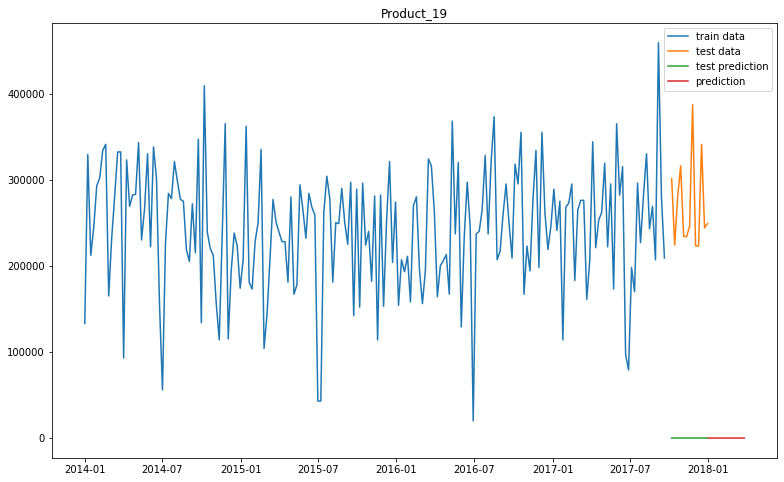

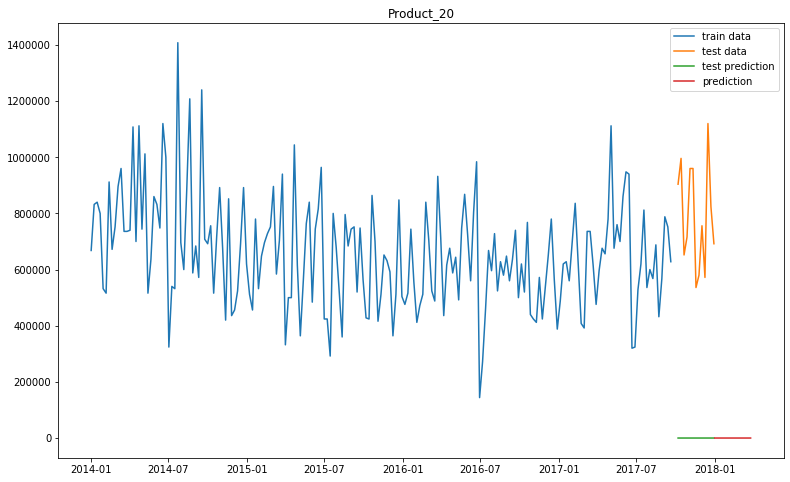

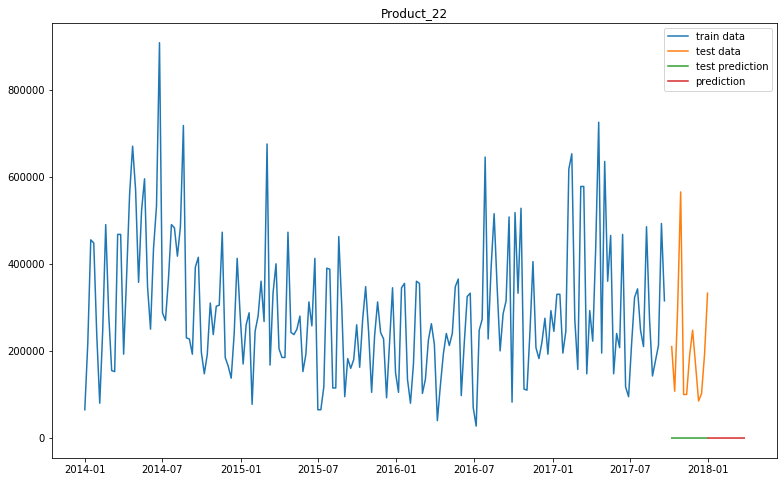

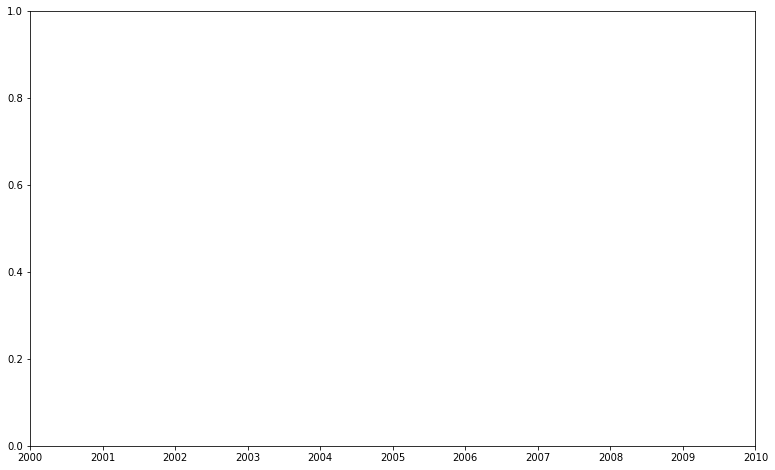

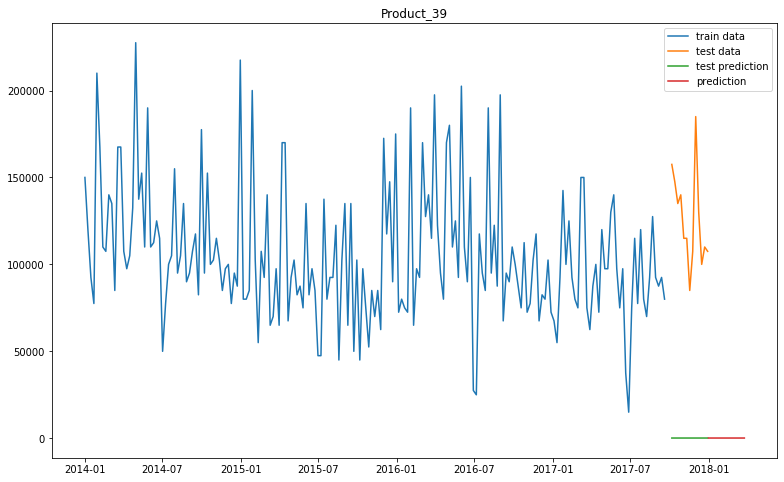

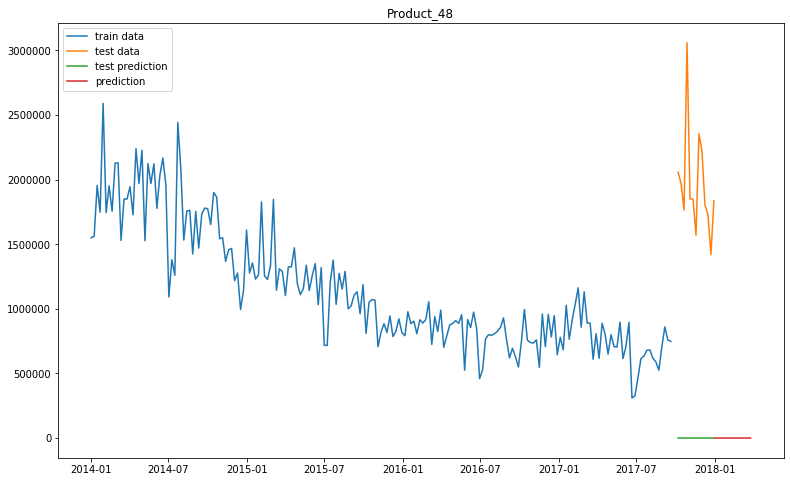

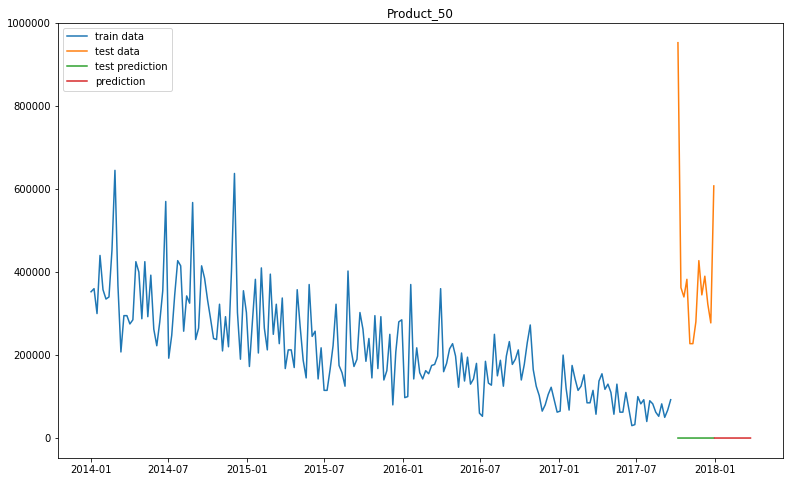

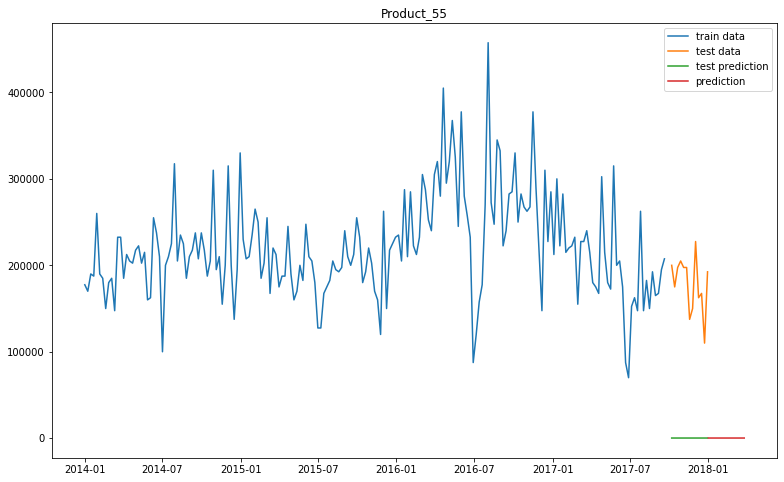

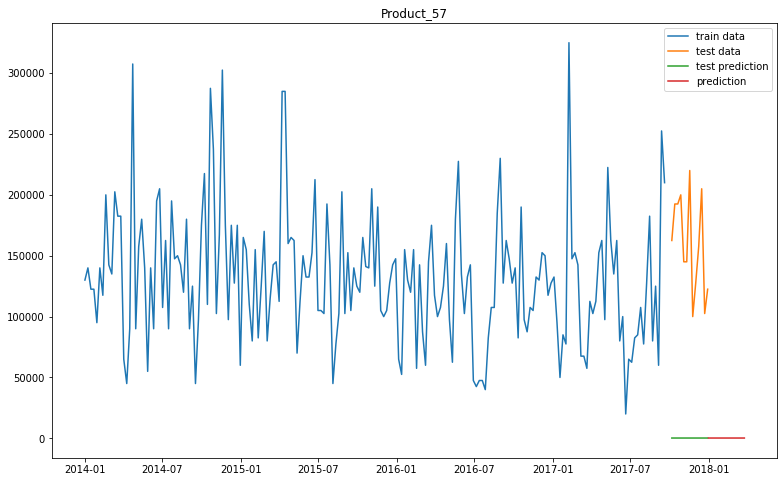

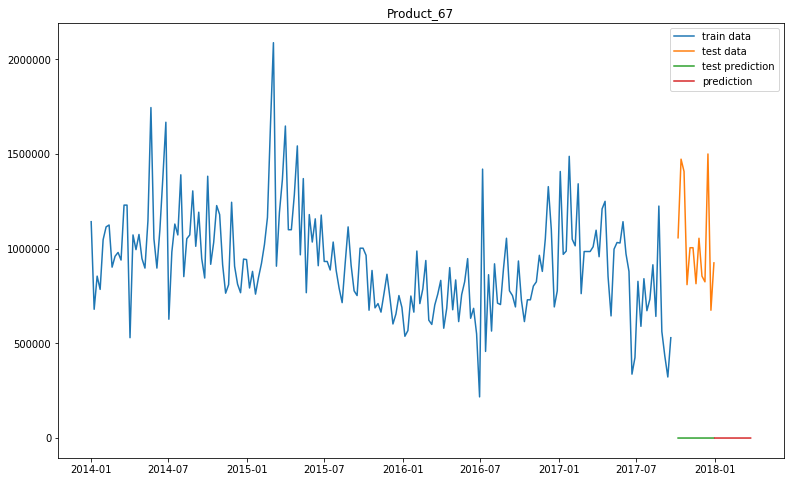

In [23]:
# мусор
# мусор
# мусор

trainer = Trainer(name='medians_nonorm_noretrain', norm=False, retrain=False)
trainer(trains_loaders, tests_loaders, trains, tests, predictions, 0.01, 15)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [80669486746.35997]
Epoch [1/15], Step [20/182], Loss: [70385727264.11624]
Epoch [1/15], Step [30/182], Loss: [76495195949.20396]
Epoch [1/15], Step [40/182], Loss: [28091293591.7141]
Epoch [1/15], Step [50/182], Loss: [5376048803.869065]
Epoch [1/15], Step [60/182], Loss: [13622372672.002146]
Epoch [1/15], Step [70/182], Loss: [7747582658.921564]
Epoch [1/15], Step [80/182], Loss: [5100271281.706463]
Epoch [1/15], Step [90/182], Loss: [4454798759.885332]
Epoch [1/15], Step [100/182], Loss: [5047402106.994327]
Epoch [1/15], Step [110/182], Loss: [5204641043.248465]
Epoch [1/15], Step [120/182], Loss: [8415787707.48217]
Epoch [1/15], Step [130/182], Loss: [12458406244.072966]
Epoch [1/15], Step [140/182], Loss: [4345891123.856806]
Epoch [1/15], Step [150/182], Loss: [6492644947.697201]
Epoch [1/15], Step [160/182], Loss: [4610549636.976462]
Epoch [1/15], Step [170/182], Loss: [5274921047.934501]
Epoch [1/15], Step [180/182], Loss: [5974829236.252034]
E

Epoch [9/15], Step [90/182], Loss: [4275444082.637345]
Epoch [9/15], Step [100/182], Loss: [2904809229.042871]
Epoch [9/15], Step [110/182], Loss: [3103801186.2214847]
Epoch [9/15], Step [120/182], Loss: [6998728780.38643]
Epoch [9/15], Step [130/182], Loss: [6597470482.047964]
Epoch [9/15], Step [140/182], Loss: [3296397371.9522595]
Epoch [9/15], Step [150/182], Loss: [3913537360.583359]
Epoch [9/15], Step [160/182], Loss: [3636137077.0991874]
Epoch [9/15], Step [170/182], Loss: [5107468099.4986515]
Epoch [9/15], Step [180/182], Loss: [5735470770.030933]
Epoch [10/15], Step [10/182], Loss: [4219347979.4334044]
Epoch [10/15], Step [20/182], Loss: [5764887685.401628]
Epoch [10/15], Step [30/182], Loss: [4651635773.444002]
Epoch [10/15], Step [40/182], Loss: [7295232100.688392]
Epoch [10/15], Step [50/182], Loss: [4653531318.863425]
Epoch [10/15], Step [60/182], Loss: [3672693078.911169]
Epoch [10/15], Step [70/182], Loss: [7341740692.300059]
Epoch [10/15], Step [80/182], Loss: [51764832

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [30665682474.46858]
Epoch [1/15], Step [20/182], Loss: [78276808197.47389]
Epoch [1/15], Step [30/182], Loss: [76886182356.00726]
Epoch [1/15], Step [40/182], Loss: [26796426283.916355]
Epoch [1/15], Step [50/182], Loss: [22097800102.892586]
Epoch [1/15], Step [60/182], Loss: [46469653938.4307]
Epoch [1/15], Step [70/182], Loss: [42216178352.72434]
Epoch [1/15], Step [80/182], Loss: [27633238294.611797]
Epoch [1/15], Step [90/182], Loss: [20392037886.384888]
Epoch [1/15], Step [100/182], Loss: [15877865342.494736]
Epoch [1/15], Step [110/182], Loss: [23164813253.378895]
Epoch [1/15], Step [120/182], Loss: [49267523893.02138]
Epoch [1/15], Step [130/182], Loss: [38876136002.198204]
Epoch [1/15], Step [140/182], Loss: [13187198070.882957]
Epoch [1/15], Step [150/182], Loss: [12344637168.783998]
Epoch [1/15], Step [160/182], Loss: [15971173141.649555]
Epoch [1/15], Step [170/182], Loss: [40750730480.97326]
Epoch [1/15], Step [180/182], Loss: [37300006965

Epoch [9/15], Step [50/182], Loss: [19814684399.065277]
Epoch [9/15], Step [60/182], Loss: [43782421451.55634]
Epoch [9/15], Step [70/182], Loss: [41976820016.85937]
Epoch [9/15], Step [80/182], Loss: [27553915061.361668]
Epoch [9/15], Step [90/182], Loss: [20082273005.872475]
Epoch [9/15], Step [100/182], Loss: [16025834645.053154]
Epoch [9/15], Step [110/182], Loss: [23170294708.80644]
Epoch [9/15], Step [120/182], Loss: [48592316050.16039]
Epoch [9/15], Step [130/182], Loss: [39237164930.96144]
Epoch [9/15], Step [140/182], Loss: [13199709363.044304]
Epoch [9/15], Step [150/182], Loss: [12366257605.578577]
Epoch [9/15], Step [160/182], Loss: [16095936306.886343]
Epoch [9/15], Step [170/182], Loss: [40253146098.82219]
Epoch [9/15], Step [180/182], Loss: [37230938885.73208]
Epoch [10/15], Step [10/182], Loss: [30676814330.01182]
Epoch [10/15], Step [20/182], Loss: [78670926322.45377]
Epoch [10/15], Step [30/182], Loss: [78228207752.74574]
Epoch [10/15], Step [40/182], Loss: [270375484

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [28587560592.345737]
Epoch [1/15], Step [20/182], Loss: [28216615708.272964]
Epoch [1/15], Step [30/182], Loss: [30054930496.044212]
Epoch [1/15], Step [40/182], Loss: [10118550416.213417]
Epoch [1/15], Step [50/182], Loss: [20239439490.84719]
Epoch [1/15], Step [60/182], Loss: [19498706350.497444]
Epoch [1/15], Step [70/182], Loss: [11757537408.276642]
Epoch [1/15], Step [80/182], Loss: [15660740855.119202]
Epoch [1/15], Step [90/182], Loss: [5302198047.747218]
Epoch [1/15], Step [100/182], Loss: [10260427138.582958]
Epoch [1/15], Step [110/182], Loss: [8989134724.157295]
Epoch [1/15], Step [120/182], Loss: [11331707837.467003]
Epoch [1/15], Step [130/182], Loss: [24921970317.69582]
Epoch [1/15], Step [140/182], Loss: [22661132943.068428]
Epoch [1/15], Step [150/182], Loss: [4098104201.5169816]
Epoch [1/15], Step [160/182], Loss: [31617486696.2212]
Epoch [1/15], Step [170/182], Loss: [33226089875.65818]
Epoch [1/15], Step [180/182], Loss: [1383360646

Epoch [9/15], Step [70/182], Loss: [11285842168.745739]
Epoch [9/15], Step [80/182], Loss: [15610321379.413427]
Epoch [9/15], Step [90/182], Loss: [5278674913.131631]
Epoch [9/15], Step [100/182], Loss: [10252489723.010752]
Epoch [9/15], Step [110/182], Loss: [8977156942.255272]
Epoch [9/15], Step [120/182], Loss: [11289159114.776829]
Epoch [9/15], Step [130/182], Loss: [24931530447.726723]
Epoch [9/15], Step [140/182], Loss: [22661666734.44145]
Epoch [9/15], Step [150/182], Loss: [4082513838.7955775]
Epoch [9/15], Step [160/182], Loss: [31673736402.15773]
Epoch [9/15], Step [170/182], Loss: [32899930750.249584]
Epoch [9/15], Step [180/182], Loss: [13838289498.087437]
Epoch [10/15], Step [10/182], Loss: [27627624946.57044]
Epoch [10/15], Step [20/182], Loss: [28360210660.493454]
Epoch [10/15], Step [30/182], Loss: [28477869081.16865]
Epoch [10/15], Step [40/182], Loss: [10796813180.602316]
Epoch [10/15], Step [50/182], Loss: [19739141646.356678]
Epoch [10/15], Step [60/182], Loss: [191

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/180], Loss: [7529559873.474144]
Epoch [1/15], Step [20/180], Loss: [11316212649.395529]
Epoch [1/15], Step [30/180], Loss: [5566518624.289125]
Epoch [1/15], Step [40/180], Loss: [2354106292.626505]
Epoch [1/15], Step [50/180], Loss: [4524110787.5295315]
Epoch [1/15], Step [60/180], Loss: [7006590058.458235]
Epoch [1/15], Step [70/180], Loss: [7688344454.031704]
Epoch [1/15], Step [80/180], Loss: [4866990807.710545]
Epoch [1/15], Step [90/180], Loss: [5942204580.229206]
Epoch [1/15], Step [100/180], Loss: [4980808126.798669]
Epoch [1/15], Step [110/180], Loss: [6472743454.955806]
Epoch [1/15], Step [120/180], Loss: [16405363011.556215]
Epoch [1/15], Step [130/180], Loss: [16236746099.06955]
Epoch [1/15], Step [140/180], Loss: [4636291409.054684]
Epoch [1/15], Step [150/180], Loss: [6263534363.448694]
Epoch [1/15], Step [160/180], Loss: [12759794900.646559]
Epoch [1/15], Step [170/180], Loss: [9150485487.168068]
Epoch [1/15], Step [180/180], Loss: [9796527822.58487

Epoch [9/15], Step [70/180], Loss: [7344589916.285097]
Epoch [9/15], Step [80/180], Loss: [4451972737.765885]
Epoch [9/15], Step [90/180], Loss: [5304833945.991671]
Epoch [9/15], Step [100/180], Loss: [4314674199.318625]
Epoch [9/15], Step [110/180], Loss: [6508078172.450947]
Epoch [9/15], Step [120/180], Loss: [16487344487.783867]
Epoch [9/15], Step [130/180], Loss: [16205118124.438461]
Epoch [9/15], Step [140/180], Loss: [4607065830.387991]
Epoch [9/15], Step [150/180], Loss: [6312225898.070346]
Epoch [9/15], Step [160/180], Loss: [12617743070.438814]
Epoch [9/15], Step [170/180], Loss: [9017078446.958815]
Epoch [9/15], Step [180/180], Loss: [9617349720.421722]
Epoch [10/15], Step [10/180], Loss: [7321901536.310992]
Epoch [10/15], Step [20/180], Loss: [11459882447.197632]
Epoch [10/15], Step [30/180], Loss: [5563121093.266032]
Epoch [10/15], Step [40/180], Loss: [2160630133.160531]
Epoch [10/15], Step [50/180], Loss: [4303653551.1906]
Epoch [10/15], Step [60/180], Loss: [6792681300.7

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch [1/15], Step [60/182], Loss: [1283841939.6132565]
Epoch [1/15], Step [70/182], Loss: [670259647.5778077]
Epoch [1/15], Step [80/182], Loss: [1068349198.5739264]
Epoch [1/15], Step [90/182], Loss: [1327272921.6853762]
Epoch [1/15], Step [100/182], Loss: [2029258155.7309017]
Epoch [1/15], Step [110/182], Loss: [1896378810.9398606]
Epoch [1/15], Step [120/182], Loss: [2798663458.5531583]
Epoch [1/15], Step [130/182], Loss: [2612547286.9638643]
Epoch [1/15], Step [140/182], Loss: [1056202652.9419245]
Epoch [1/15], Step [150/182], Loss: [645935082.5715647]
Epoch [1/15], Step [160/182], Loss: [859023079.402005]
Epoch [1/15], Step [170/182], Loss: [712138970.2067786]
Epoch [1/15], Step [180/182], Loss: [917870271.8464471]
Epoch [2/15], Step [10/182], Loss: [1536670051.7932944]
Epoch [2/15], Step [20/182], Loss: [1186668727.5821912]
Epoch [2/15], Step [30/182], Loss: [804351180.9199618]
Epoch [2/15], Step [40/182], Loss: [727394118.8047664]
Epoch [2/15], Step [50/182], Loss: [2167896900

Epoch [9/15], Step [130/182], Loss: [2562024506.5733724]
Epoch [9/15], Step [140/182], Loss: [1115956369.7083433]
Epoch [9/15], Step [150/182], Loss: [554244875.941167]
Epoch [9/15], Step [160/182], Loss: [824847474.7438192]
Epoch [9/15], Step [170/182], Loss: [725179064.5070546]
Epoch [9/15], Step [180/182], Loss: [917198552.6202818]
Epoch [10/15], Step [10/182], Loss: [1559665365.5288696]
Epoch [10/15], Step [20/182], Loss: [1223407241.6507058]
Epoch [10/15], Step [30/182], Loss: [802517003.968185]
Epoch [10/15], Step [40/182], Loss: [727039608.6784213]
Epoch [10/15], Step [50/182], Loss: [2166378002.878142]
Epoch [10/15], Step [60/182], Loss: [1291132192.5152829]
Epoch [10/15], Step [70/182], Loss: [705181032.946595]
Epoch [10/15], Step [80/182], Loss: [1135203070.7561622]
Epoch [10/15], Step [90/182], Loss: [1253793680.4572668]
Epoch [10/15], Step [100/182], Loss: [1981890475.4854257]
Epoch [10/15], Step [110/182], Loss: [1801217977.4251275]
Epoch [10/15], Step [120/182], Loss: [27

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [67604365818.103065]
Epoch [1/15], Step [20/182], Loss: [151472564205.44458]
Epoch [1/15], Step [30/182], Loss: [67264735113.259995]
Epoch [1/15], Step [40/182], Loss: [71258141009.45355]
Epoch [1/15], Step [50/182], Loss: [59789202701.49288]
Epoch [1/15], Step [60/182], Loss: [36287699628.6025]
Epoch [1/15], Step [70/182], Loss: [43444524107.346695]
Epoch [1/15], Step [80/182], Loss: [28283946663.455864]
Epoch [1/15], Step [90/182], Loss: [21107075821.1367]
Epoch [1/15], Step [100/182], Loss: [8704297385.449467]
Epoch [1/15], Step [110/182], Loss: [11725364820.535156]
Epoch [1/15], Step [120/182], Loss: [29802710469.04739]
Epoch [1/15], Step [130/182], Loss: [17078665118.08038]
Epoch [1/15], Step [140/182], Loss: [17111939459.575161]
Epoch [1/15], Step [150/182], Loss: [26543224855.854416]
Epoch [1/15], Step [160/182], Loss: [49019449227.74535]
Epoch [1/15], Step [170/182], Loss: [24759643510.391964]
Epoch [1/15], Step [180/182], Loss: [27721347049.3

Epoch [9/15], Step [50/182], Loss: [64967424365.49167]
Epoch [9/15], Step [60/182], Loss: [36001266375.780426]
Epoch [9/15], Step [70/182], Loss: [43569684009.351074]
Epoch [9/15], Step [80/182], Loss: [26990804472.227123]
Epoch [9/15], Step [90/182], Loss: [21345033669.231464]
Epoch [9/15], Step [100/182], Loss: [7221959971.729062]
Epoch [9/15], Step [110/182], Loss: [10093004275.385765]
Epoch [9/15], Step [120/182], Loss: [29084225822.00683]
Epoch [9/15], Step [130/182], Loss: [17068885797.580318]
Epoch [9/15], Step [140/182], Loss: [17324638898.819675]
Epoch [9/15], Step [150/182], Loss: [27870448926.70474]
Epoch [9/15], Step [160/182], Loss: [51909733776.38028]
Epoch [9/15], Step [170/182], Loss: [24095277206.130062]
Epoch [9/15], Step [180/182], Loss: [30415211918.11721]
Epoch [10/15], Step [10/182], Loss: [54827602764.28583]
Epoch [10/15], Step [20/182], Loss: [152256524103.52438]
Epoch [10/15], Step [30/182], Loss: [68328760419.82047]
Epoch [10/15], Step [40/182], Loss: [7265635

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [4832341372.995395]
Epoch [1/15], Step [20/182], Loss: [10115284884.826984]
Epoch [1/15], Step [30/182], Loss: [8551845066.349129]
Epoch [1/15], Step [40/182], Loss: [15033651884.127092]
Epoch [1/15], Step [50/182], Loss: [6344390626.977265]
Epoch [1/15], Step [60/182], Loss: [5214878342.066785]
Epoch [1/15], Step [70/182], Loss: [6682205779.120799]
Epoch [1/15], Step [80/182], Loss: [8150887109.070593]
Epoch [1/15], Step [90/182], Loss: [4647525545.85701]
Epoch [1/15], Step [100/182], Loss: [6872821507.510924]
Epoch [1/15], Step [110/182], Loss: [3240152552.884963]
Epoch [1/15], Step [120/182], Loss: [3044559336.0905046]
Epoch [1/15], Step [130/182], Loss: [3479861903.6649704]
Epoch [1/15], Step [140/182], Loss: [3212235874.8728375]
Epoch [1/15], Step [150/182], Loss: [2060126022.7149582]
Epoch [1/15], Step [160/182], Loss: [3235047380.3510375]
Epoch [1/15], Step [170/182], Loss: [1546057285.9181805]
Epoch [1/15], Step [180/182], Loss: [701253168.340

Epoch [9/15], Step [40/182], Loss: [12921476480.67458]
Epoch [9/15], Step [50/182], Loss: [6398327260.725724]
Epoch [9/15], Step [60/182], Loss: [5321110959.316259]
Epoch [9/15], Step [70/182], Loss: [6513658986.195883]
Epoch [9/15], Step [80/182], Loss: [6989655358.286793]
Epoch [9/15], Step [90/182], Loss: [4563704773.144601]
Epoch [9/15], Step [100/182], Loss: [6884832390.352093]
Epoch [9/15], Step [110/182], Loss: [2960744590.1727114]
Epoch [9/15], Step [120/182], Loss: [2920399122.0568914]
Epoch [9/15], Step [130/182], Loss: [3197466169.173591]
Epoch [9/15], Step [140/182], Loss: [3025542991.3133125]
Epoch [9/15], Step [150/182], Loss: [2045636572.3227127]
Epoch [9/15], Step [160/182], Loss: [3201526199.9817476]
Epoch [9/15], Step [170/182], Loss: [1439064955.9351141]
Epoch [9/15], Step [180/182], Loss: [624755143.8624982]
Epoch [10/15], Step [10/182], Loss: [4675833407.872846]
Epoch [10/15], Step [20/182], Loss: [10732024519.916649]
Epoch [10/15], Step [30/182], Loss: [8492548772

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [1206596742.5163329]
Epoch [1/15], Step [20/182], Loss: [2448252066.612749]
Epoch [1/15], Step [30/182], Loss: [1041859909.4898862]
Epoch [1/15], Step [40/182], Loss: [2414472986.7105055]
Epoch [1/15], Step [50/182], Loss: [2585530097.405341]
Epoch [1/15], Step [60/182], Loss: [827722481.0451267]
Epoch [1/15], Step [70/182], Loss: [983689888.2337369]
Epoch [1/15], Step [80/182], Loss: [1002927335.2919357]
Epoch [1/15], Step [90/182], Loss: [1571703685.103125]
Epoch [1/15], Step [100/182], Loss: [2070344780.867191]
Epoch [1/15], Step [110/182], Loss: [2404435288.420202]
Epoch [1/15], Step [120/182], Loss: [7968853310.08814]
Epoch [1/15], Step [130/182], Loss: [9060408173.738281]
Epoch [1/15], Step [140/182], Loss: [1654790786.8714054]
Epoch [1/15], Step [150/182], Loss: [3168854932.7213526]
Epoch [1/15], Step [160/182], Loss: [980270431.985051]
Epoch [1/15], Step [170/182], Loss: [3390520644.339949]
Epoch [1/15], Step [180/182], Loss: [2230777117.78090

Epoch [9/15], Step [60/182], Loss: [886945117.0551652]
Epoch [9/15], Step [70/182], Loss: [986798872.998778]
Epoch [9/15], Step [80/182], Loss: [995588682.7624757]
Epoch [9/15], Step [90/182], Loss: [1592907742.128958]
Epoch [9/15], Step [100/182], Loss: [2040445382.3336272]
Epoch [9/15], Step [110/182], Loss: [2676178008.617575]
Epoch [9/15], Step [120/182], Loss: [8025847373.659106]
Epoch [9/15], Step [130/182], Loss: [9086632050.193207]
Epoch [9/15], Step [140/182], Loss: [2616356389.0446243]
Epoch [9/15], Step [150/182], Loss: [3186085202.7458754]
Epoch [9/15], Step [160/182], Loss: [977894302.1422533]
Epoch [9/15], Step [170/182], Loss: [3308138105.8698425]
Epoch [9/15], Step [180/182], Loss: [2177517005.099661]
Epoch [10/15], Step [10/182], Loss: [647213050.9045185]
Epoch [10/15], Step [20/182], Loss: [2629858953.991757]
Epoch [10/15], Step [30/182], Loss: [1998265207.7025516]
Epoch [10/15], Step [40/182], Loss: [2696537726.003686]
Epoch [10/15], Step [50/182], Loss: [2660755613.

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [5348258221.042797]
Epoch [1/15], Step [20/182], Loss: [2083005123.3000603]
Epoch [1/15], Step [30/182], Loss: [2115168775.5411522]
Epoch [1/15], Step [40/182], Loss: [4082960816.7506356]
Epoch [1/15], Step [50/182], Loss: [1739250719.1954584]
Epoch [1/15], Step [60/182], Loss: [4373977884.379664]
Epoch [1/15], Step [70/182], Loss: [1766416316.1145496]
Epoch [1/15], Step [80/182], Loss: [2121231652.342375]
Epoch [1/15], Step [90/182], Loss: [1020185755.7982448]
Epoch [1/15], Step [100/182], Loss: [1899880903.34073]
Epoch [1/15], Step [110/182], Loss: [1546129102.0682178]
Epoch [1/15], Step [120/182], Loss: [2691420239.40263]
Epoch [1/15], Step [130/182], Loss: [3525669489.275704]
Epoch [1/15], Step [140/182], Loss: [1642517733.3572717]
Epoch [1/15], Step [150/182], Loss: [837028944.4633831]
Epoch [1/15], Step [160/182], Loss: [4880517999.080381]
Epoch [1/15], Step [170/182], Loss: [2443065814.009036]
Epoch [1/15], Step [180/182], Loss: [1503917148.870

Epoch [9/15], Step [50/182], Loss: [1597143900.6159394]
Epoch [9/15], Step [60/182], Loss: [3990714788.0725865]
Epoch [9/15], Step [70/182], Loss: [1464050726.2384498]
Epoch [9/15], Step [80/182], Loss: [1759001897.6503072]
Epoch [9/15], Step [90/182], Loss: [1064692184.7872123]
Epoch [9/15], Step [100/182], Loss: [1352433452.914252]
Epoch [9/15], Step [110/182], Loss: [1450057032.4974055]
Epoch [9/15], Step [120/182], Loss: [2555604065.943249]
Epoch [9/15], Step [130/182], Loss: [3534922980.1579685]
Epoch [9/15], Step [140/182], Loss: [1694914850.5651133]
Epoch [9/15], Step [150/182], Loss: [836645708.8533268]
Epoch [9/15], Step [160/182], Loss: [4880849672.45879]
Epoch [9/15], Step [170/182], Loss: [2337025727.5670815]
Epoch [9/15], Step [180/182], Loss: [1430250537.620593]
Epoch [10/15], Step [10/182], Loss: [5119261115.559995]
Epoch [10/15], Step [20/182], Loss: [1980076513.5720327]
Epoch [10/15], Step [30/182], Loss: [2065647117.3956444]
Epoch [10/15], Step [40/182], Loss: [400288

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [86701052013.9994]
Epoch [1/15], Step [20/182], Loss: [93009134692.76006]
Epoch [1/15], Step [30/182], Loss: [31504781771.594513]
Epoch [1/15], Step [40/182], Loss: [40300043766.17856]
Epoch [1/15], Step [50/182], Loss: [141731020045.22522]
Epoch [1/15], Step [60/182], Loss: [119797087966.0287]
Epoch [1/15], Step [70/182], Loss: [60280899885.499466]
Epoch [1/15], Step [80/182], Loss: [18191944698.347313]
Epoch [1/15], Step [90/182], Loss: [20683693409.998505]
Epoch [1/15], Step [100/182], Loss: [13787170482.605734]
Epoch [1/15], Step [110/182], Loss: [16275529437.672773]
Epoch [1/15], Step [120/182], Loss: [72657436384.12276]
Epoch [1/15], Step [130/182], Loss: [82603724037.2065]
Epoch [1/15], Step [140/182], Loss: [13888830195.323393]
Epoch [1/15], Step [150/182], Loss: [53740866268.97486]
Epoch [1/15], Step [160/182], Loss: [31723149596.14793]
Epoch [1/15], Step [170/182], Loss: [60760814242.87121]
Epoch [1/15], Step [180/182], Loss: [53081785889.86

Epoch [9/15], Step [80/182], Loss: [18803312145.933205]
Epoch [9/15], Step [90/182], Loss: [17121354756.100756]
Epoch [9/15], Step [100/182], Loss: [13775093068.117603]
Epoch [9/15], Step [110/182], Loss: [15800369387.823496]
Epoch [9/15], Step [120/182], Loss: [71322107737.74026]
Epoch [9/15], Step [130/182], Loss: [82371419751.46988]
Epoch [9/15], Step [140/182], Loss: [13953546545.21743]
Epoch [9/15], Step [150/182], Loss: [53613253164.7282]
Epoch [9/15], Step [160/182], Loss: [31727531948.50934]
Epoch [9/15], Step [170/182], Loss: [60542801201.31955]
Epoch [9/15], Step [180/182], Loss: [52841839130.23336]
Epoch [10/15], Step [10/182], Loss: [110917036428.41406]
Epoch [10/15], Step [20/182], Loss: [92563649647.55188]
Epoch [10/15], Step [30/182], Loss: [31527878664.511787]
Epoch [10/15], Step [40/182], Loss: [41679273051.962746]
Epoch [10/15], Step [50/182], Loss: [141751721929.31967]
Epoch [10/15], Step [60/182], Loss: [121942952586.03183]
Epoch [10/15], Step [70/182], Loss: [50211

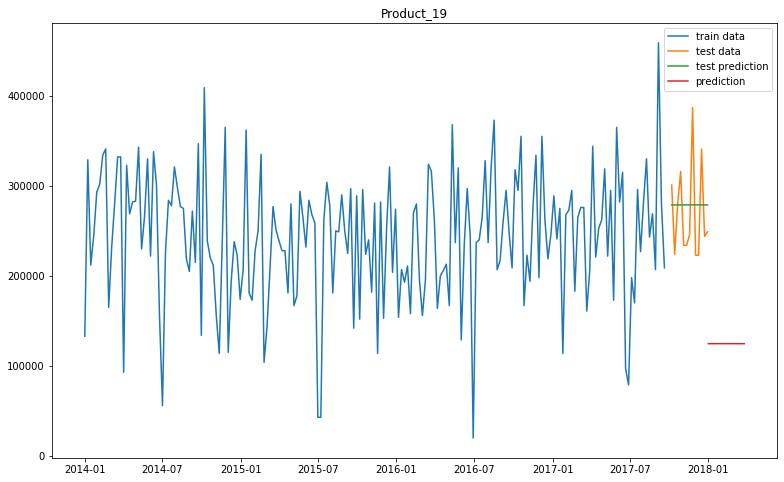

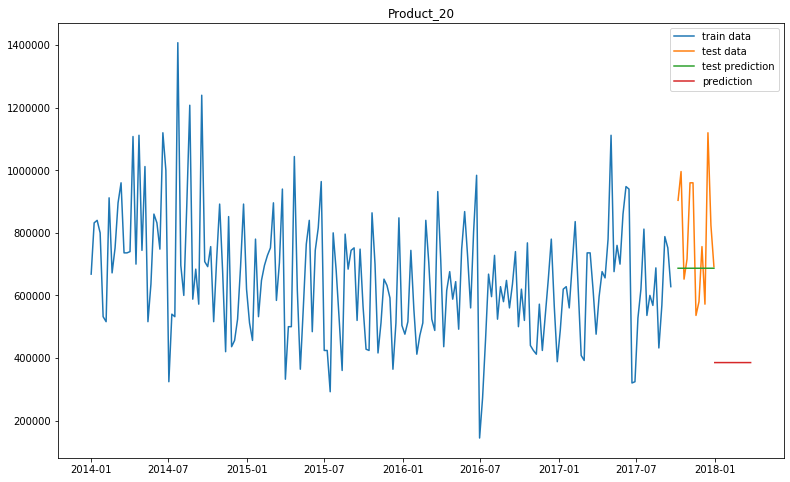

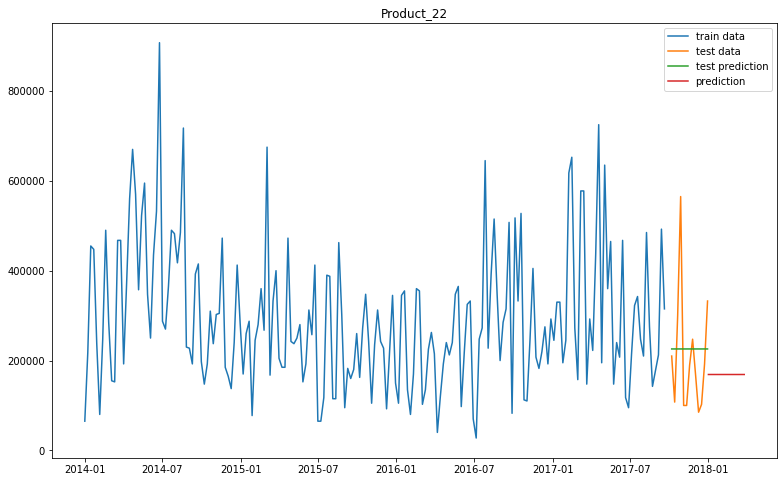

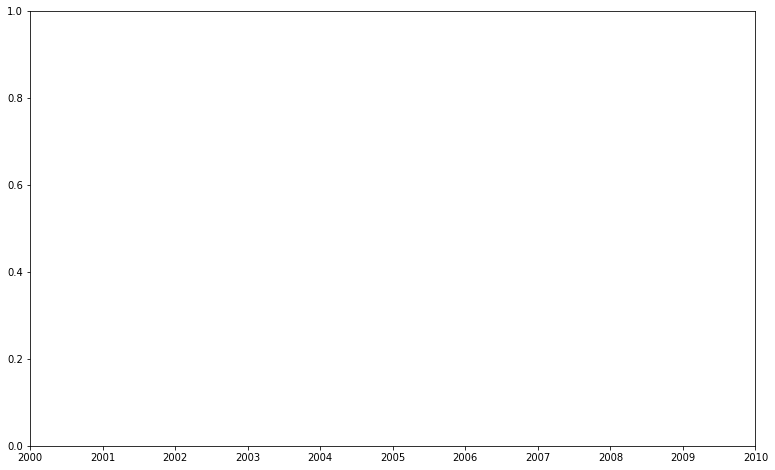

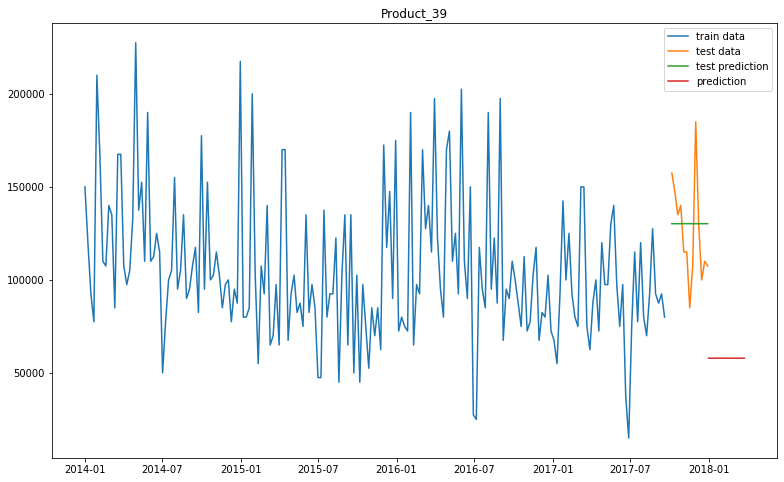

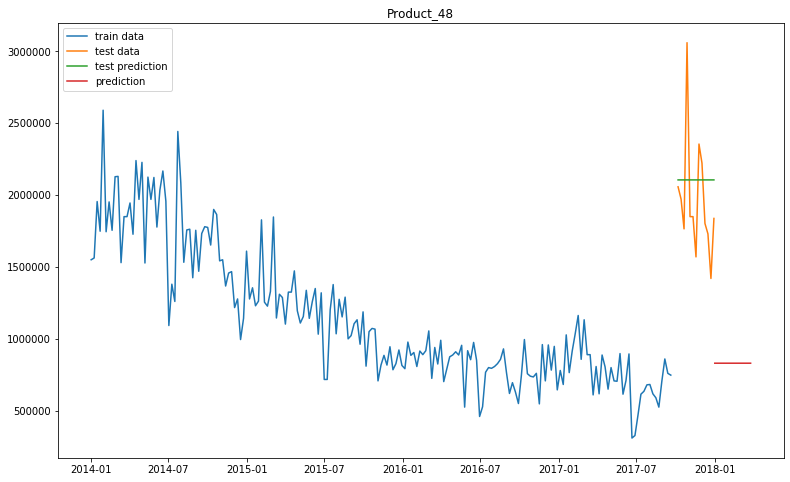

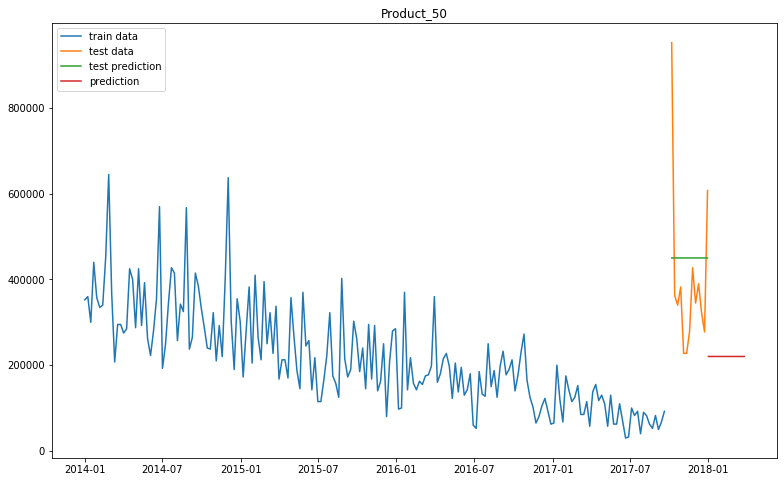

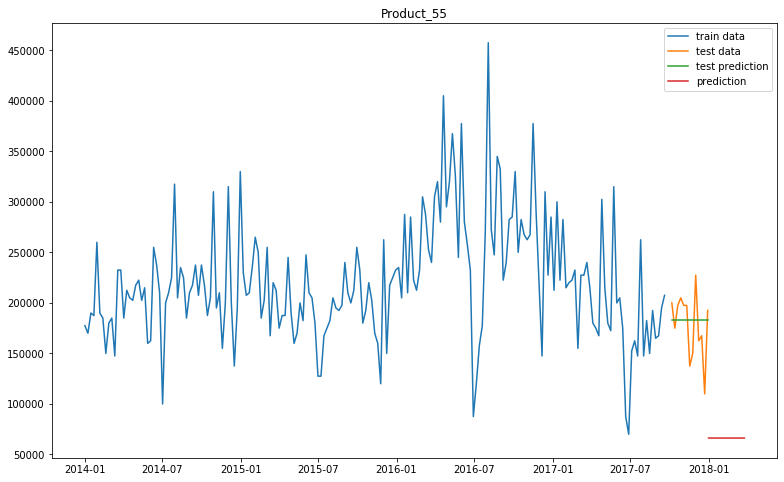

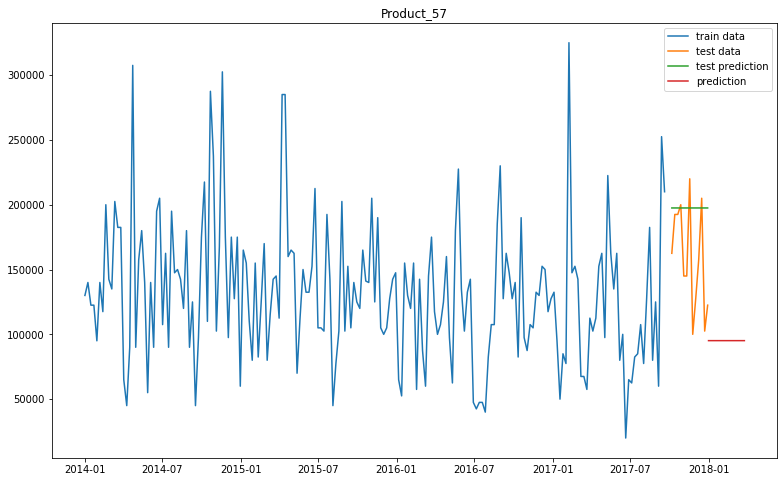

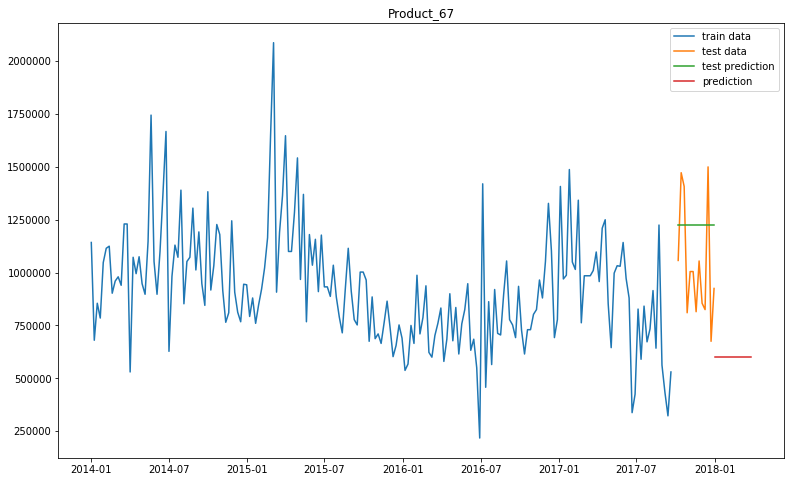

In [50]:
trainer = Trainer(name='mean_NOnorm_NOretrain', norm=False, retrain=False)
trainer(trains_loaders, tests_loaders, trains, tests, predictions, 0.01, 15)

Epoch [1/15], Step [10/182], Loss: [79476128146.13821]
Epoch [1/15], Step [20/182], Loss: [55204505231.305565]
Epoch [1/15], Step [30/182], Loss: [13974815857.765747]
Epoch [1/15], Step [40/182], Loss: [7109185016.364488]
Epoch [1/15], Step [50/182], Loss: [5304042182.668631]

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch [1/15], Step [60/182], Loss: [4861400684.488307]
Epoch [1/15], Step [70/182], Loss: [7455412097.803104]
Epoch [1/15], Step [80/182], Loss: [5719324475.197886]
Epoch [1/15], Step [90/182], Loss: [4644092367.155635]
Epoch [1/15], Step [100/182], Loss: [2925019977.409194]
Epoch [1/15], Step [110/182], Loss: [3115911075.7352157]
Epoch [1/15], Step [120/182], Loss: [7055134691.613775]
Epoch [1/15], Step [130/182], Loss: [6529881336.466037]
Epoch [1/15], Step [140/182], Loss: [3136258162.6418967]
Epoch [1/15], Step [150/182], Loss: [3724350610.1406064]
Epoch [1/15], Step [160/182], Loss: [4022241377.5932817]
Epoch [1/15], Step [170/182], Loss: [5108351021.483097]
Epoch [1/15], Step [180/182], Loss: [5763797618.69342]
Epoch [2/15], Step [10/182], Loss: [5577842661.442369]
Epoch [2/15], Step [20/182], Loss: [6135410453.966137]
Epoch [2/15], Step [30/182], Loss: [5198092452.685603]
Epoch [2/15], Step [40/182], Loss: [7098758180.626917]
Epoch [2/15], Step [50/182], Loss: [4671141607.49784

Epoch [9/15], Step [100/182], Loss: [2914643757.09736]
Epoch [9/15], Step [110/182], Loss: [3105346842.689407]
Epoch [9/15], Step [120/182], Loss: [6998584426.323856]
Epoch [9/15], Step [130/182], Loss: [6590982728.618467]
Epoch [9/15], Step [140/182], Loss: [3282510937.162049]
Epoch [9/15], Step [150/182], Loss: [3885481916.8217525]
Epoch [9/15], Step [160/182], Loss: [3635276799.904721]
Epoch [9/15], Step [170/182], Loss: [5104223875.227839]
Epoch [9/15], Step [180/182], Loss: [5736028420.576]
Epoch [10/15], Step [10/182], Loss: [4213858324.25063]
Epoch [10/15], Step [20/182], Loss: [5772943567.512167]
Epoch [10/15], Step [30/182], Loss: [4620344524.194269]
Epoch [10/15], Step [40/182], Loss: [7275056397.66163]
Epoch [10/15], Step [50/182], Loss: [4653329887.240588]
Epoch [10/15], Step [60/182], Loss: [3678479530.1542225]
Epoch [10/15], Step [70/182], Loss: [7342291664.034837]
Epoch [10/15], Step [80/182], Loss: [5186557543.604579]
Epoch [10/15], Step [90/182], Loss: [4244469684.5389

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [715203566145.6296]
Epoch [1/15], Step [20/182], Loss: [636665738762.2012]
Epoch [1/15], Step [30/182], Loss: [471599963939.6331]
Epoch [1/15], Step [40/182], Loss: [180767288527.3295]
Epoch [1/15], Step [50/182], Loss: [20571812447.271763]
Epoch [1/15], Step [60/182], Loss: [53878596784.51809]
Epoch [1/15], Step [70/182], Loss: [45751028317.69689]
Epoch [1/15], Step [80/182], Loss: [34092762605.217594]
Epoch [1/15], Step [90/182], Loss: [39178490372.89613]
Epoch [1/15], Step [100/182], Loss: [18963685779.03436]
Epoch [1/15], Step [110/182], Loss: [30799893514.817474]
Epoch [1/15], Step [120/182], Loss: [48588873586.20596]
Epoch [1/15], Step [130/182], Loss: [40180479555.292755]
Epoch [1/15], Step [140/182], Loss: [13625119680.2095]
Epoch [1/15], Step [150/182], Loss: [13303354929.372894]
Epoch [1/15], Step [160/182], Loss: [15813543796.878801]
Epoch [1/15], Step [170/182], Loss: [97215776422.70879]
Epoch [1/15], Step [180/182], Loss: [48766090357.737

Epoch [9/15], Step [50/182], Loss: [21961067509.21036]
Epoch [9/15], Step [60/182], Loss: [47615364766.255135]
Epoch [9/15], Step [70/182], Loss: [44185144811.63825]
Epoch [9/15], Step [80/182], Loss: [27814229246.638145]
Epoch [9/15], Step [90/182], Loss: [22506711719.049286]
Epoch [9/15], Step [100/182], Loss: [18353028546.40829]
Epoch [9/15], Step [110/182], Loss: [24518007260.755795]
Epoch [9/15], Step [120/182], Loss: [48246056360.70449]
Epoch [9/15], Step [130/182], Loss: [39179095045.7019]
Epoch [9/15], Step [140/182], Loss: [13220725017.44394]
Epoch [9/15], Step [150/182], Loss: [12741113880.093979]
Epoch [9/15], Step [160/182], Loss: [16292688978.891813]
Epoch [9/15], Step [170/182], Loss: [40511899889.16238]
Epoch [9/15], Step [180/182], Loss: [37299229559.44974]
Epoch [10/15], Step [10/182], Loss: [31809585319.41588]
Epoch [10/15], Step [20/182], Loss: [78467596296.86472]
Epoch [10/15], Step [30/182], Loss: [76893416157.46916]
Epoch [10/15], Step [40/182], Loss: [26799220216

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [201784445201.8765]
Epoch [1/15], Step [20/182], Loss: [234047315845.46976]
Epoch [1/15], Step [30/182], Loss: [151004035269.62192]
Epoch [1/15], Step [40/182], Loss: [74324742647.838]
Epoch [1/15], Step [50/182], Loss: [100525628193.52895]
Epoch [1/15], Step [60/182], Loss: [112833246192.60309]
Epoch [1/15], Step [70/182], Loss: [63453504111.31706]
Epoch [1/15], Step [80/182], Loss: [63082814351.446396]
Epoch [1/15], Step [90/182], Loss: [52988070075.53848]
Epoch [1/15], Step [100/182], Loss: [57472655950.66191]
Epoch [1/15], Step [110/182], Loss: [45851042272.77154]
Epoch [1/15], Step [120/182], Loss: [57264426925.73541]
Epoch [1/15], Step [130/182], Loss: [113844963044.41496]
Epoch [1/15], Step [140/182], Loss: [110252603900.76212]
Epoch [1/15], Step [150/182], Loss: [70993513549.36845]
Epoch [1/15], Step [160/182], Loss: [163715267055.60004]
Epoch [1/15], Step [170/182], Loss: [153379178155.36603]
Epoch [1/15], Step [180/182], Loss: [78460668603.1

Epoch [9/15], Step [50/182], Loss: [100517659112.54256]
Epoch [9/15], Step [60/182], Loss: [112824654178.5683]
Epoch [9/15], Step [70/182], Loss: [63447076629.19413]
Epoch [9/15], Step [80/182], Loss: [63076691507.13874]
Epoch [9/15], Step [90/182], Loss: [52981928999.10578]
Epoch [9/15], Step [100/182], Loss: [57466546189.089615]
Epoch [9/15], Step [110/182], Loss: [45845640511.74858]
Epoch [9/15], Step [120/182], Loss: [57258398234.14759]
Epoch [9/15], Step [130/182], Loss: [113836577997.1124]
Epoch [9/15], Step [140/182], Loss: [110244284901.29729]
Epoch [9/15], Step [150/182], Loss: [70986238767.1266]
Epoch [9/15], Step [160/182], Loss: [163705053389.95288]
Epoch [9/15], Step [170/182], Loss: [153369424177.87912]
Epoch [9/15], Step [180/182], Loss: [78453524546.09929]
Epoch [10/15], Step [10/182], Loss: [201771346613.06305]
Epoch [10/15], Step [20/182], Loss: [234033058013.93292]
Epoch [10/15], Step [30/182], Loss: [150992929573.2499]
Epoch [10/15], Step [40/182], Loss: [7431672745

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/180], Loss: [243596031274.8766]
Epoch [1/15], Step [20/180], Loss: [207844925214.5868]
Epoch [1/15], Step [30/180], Loss: [177149496630.541]
Epoch [1/15], Step [40/180], Loss: [130606879192.37276]
Epoch [1/15], Step [50/180], Loss: [161291933364.2942]
Epoch [1/15], Step [60/180], Loss: [199828001874.79013]
Epoch [1/15], Step [70/180], Loss: [149017491681.79373]
Epoch [1/15], Step [80/180], Loss: [146659446907.0974]
Epoch [1/15], Step [90/180], Loss: [176029418837.34375]
Epoch [1/15], Step [100/180], Loss: [158462673388.46677]
Epoch [1/15], Step [110/180], Loss: [194676293857.03802]
Epoch [1/15], Step [120/180], Loss: [182486030906.42688]
Epoch [1/15], Step [130/180], Loss: [160619815849.81894]
Epoch [1/15], Step [140/180], Loss: [200531381784.87723]
Epoch [1/15], Step [150/180], Loss: [205955824041.3972]
Epoch [1/15], Step [160/180], Loss: [265967694272.28015]
Epoch [1/15], Step [170/180], Loss: [212635479523.1213]
Epoch [1/15], Step [180/180], Loss: [14560031604

Epoch [9/15], Step [30/180], Loss: [114490655639.84923]
Epoch [9/15], Step [40/180], Loss: [76508397942.62405]
Epoch [9/15], Step [50/180], Loss: [127579183190.23354]
Epoch [9/15], Step [60/180], Loss: [129899148649.39694]
Epoch [9/15], Step [70/180], Loss: [89291735887.88171]
Epoch [9/15], Step [80/180], Loss: [86079870350.34839]
Epoch [9/15], Step [90/180], Loss: [138730269273.11935]
Epoch [9/15], Step [100/180], Loss: [139199598547.00153]
Epoch [9/15], Step [110/180], Loss: [154402818214.2806]
Epoch [9/15], Step [120/180], Loss: [113098583699.5476]
Epoch [9/15], Step [130/180], Loss: [95719392913.0357]
Epoch [9/15], Step [140/180], Loss: [157594600210.6144]
Epoch [9/15], Step [150/180], Loss: [125748551919.20801]
Epoch [9/15], Step [160/180], Loss: [172965478155.83762]
Epoch [9/15], Step [170/180], Loss: [129028505907.43697]
Epoch [9/15], Step [180/180], Loss: [78262513583.31335]
Epoch [10/15], Step [10/180], Loss: [150106960598.3413]
Epoch [10/15], Step [20/180], Loss: [16079977872

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch [1/15], Step [20/182], Loss: [9149865343.338285]
Epoch [1/15], Step [30/182], Loss: [4322116507.700882]
Epoch [1/15], Step [40/182], Loss: [1278259396.8710902]
Epoch [1/15], Step [50/182], Loss: [2323017848.009831]
Epoch [1/15], Step [60/182], Loss: [3664662024.5658355]
Epoch [1/15], Step [70/182], Loss: [805477651.4254516]
Epoch [1/15], Step [80/182], Loss: [1130737557.0484877]
Epoch [1/15], Step [90/182], Loss: [1474089725.1288352]
Epoch [1/15], Step [100/182], Loss: [2609794417.5995183]
Epoch [1/15], Step [110/182], Loss: [1980310440.0189824]
Epoch [1/15], Step [120/182], Loss: [3076602687.677848]
Epoch [1/15], Step [130/182], Loss: [4013407863.559384]
Epoch [1/15], Step [140/182], Loss: [1060543894.8450223]
Epoch [1/15], Step [150/182], Loss: [526050775.18922895]
Epoch [1/15], Step [160/182], Loss: [834173111.7077167]
Epoch [1/15], Step [170/182], Loss: [992805299.6054753]
Epoch [1/15], Step [180/182], Loss: [912594851.5755222]
Epoch [2/15], Step [10/182], Loss: [1792240807.

Epoch [9/15], Step [70/182], Loss: [665185393.8635151]
Epoch [9/15], Step [80/182], Loss: [1092563593.3802278]
Epoch [9/15], Step [90/182], Loss: [1251287351.6286695]
Epoch [9/15], Step [100/182], Loss: [2003696247.2088056]
Epoch [9/15], Step [110/182], Loss: [1728359429.7501462]
Epoch [9/15], Step [120/182], Loss: [2824903189.155579]
Epoch [9/15], Step [130/182], Loss: [2578790980.2787175]
Epoch [9/15], Step [140/182], Loss: [1037663421.1948843]
Epoch [9/15], Step [150/182], Loss: [573387437.3406147]
Epoch [9/15], Step [160/182], Loss: [854175548.1154839]
Epoch [9/15], Step [170/182], Loss: [720849747.1817262]
Epoch [9/15], Step [180/182], Loss: [940551052.685125]
Epoch [10/15], Step [10/182], Loss: [1547214328.5633845]
Epoch [10/15], Step [20/182], Loss: [1192731930.2880952]
Epoch [10/15], Step [30/182], Loss: [826580065.9825678]
Epoch [10/15], Step [40/182], Loss: [719698141.8143009]
Epoch [10/15], Step [50/182], Loss: [2166041193.2932644]
Epoch [10/15], Step [60/182], Loss: [125492

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [3748926352066.7812]
Epoch [1/15], Step [20/182], Loss: [2805257976801.3994]
Epoch [1/15], Step [30/182], Loss: [814470392603.701]
Epoch [1/15], Step [40/182], Loss: [333845050655.9144]
Epoch [1/15], Step [50/182], Loss: [59170495350.315155]
Epoch [1/15], Step [60/182], Loss: [39996193287.46442]
Epoch [1/15], Step [70/182], Loss: [43950359685.36912]
Epoch [1/15], Step [80/182], Loss: [228940417554.60938]
Epoch [1/15], Step [90/182], Loss: [47878895263.96988]
Epoch [1/15], Step [100/182], Loss: [38219814496.58252]
Epoch [1/15], Step [110/182], Loss: [42257380485.30463]
Epoch [1/15], Step [120/182], Loss: [34262142139.587624]
Epoch [1/15], Step [130/182], Loss: [21956250938.877003]
Epoch [1/15], Step [140/182], Loss: [64693464017.52218]
Epoch [1/15], Step [150/182], Loss: [34257486105.99325]
Epoch [1/15], Step [160/182], Loss: [28983251176.340588]
Epoch [1/15], Step [170/182], Loss: [43300829129.36407]
Epoch [1/15], Step [180/182], Loss: [34246546167.48

Epoch [9/15], Step [60/182], Loss: [36085571857.57104]
Epoch [9/15], Step [70/182], Loss: [46952627151.57025]
Epoch [9/15], Step [80/182], Loss: [28684415099.073284]
Epoch [9/15], Step [90/182], Loss: [26277904175.060627]
Epoch [9/15], Step [100/182], Loss: [12045233524.043121]
Epoch [9/15], Step [110/182], Loss: [10041923518.574656]
Epoch [9/15], Step [120/182], Loss: [30943773357.673252]
Epoch [9/15], Step [130/182], Loss: [17067280368.597488]
Epoch [9/15], Step [140/182], Loss: [17967359533.62893]
Epoch [9/15], Step [150/182], Loss: [39359364107.92858]
Epoch [9/15], Step [160/182], Loss: [27222620366.67904]
Epoch [9/15], Step [170/182], Loss: [41849035831.52712]
Epoch [9/15], Step [180/182], Loss: [23884939371.956326]
Epoch [10/15], Step [10/182], Loss: [84290300154.9933]
Epoch [10/15], Step [20/182], Loss: [157820453780.29416]
Epoch [10/15], Step [30/182], Loss: [70045078119.33624]
Epoch [10/15], Step [40/182], Loss: [71725190790.77895]
Epoch [10/15], Step [50/182], Loss: [59549675

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [109341249131.2227]
Epoch [1/15], Step [20/182], Loss: [117382529644.47885]
Epoch [1/15], Step [30/182], Loss: [128012740595.7052]
Epoch [1/15], Step [40/182], Loss: [108563185408.31128]
Epoch [1/15], Step [50/182], Loss: [87971324836.9391]
Epoch [1/15], Step [60/182], Loss: [70394868849.81677]
Epoch [1/15], Step [70/182], Loss: [53043439741.03042]
Epoch [1/15], Step [80/182], Loss: [53808788972.6343]
Epoch [1/15], Step [90/182], Loss: [48069348705.31161]
Epoch [1/15], Step [100/182], Loss: [43624157217.04205]
Epoch [1/15], Step [110/182], Loss: [40735662696.802826]
Epoch [1/15], Step [120/182], Loss: [27639081020.208157]
Epoch [1/15], Step [130/182], Loss: [28241461986.487823]
Epoch [1/15], Step [140/182], Loss: [33974090603.840027]
Epoch [1/15], Step [150/182], Loss: [13004054056.64332]
Epoch [1/15], Step [160/182], Loss: [15069396255.115952]
Epoch [1/15], Step [170/182], Loss: [10381468139.740337]
Epoch [1/15], Step [180/182], Loss: [5714699557.549

Epoch [9/15], Step [30/182], Loss: [128003739944.1747]
Epoch [9/15], Step [40/182], Loss: [108555094760.47458]
Epoch [9/15], Step [50/182], Loss: [87963829311.47472]
Epoch [9/15], Step [60/182], Loss: [70388165885.22725]
Epoch [9/15], Step [70/182], Loss: [53037759111.00509]
Epoch [9/15], Step [80/182], Loss: [53803058276.21285]
Epoch [9/15], Step [90/182], Loss: [48063843303.92895]
Epoch [9/15], Step [100/182], Loss: [43619092132.08765]
Epoch [9/15], Step [110/182], Loss: [40730521289.007416]
Epoch [9/15], Step [120/182], Loss: [27634917567.908215]
Epoch [9/15], Step [130/182], Loss: [28237270337.915867]
Epoch [9/15], Step [140/182], Loss: [33969427915.524895]
Epoch [9/15], Step [150/182], Loss: [13001234945.325012]
Epoch [9/15], Step [160/182], Loss: [15066270458.839901]
Epoch [9/15], Step [170/182], Loss: [10378959012.614302]
Epoch [9/15], Step [180/182], Loss: [5712807459.521109]
Epoch [10/15], Step [10/182], Loss: [109331773885.71735]
Epoch [10/15], Step [20/182], Loss: [117372926

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [41242262631.65444]
Epoch [1/15], Step [20/182], Loss: [45563274777.88371]
Epoch [1/15], Step [30/182], Loss: [46688319357.54481]
Epoch [1/15], Step [40/182], Loss: [5076510966.961321]
Epoch [1/15], Step [50/182], Loss: [5953221763.606307]
Epoch [1/15], Step [60/182], Loss: [1283299205.1979132]
Epoch [1/15], Step [70/182], Loss: [1079282973.9779894]
Epoch [1/15], Step [80/182], Loss: [946494181.7151318]
Epoch [1/15], Step [90/182], Loss: [15938636578.891012]
Epoch [1/15], Step [100/182], Loss: [2146899505.7584999]
Epoch [1/15], Step [110/182], Loss: [2483142879.563457]
Epoch [1/15], Step [120/182], Loss: [9092725681.440048]
Epoch [1/15], Step [130/182], Loss: [9083173103.819386]
Epoch [1/15], Step [140/182], Loss: [1657229713.8865209]
Epoch [1/15], Step [150/182], Loss: [3881612166.496793]
Epoch [1/15], Step [160/182], Loss: [1136637072.9466133]
Epoch [1/15], Step [170/182], Loss: [3192688374.3377404]
Epoch [1/15], Step [180/182], Loss: [2639351330.76

Epoch [9/15], Step [30/182], Loss: [1283468616.8088605]
Epoch [9/15], Step [40/182], Loss: [2547250559.0986843]
Epoch [9/15], Step [50/182], Loss: [2928229539.46726]
Epoch [9/15], Step [60/182], Loss: [834363656.7933536]
Epoch [9/15], Step [70/182], Loss: [988385896.0217334]
Epoch [9/15], Step [80/182], Loss: [1070978139.4564263]
Epoch [9/15], Step [90/182], Loss: [1604208674.3743372]
Epoch [9/15], Step [100/182], Loss: [2055001266.3192537]
Epoch [9/15], Step [110/182], Loss: [2455962010.6599946]
Epoch [9/15], Step [120/182], Loss: [8188400539.742525]
Epoch [9/15], Step [130/182], Loss: [9505339221.21298]
Epoch [9/15], Step [140/182], Loss: [1626918390.347114]
Epoch [9/15], Step [150/182], Loss: [3167226280.213763]
Epoch [9/15], Step [160/182], Loss: [982736449.3359017]
Epoch [9/15], Step [170/182], Loss: [3220018073.8533373]
Epoch [9/15], Step [180/182], Loss: [2379546852.649529]
Epoch [10/15], Step [10/182], Loss: [629121696.2851304]
Epoch [10/15], Step [20/182], Loss: [2474535769.40

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [24821579557.901943]
Epoch [1/15], Step [20/182], Loss: [22393592268.887268]
Epoch [1/15], Step [30/182], Loss: [21128582009.135384]
Epoch [1/15], Step [40/182], Loss: [36676285161.093475]
Epoch [1/15], Step [50/182], Loss: [17892671874.10732]
Epoch [1/15], Step [60/182], Loss: [28054026512.14111]
Epoch [1/15], Step [70/182], Loss: [20523404852.115517]
Epoch [1/15], Step [80/182], Loss: [16801881653.245657]
Epoch [1/15], Step [90/182], Loss: [19472935008.61044]
Epoch [1/15], Step [100/182], Loss: [13843492294.88503]
Epoch [1/15], Step [110/182], Loss: [15501342440.291067]
Epoch [1/15], Step [120/182], Loss: [16994996609.614252]
Epoch [1/15], Step [130/182], Loss: [14623821341.995369]
Epoch [1/15], Step [140/182], Loss: [19484744989.403755]
Epoch [1/15], Step [150/182], Loss: [13464969551.503716]
Epoch [1/15], Step [160/182], Loss: [18058203913.832573]
Epoch [1/15], Step [170/182], Loss: [17856080870.099712]
Epoch [1/15], Step [180/182], Loss: [9846294

Epoch [9/15], Step [50/182], Loss: [17742136342.862663]
Epoch [9/15], Step [60/182], Loss: [22002580690.35705]
Epoch [9/15], Step [70/182], Loss: [10858531847.12207]
Epoch [9/15], Step [80/182], Loss: [8273708577.383623]
Epoch [9/15], Step [90/182], Loss: [19307185322.606228]
Epoch [9/15], Step [100/182], Loss: [5984676386.889397]
Epoch [9/15], Step [110/182], Loss: [6945892505.02978]
Epoch [9/15], Step [120/182], Loss: [11973746120.88119]
Epoch [9/15], Step [130/182], Loss: [14494012701.896559]
Epoch [9/15], Step [140/182], Loss: [9351367566.430208]
Epoch [9/15], Step [150/182], Loss: [5177325555.410818]
Epoch [9/15], Step [160/182], Loss: [13061277275.47998]
Epoch [9/15], Step [170/182], Loss: [8213842875.58495]
Epoch [9/15], Step [180/182], Loss: [3286025080.52951]
Epoch [10/15], Step [10/182], Loss: [13354912055.920115]
Epoch [10/15], Step [20/182], Loss: [10643924788.382206]
Epoch [10/15], Step [30/182], Loss: [9684508922.439028]
Epoch [10/15], Step [40/182], Loss: [20709540877.63

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [1201492389308.7263]
Epoch [1/15], Step [20/182], Loss: [1431397680387.576]
Epoch [1/15], Step [30/182], Loss: [1203714964409.6348]
Epoch [1/15], Step [40/182], Loss: [1024051438203.9281]
Epoch [1/15], Step [50/182], Loss: [1234959167386.7998]
Epoch [1/15], Step [60/182], Loss: [1885362831748.8699]
Epoch [1/15], Step [70/182], Loss: [1184406163967.3743]
Epoch [1/15], Step [80/182], Loss: [826920522793.5444]
Epoch [1/15], Step [90/182], Loss: [646575288129.2787]
Epoch [1/15], Step [100/182], Loss: [526555476724.4353]
Epoch [1/15], Step [110/182], Loss: [581885074050.323]
Epoch [1/15], Step [120/182], Loss: [630863488179.3523]
Epoch [1/15], Step [130/182], Loss: [659567949721.2373]
Epoch [1/15], Step [140/182], Loss: [664685880502.2141]
Epoch [1/15], Step [150/182], Loss: [1135986019740.267]
Epoch [1/15], Step [160/182], Loss: [1170776419489.9404]
Epoch [1/15], Step [170/182], Loss: [965513171557.4867]
Epoch [1/15], Step [180/182], Loss: [600975963348.2

Epoch [9/15], Step [70/182], Loss: [1180654379422.337]
Epoch [9/15], Step [80/182], Loss: [823334255697.0321]
Epoch [9/15], Step [90/182], Loss: [643701925101.415]
Epoch [9/15], Step [100/182], Loss: [523628189887.1527]
Epoch [9/15], Step [110/182], Loss: [578772128348.2673]
Epoch [9/15], Step [120/182], Loss: [627724756833.0198]
Epoch [9/15], Step [130/182], Loss: [656346754318.3503]
Epoch [9/15], Step [140/182], Loss: [661230993426.6122]
Epoch [9/15], Step [150/182], Loss: [1131477003445.3206]
Epoch [9/15], Step [160/182], Loss: [1166090190874.003]
Epoch [9/15], Step [170/182], Loss: [961712814272.8541]
Epoch [9/15], Step [180/182], Loss: [600033809179.4038]
Epoch [10/15], Step [10/182], Loss: [1197094104078.2002]
Epoch [10/15], Step [20/182], Loss: [1425978807445.2139]
Epoch [10/15], Step [30/182], Loss: [1198560576797.286]
Epoch [10/15], Step [40/182], Loss: [1019252031861.1261]
Epoch [10/15], Step [50/182], Loss: [1229835638882.5195]
Epoch [10/15], Step [60/182], Loss: [1879427723

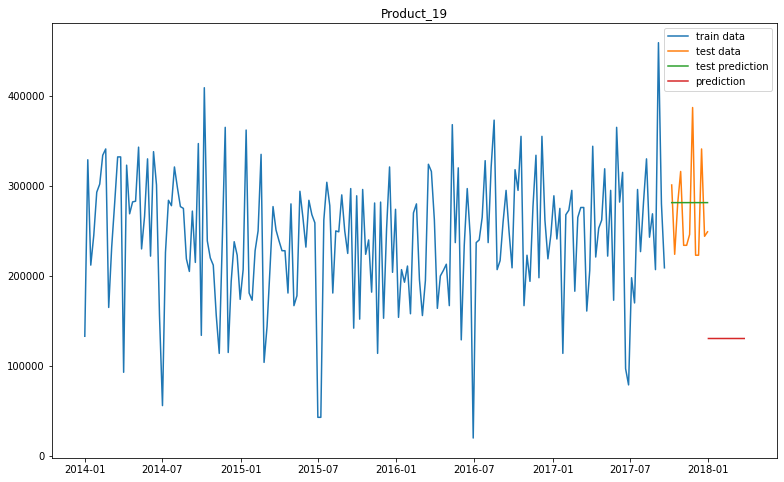

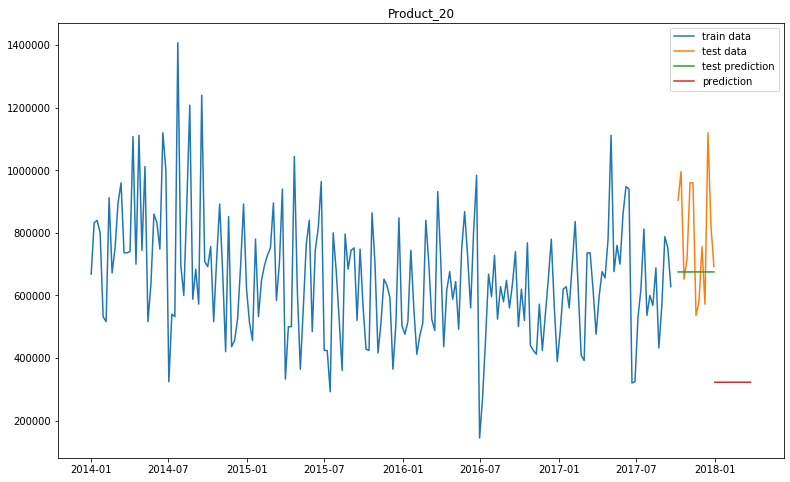

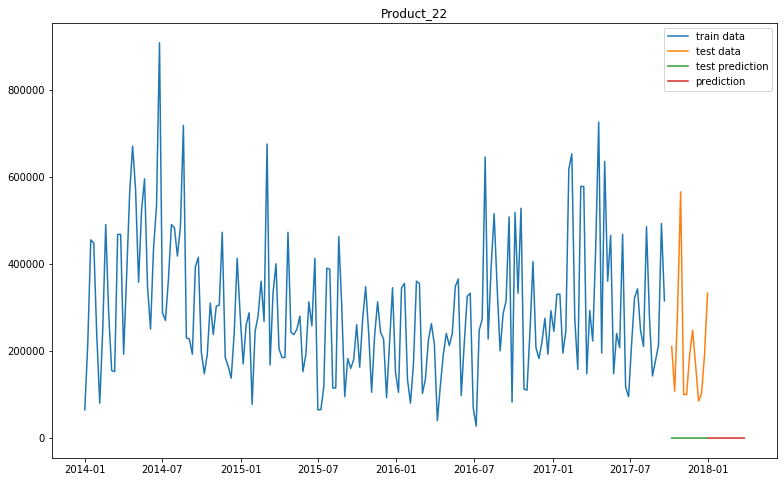

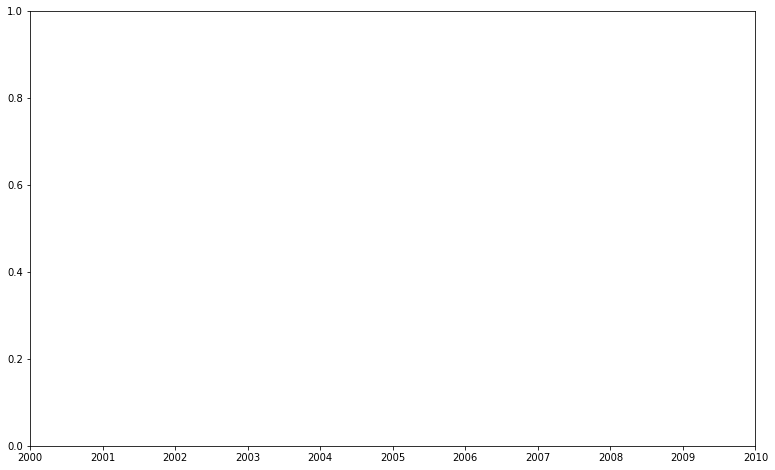

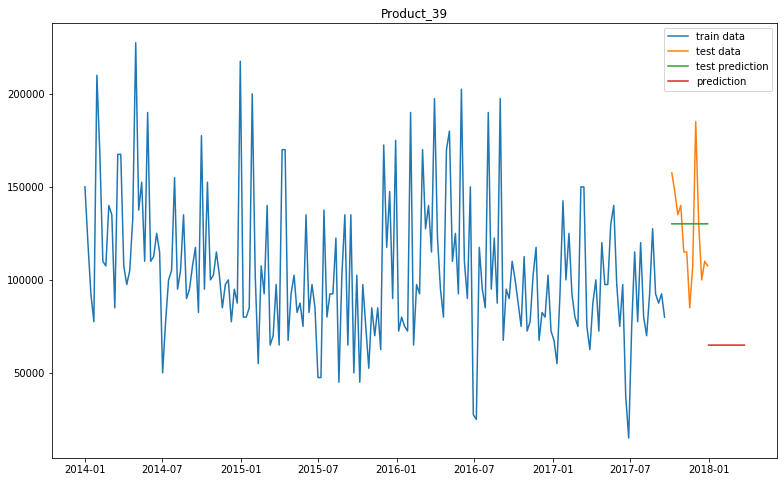

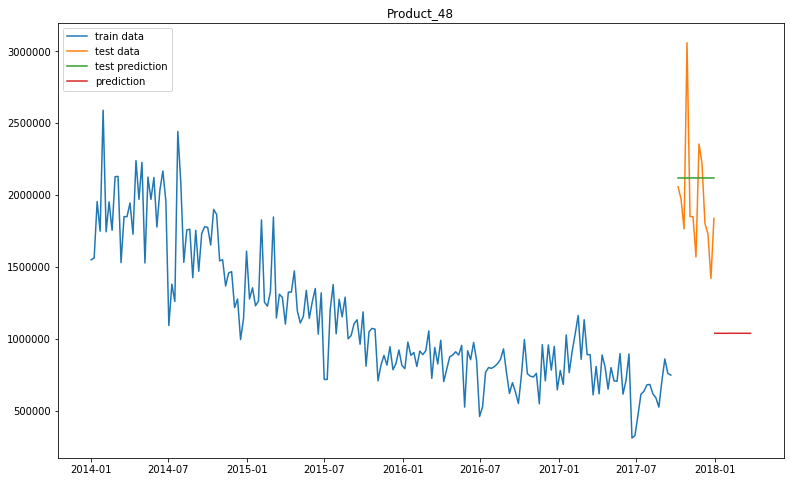

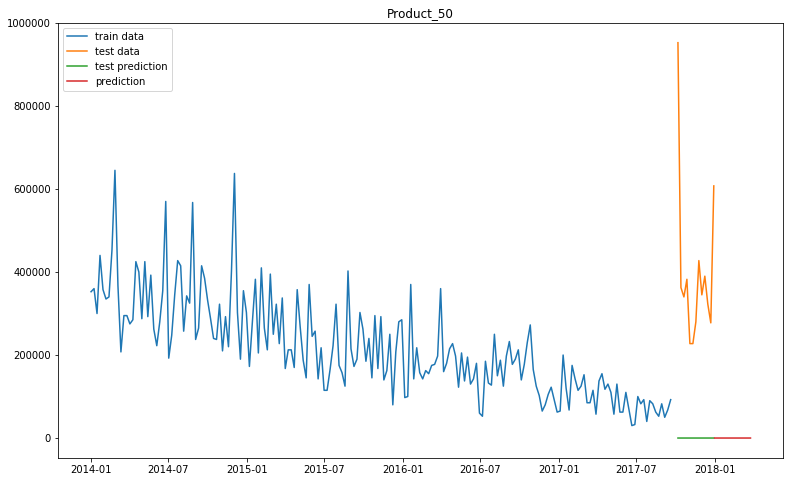

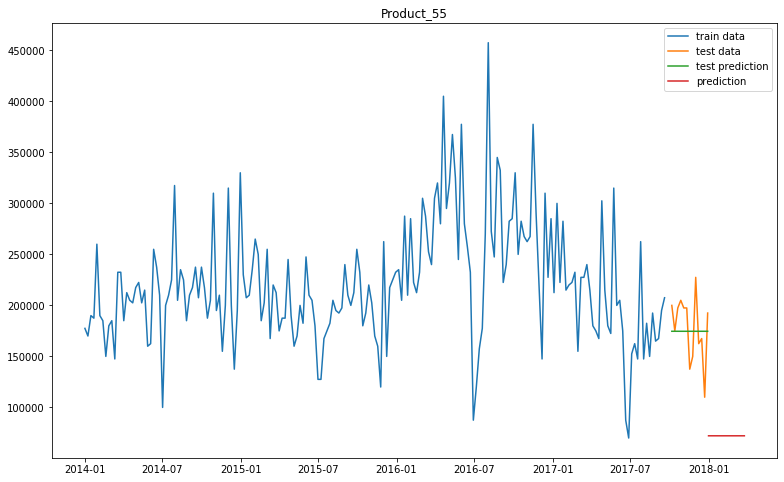

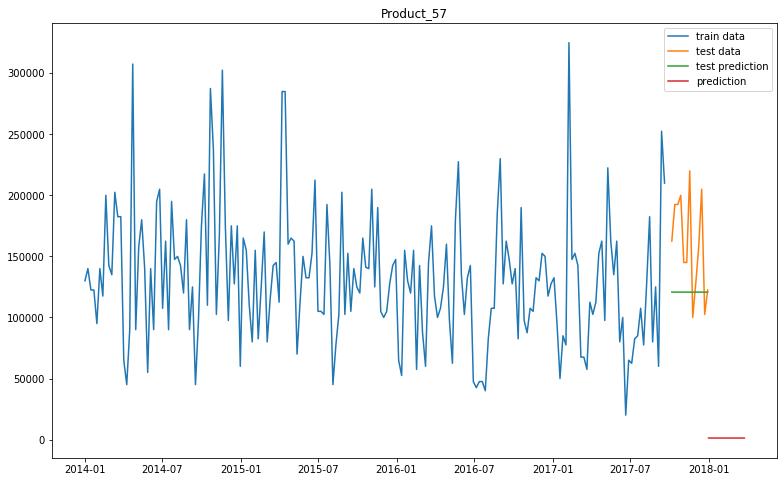

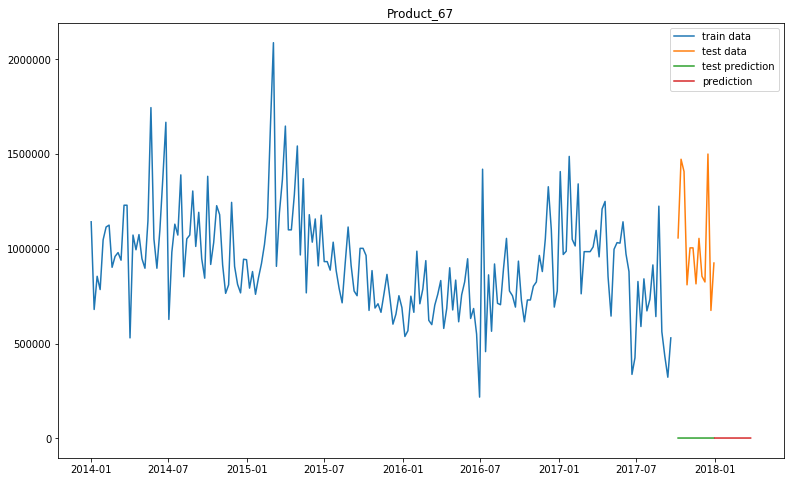

In [52]:
trainer = Trainer(name='mean_NOnorm_retrain', norm=False, retrain=True)
trainer(trains_loaders, tests_loaders, trains, tests, predictions, 0.01, 15)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [80669514394.59302]
Epoch [1/15], Step [20/182], Loss: [70385835818.22383]
Epoch [1/15], Step [30/182], Loss: [76495472234.19656]
Epoch [1/15], Step [40/182], Loss: [55358216122.613846]
Epoch [1/15], Step [50/182], Loss: [51470729010.8092]
Epoch [1/15], Step [60/182], Loss: [50692006318.75132]
Epoch [1/15], Step [70/182], Loss: [56365672779.34927]
Epoch [1/15], Step [80/182], Loss: [60502922043.80184]
Epoch [1/15], Step [90/182], Loss: [53991715446.95264]
Epoch [1/15], Step [100/182], Loss: [54669231157.61432]
Epoch [1/15], Step [110/182], Loss: [54240394907.52425]
Epoch [1/15], Step [120/182], Loss: [55793586950.701324]
Epoch [1/15], Step [130/182], Loss: [68775939057.75679]
Epoch [1/15], Step [140/182], Loss: [71144245576.92772]
Epoch [1/15], Step [150/182], Loss: [66925381426.31034]
Epoch [1/15], Step [160/182], Loss: [62580471080.31225]
Epoch [1/15], Step [170/182], Loss: [71630845849.87804]
Epoch [1/15], Step [180/182], Loss: [58757962656.3979]
E

Epoch [9/15], Step [40/182], Loss: [38419975413.94563]
Epoch [9/15], Step [50/182], Loss: [34567561707.928406]
Epoch [9/15], Step [60/182], Loss: [33487433450.647503]
Epoch [9/15], Step [70/182], Loss: [38519270386.591736]
Epoch [9/15], Step [80/182], Loss: [41313077475.21824]
Epoch [9/15], Step [90/182], Loss: [43940487663.65384]
Epoch [9/15], Step [100/182], Loss: [44187704852.51852]
Epoch [9/15], Step [110/182], Loss: [43792697968.870415]
Epoch [9/15], Step [120/182], Loss: [36868964813.96374]
Epoch [9/15], Step [130/182], Loss: [68456364433.77782]
Epoch [9/15], Step [140/182], Loss: [47684307742.7891]
Epoch [9/15], Step [150/182], Loss: [54573230053.55815]
Epoch [9/15], Step [160/182], Loss: [62249743181.34415]
Epoch [9/15], Step [170/182], Loss: [47490017131.982834]
Epoch [9/15], Step [180/182], Loss: [37182540760.47024]
Epoch [10/15], Step [10/182], Loss: [53679979234.17241]
Epoch [10/15], Step [20/182], Loss: [56714590136.82573]
Epoch [10/15], Step [30/182], Loss: [49670543899.2

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [465758860422.546]
Epoch [1/15], Step [20/182], Loss: [645601555086.0773]
Epoch [1/15], Step [30/182], Loss: [488902571531.80334]
Epoch [1/15], Step [40/182], Loss: [261071390937.9401]
Epoch [1/15], Step [50/182], Loss: [267343569198.81024]
Epoch [1/15], Step [60/182], Loss: [275496245261.2486]
Epoch [1/15], Step [70/182], Loss: [242804583573.12833]
Epoch [1/15], Step [80/182], Loss: [213438945504.45007]
Epoch [1/15], Step [90/182], Loss: [175422604329.0614]
Epoch [1/15], Step [100/182], Loss: [154289497186.94003]
Epoch [1/15], Step [110/182], Loss: [208421601849.87628]
Epoch [1/15], Step [120/182], Loss: [246584917462.87668]
Epoch [1/15], Step [130/182], Loss: [191794433878.3638]
Epoch [1/15], Step [140/182], Loss: [155610658575.41647]
Epoch [1/15], Step [150/182], Loss: [157454433291.10965]
Epoch [1/15], Step [160/182], Loss: [201202262349.06235]
Epoch [1/15], Step [170/182], Loss: [338335967928.51733]
Epoch [1/15], Step [180/182], Loss: [2147912563

Epoch [9/15], Step [40/182], Loss: [94543948815.55093]
Epoch [9/15], Step [50/182], Loss: [93547137161.70163]
Epoch [9/15], Step [60/182], Loss: [108821368579.11607]
Epoch [9/15], Step [70/182], Loss: [91031086857.65909]
Epoch [9/15], Step [80/182], Loss: [68824472486.53067]
Epoch [9/15], Step [90/182], Loss: [47474793469.8929]
Epoch [9/15], Step [100/182], Loss: [36328154695.11761]
Epoch [9/15], Step [110/182], Loss: [182937216601.77252]
Epoch [9/15], Step [120/182], Loss: [220902210653.70044]
Epoch [9/15], Step [130/182], Loss: [64642696850.48473]
Epoch [9/15], Step [140/182], Loss: [35198699091.95443]
Epoch [9/15], Step [150/182], Loss: [34770646899.1752]
Epoch [9/15], Step [160/182], Loss: [56249738764.372795]
Epoch [9/15], Step [170/182], Loss: [140043342451.2228]
Epoch [9/15], Step [180/182], Loss: [72442861539.95244]
Epoch [10/15], Step [10/182], Loss: [195543744374.5596]
Epoch [10/15], Step [20/182], Loss: [187498347320.64725]
Epoch [10/15], Step [30/182], Loss: [224816649808.1

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [57887015492.10048]
Epoch [1/15], Step [20/182], Loss: [46551867310.89466]
Epoch [1/15], Step [30/182], Loss: [148371644505.02267]
Epoch [1/15], Step [40/182], Loss: [121747133503.01697]
Epoch [1/15], Step [50/182], Loss: [93187607265.48886]
Epoch [1/15], Step [60/182], Loss: [95346952467.84825]
Epoch [1/15], Step [70/182], Loss: [133699207175.78084]
Epoch [1/15], Step [80/182], Loss: [21463427674.694115]
Epoch [1/15], Step [90/182], Loss: [10341589247.910448]
Epoch [1/15], Step [100/182], Loss: [55893170013.75736]
Epoch [1/15], Step [110/182], Loss: [149875334284.89972]
Epoch [1/15], Step [120/182], Loss: [51919661734.92115]
Epoch [1/15], Step [130/182], Loss: [93020957069.14725]
Epoch [1/15], Step [140/182], Loss: [92270908133.3846]
Epoch [1/15], Step [150/182], Loss: [91805365140.32275]
Epoch [1/15], Step [160/182], Loss: [68764478823.10062]
Epoch [1/15], Step [170/182], Loss: [36932102781.459]
Epoch [1/15], Step [180/182], Loss: [14655605097.05852

Epoch [9/15], Step [30/182], Loss: [27942974789.071854]
Epoch [9/15], Step [40/182], Loss: [27885872288.62564]
Epoch [9/15], Step [50/182], Loss: [31034110063.104942]
Epoch [9/15], Step [60/182], Loss: [111010607436.23172]
Epoch [9/15], Step [70/182], Loss: [36675184831.60679]
Epoch [9/15], Step [80/182], Loss: [44491901815.48545]
Epoch [9/15], Step [90/182], Loss: [32843302055.12866]
Epoch [9/15], Step [100/182], Loss: [38395934915.5062]
Epoch [9/15], Step [110/182], Loss: [45651892931.36869]
Epoch [9/15], Step [120/182], Loss: [39427698323.91751]
Epoch [9/15], Step [130/182], Loss: [31698687215.0876]
Epoch [9/15], Step [140/182], Loss: [29727560432.04438]
Epoch [9/15], Step [150/182], Loss: [8353299663.933919]
Epoch [9/15], Step [160/182], Loss: [31847866745.319927]
Epoch [9/15], Step [170/182], Loss: [33895075355.084904]
Epoch [9/15], Step [180/182], Loss: [29312259118.522427]
Epoch [10/15], Step [10/182], Loss: [28898757757.195007]
Epoch [10/15], Step [20/182], Loss: [33962503259.9

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/180], Loss: [31239714919.260563]
Epoch [1/15], Step [20/180], Loss: [23556839482.867443]
Epoch [1/15], Step [30/180], Loss: [12035566016.215555]
Epoch [1/15], Step [40/180], Loss: [128553468923.35559]
Epoch [1/15], Step [50/180], Loss: [7850693211.9391]
Epoch [1/15], Step [60/180], Loss: [197297852053.0484]
Epoch [1/15], Step [70/180], Loss: [8410654026.144247]
Epoch [1/15], Step [80/180], Loss: [144479215952.95514]
Epoch [1/15], Step [90/180], Loss: [173635286484.52713]
Epoch [1/15], Step [100/180], Loss: [6684188020.343077]
Epoch [1/15], Step [110/180], Loss: [14672674382.946096]
Epoch [1/15], Step [120/180], Loss: [20435915508.988884]
Epoch [1/15], Step [130/180], Loss: [17214826927.86849]
Epoch [1/15], Step [140/180], Loss: [13490917769.983814]
Epoch [1/15], Step [150/180], Loss: [15949183119.61765]
Epoch [1/15], Step [160/180], Loss: [35325475023.953186]
Epoch [1/15], Step [170/180], Loss: [18601438705.86834]
Epoch [1/15], Step [180/180], Loss: [9734842157.0

Epoch [9/15], Step [70/180], Loss: [28505049065.638237]
Epoch [9/15], Step [80/180], Loss: [8628811188.544754]
Epoch [9/15], Step [90/180], Loss: [5992053579.469973]
Epoch [9/15], Step [100/180], Loss: [155641999004.49118]
Epoch [9/15], Step [110/180], Loss: [6559903510.114056]
Epoch [9/15], Step [120/180], Loss: [17569958822.808254]
Epoch [9/15], Step [130/180], Loss: [38928651994.72425]
Epoch [9/15], Step [140/180], Loss: [197380291011.45566]
Epoch [9/15], Step [150/180], Loss: [6258170589.842736]
Epoch [9/15], Step [160/180], Loss: [16265374457.498444]
Epoch [9/15], Step [170/180], Loss: [57587280625.842316]
Epoch [9/15], Step [180/180], Loss: [15878093513.670597]
Epoch [10/15], Step [10/180], Loss: [8337901177.496947]
Epoch [10/15], Step [20/180], Loss: [11221363383.530418]
Epoch [10/15], Step [30/180], Loss: [174123645639.25336]
Epoch [10/15], Step [40/180], Loss: [10463012765.370266]
Epoch [10/15], Step [50/180], Loss: [6994784588.599442]
Epoch [10/15], Step [60/180], Loss: [5118

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [30/182], Loss: [13453175444.495811]
Epoch [1/15], Step [40/182], Loss: [11301689004.914469]
Epoch [1/15], Step [50/182], Loss: [110585588882.7323]
Epoch [1/15], Step [60/182], Loss: [113507330893.83434]
Epoch [1/15], Step [70/182], Loss: [118633855988.66235]
Epoch [1/15], Step [80/182], Loss: [116291988692.86028]
Epoch [1/15], Step [90/182], Loss: [18339681470.77348]
Epoch [1/15], Step [100/182], Loss: [103674722647.89977]
Epoch [1/15], Step [110/182], Loss: [90591884617.97723]
Epoch [1/15], Step [120/182], Loss: [13743484215.670055]
Epoch [1/15], Step [130/182], Loss: [103599116562.01567]
Epoch [1/15], Step [140/182], Loss: [103192440699.16672]
Epoch [1/15], Step [150/182], Loss: [16798970163.270277]
Epoch [1/15], Step [160/182], Loss: [99228232497.88515]
Epoch [1/15], Step [170/182], Loss: [103726092462.85567]
Epoch [1/15], Step [180/182], Loss: [108103145707.82664]
Epoch [2/15], Step [10/182], Loss: [74795889086.41246]
Epoch [2/15], Step [20/182], Loss: [98405124

Epoch [9/15], Step [90/182], Loss: [2865604218.0575542]
Epoch [9/15], Step [100/182], Loss: [20791502069.835285]
Epoch [9/15], Step [110/182], Loss: [1705404954.7348175]
Epoch [9/15], Step [120/182], Loss: [20320055605.597652]
Epoch [9/15], Step [130/182], Loss: [11823323996.02238]
Epoch [9/15], Step [140/182], Loss: [21181777596.872047]
Epoch [9/15], Step [150/182], Loss: [24203562948.950356]
Epoch [9/15], Step [160/182], Loss: [20345986613.31565]
Epoch [9/15], Step [170/182], Loss: [1609050188.5158622]
Epoch [9/15], Step [180/182], Loss: [25871616772.731335]
Epoch [10/15], Step [10/182], Loss: [11553044469.703762]
Epoch [10/15], Step [20/182], Loss: [16522680607.398363]
Epoch [10/15], Step [30/182], Loss: [15717464616.738558]
Epoch [10/15], Step [40/182], Loss: [10517970195.671589]
Epoch [10/15], Step [50/182], Loss: [18544164932.234642]
Epoch [10/15], Step [60/182], Loss: [19428948908.172775]
Epoch [10/15], Step [70/182], Loss: [22329109456.116695]
Epoch [10/15], Step [80/182], Loss

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [3805354953961.125]
Epoch [1/15], Step [20/182], Loss: [3202264733447.546]
Epoch [1/15], Step [30/182], Loss: [2596981361113.919]
Epoch [1/15], Step [40/182], Loss: [1745991688387.0278]
Epoch [1/15], Step [50/182], Loss: [1430341476568.3752]
Epoch [1/15], Step [60/182], Loss: [1263652244441.4714]
Epoch [1/15], Step [70/182], Loss: [1143911615909.829]
Epoch [1/15], Step [80/182], Loss: [879740124428.0582]
Epoch [1/15], Step [90/182], Loss: [588130926611.884]
Epoch [1/15], Step [100/182], Loss: [464547104373.9749]
Epoch [1/15], Step [110/182], Loss: [471202291646.3373]
Epoch [1/15], Step [120/182], Loss: [521756801173.61743]
Epoch [1/15], Step [130/182], Loss: [323778739116.77527]
Epoch [1/15], Step [140/182], Loss: [547399543265.35376]
Epoch [1/15], Step [150/182], Loss: [393903697949.1933]
Epoch [1/15], Step [160/182], Loss: [513354816935.80316]
Epoch [1/15], Step [170/182], Loss: [302473486349.24286]
Epoch [1/15], Step [180/182], Loss: [184095637083.

Epoch [9/15], Step [40/182], Loss: [1224104234887.4036]
Epoch [9/15], Step [50/182], Loss: [1889698932524.2031]
Epoch [9/15], Step [60/182], Loss: [819544783592.289]
Epoch [9/15], Step [70/182], Loss: [587156659692.481]
Epoch [9/15], Step [80/182], Loss: [513643389907.2759]
Epoch [9/15], Step [90/182], Loss: [296380590950.05286]
Epoch [9/15], Step [100/182], Loss: [205809863222.4665]
Epoch [9/15], Step [110/182], Loss: [212410276694.87527]
Epoch [9/15], Step [120/182], Loss: [172904961608.3113]
Epoch [9/15], Step [130/182], Loss: [121823380046.45003]
Epoch [9/15], Step [140/182], Loss: [110925097667.33575]
Epoch [9/15], Step [150/182], Loss: [164483647451.9917]
Epoch [9/15], Step [160/182], Loss: [244058729904.58902]
Epoch [9/15], Step [170/182], Loss: [111298585193.0127]
Epoch [9/15], Step [180/182], Loss: [375310672986.7866]
Epoch [10/15], Step [10/182], Loss: [2330149637043.6343]
Epoch [10/15], Step [20/182], Loss: [2778584487901.0894]
Epoch [10/15], Step [30/182], Loss: [1861093335

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [98553131766.16975]
Epoch [1/15], Step [20/182], Loss: [122223700698.66316]
Epoch [1/15], Step [30/182], Loss: [8353914491.654578]
Epoch [1/15], Step [40/182], Loss: [13301086649.995329]
Epoch [1/15], Step [50/182], Loss: [135710591307.1194]
Epoch [1/15], Step [60/182], Loss: [161987829898.11856]
Epoch [1/15], Step [70/182], Loss: [193426466643.74832]
Epoch [1/15], Step [80/182], Loss: [189601958583.1133]
Epoch [1/15], Step [90/182], Loss: [192609480654.27673]
Epoch [1/15], Step [100/182], Loss: [206972182129.07724]
Epoch [1/15], Step [110/182], Loss: [20822812968.625664]
Epoch [1/15], Step [120/182], Loss: [30351051606.489834]
Epoch [1/15], Step [130/182], Loss: [225849995809.48035]
Epoch [1/15], Step [140/182], Loss: [24873663490.035522]
Epoch [1/15], Step [150/182], Loss: [270537910303.0112]
Epoch [1/15], Step [160/182], Loss: [251212410136.5196]
Epoch [1/15], Step [170/182], Loss: [50273512273.434395]
Epoch [1/15], Step [180/182], Loss: [296818173

Epoch [9/15], Step [50/182], Loss: [19944984231.57258]
Epoch [9/15], Step [60/182], Loss: [68468960501.06146]
Epoch [9/15], Step [70/182], Loss: [6501354490.2199545]
Epoch [9/15], Step [80/182], Loss: [40769311190.51878]
Epoch [9/15], Step [90/182], Loss: [41715444480.74596]
Epoch [9/15], Step [100/182], Loss: [42189138736.01957]
Epoch [9/15], Step [110/182], Loss: [44884225949.65981]
Epoch [9/15], Step [120/182], Loss: [59693824964.307045]
Epoch [9/15], Step [130/182], Loss: [58957748113.27083]
Epoch [9/15], Step [140/182], Loss: [3687484800.985607]
Epoch [9/15], Step [150/182], Loss: [82886863248.1754]
Epoch [9/15], Step [160/182], Loss: [75011939858.26541]
Epoch [9/15], Step [170/182], Loss: [88839796820.42484]
Epoch [9/15], Step [180/182], Loss: [16192587482.859968]
Epoch [10/15], Step [10/182], Loss: [8452296488.915172]
Epoch [10/15], Step [20/182], Loss: [114969367990.12271]
Epoch [10/15], Step [30/182], Loss: [125464517262.40135]
Epoch [10/15], Step [40/182], Loss: [18233503575.

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [2400777445.6313515]
Epoch [1/15], Step [20/182], Loss: [11960193072.980513]
Epoch [1/15], Step [30/182], Loss: [7108443455.704289]
Epoch [1/15], Step [40/182], Loss: [10122655466.96819]
Epoch [1/15], Step [50/182], Loss: [8053243730.741665]
Epoch [1/15], Step [60/182], Loss: [11400193829.994646]
Epoch [1/15], Step [70/182], Loss: [14908439288.499569]
Epoch [1/15], Step [80/182], Loss: [2760523811.30026]
Epoch [1/15], Step [90/182], Loss: [11199116735.135862]
Epoch [1/15], Step [100/182], Loss: [7360381333.5568]
Epoch [1/15], Step [110/182], Loss: [79116918289.37186]
Epoch [1/15], Step [120/182], Loss: [8182941784.600227]
Epoch [1/15], Step [130/182], Loss: [11401152372.043182]
Epoch [1/15], Step [140/182], Loss: [19102129539.634796]
Epoch [1/15], Step [150/182], Loss: [4168426581.76645]
Epoch [1/15], Step [160/182], Loss: [6510080983.594386]
Epoch [1/15], Step [170/182], Loss: [41552313398.27317]
Epoch [1/15], Step [180/182], Loss: [18403677665.91672

Epoch [9/15], Step [40/182], Loss: [3062874387.4098763]
Epoch [9/15], Step [50/182], Loss: [2227123512.4743333]
Epoch [9/15], Step [60/182], Loss: [2510868678.536655]
Epoch [9/15], Step [70/182], Loss: [4306463934.007848]
Epoch [9/15], Step [80/182], Loss: [38489477068.04111]
Epoch [9/15], Step [90/182], Loss: [39043066042.893524]
Epoch [9/15], Step [100/182], Loss: [2258340623.4734955]
Epoch [9/15], Step [110/182], Loss: [4407373514.995]
Epoch [9/15], Step [120/182], Loss: [9551134869.708847]
Epoch [9/15], Step [130/182], Loss: [9076575352.152514]
Epoch [9/15], Step [140/182], Loss: [3744696440.8815374]
Epoch [9/15], Step [150/182], Loss: [3534812235.3808074]
Epoch [9/15], Step [160/182], Loss: [1478782431.528475]
Epoch [9/15], Step [170/182], Loss: [4628560865.981214]
Epoch [9/15], Step [180/182], Loss: [7897020364.423727]
Epoch [10/15], Step [10/182], Loss: [1927566495.147189]
Epoch [10/15], Step [20/182], Loss: [10039560413.464472]
Epoch [10/15], Step [30/182], Loss: [1153545861.91

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [5351535289.767299]
Epoch [1/15], Step [20/182], Loss: [2412791874.731615]
Epoch [1/15], Step [30/182], Loss: [11214382598.438873]
Epoch [1/15], Step [40/182], Loss: [35493485386.87113]
Epoch [1/15], Step [50/182], Loss: [12020003816.835112]
Epoch [1/15], Step [60/182], Loss: [9611139834.138432]
Epoch [1/15], Step [70/182], Loss: [9740807037.558275]
Epoch [1/15], Step [80/182], Loss: [16011238435.710476]
Epoch [1/15], Step [90/182], Loss: [8919407930.261507]
Epoch [1/15], Step [100/182], Loss: [13124057055.913298]
Epoch [1/15], Step [110/182], Loss: [12146932147.82161]
Epoch [1/15], Step [120/182], Loss: [12996131431.942032]
Epoch [1/15], Step [130/182], Loss: [16877878152.019592]
Epoch [1/15], Step [140/182], Loss: [9020287066.651585]
Epoch [1/15], Step [150/182], Loss: [12761810626.72988]
Epoch [1/15], Step [160/182], Loss: [4762116612.959492]
Epoch [1/15], Step [170/182], Loss: [2449185106.619798]
Epoch [1/15], Step [180/182], Loss: [16147103252.05

Epoch [9/15], Step [40/182], Loss: [5142900827.97947]
Epoch [9/15], Step [50/182], Loss: [2022281381.855661]
Epoch [9/15], Step [60/182], Loss: [4012559484.151646]
Epoch [9/15], Step [70/182], Loss: [1550964779.8361282]
Epoch [9/15], Step [80/182], Loss: [3759345860.8648467]
Epoch [9/15], Step [90/182], Loss: [1186232282.106343]
Epoch [9/15], Step [100/182], Loss: [2492790877.320703]
Epoch [9/15], Step [110/182], Loss: [2995712250.438178]
Epoch [9/15], Step [120/182], Loss: [3249577089.4223323]
Epoch [9/15], Step [130/182], Loss: [5279733463.563325]
Epoch [9/15], Step [140/182], Loss: [1764799627.7543116]
Epoch [9/15], Step [150/182], Loss: [1957908622.8417637]
Epoch [9/15], Step [160/182], Loss: [5682981955.335813]
Epoch [9/15], Step [170/182], Loss: [2717902585.766085]
Epoch [9/15], Step [180/182], Loss: [4214355154.8613367]
Epoch [10/15], Step [10/182], Loss: [9227540587.659151]
Epoch [10/15], Step [20/182], Loss: [1977751615.7304862]
Epoch [10/15], Step [30/182], Loss: [2087805129.

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [924557231373.6218]
Epoch [1/15], Step [20/182], Loss: [1126704615801.3633]
Epoch [1/15], Step [30/182], Loss: [918053567509.5051]
Epoch [1/15], Step [40/182], Loss: [762280792470.594]
Epoch [1/15], Step [50/182], Loss: [1228922789821.856]
Epoch [1/15], Step [60/182], Loss: [1521251906890.5618]
Epoch [1/15], Step [70/182], Loss: [1026573019648.537]
Epoch [1/15], Step [80/182], Loss: [821657356678.6406]
Epoch [1/15], Step [90/182], Loss: [436579976688.87665]
Epoch [1/15], Step [100/182], Loss: [336533611822.0296]
Epoch [1/15], Step [110/182], Loss: [380056637015.9327]
Epoch [1/15], Step [120/182], Loss: [626441875836.4259]
Epoch [1/15], Step [130/182], Loss: [453198855361.13165]
Epoch [1/15], Step [140/182], Loss: [443390018756.2303]
Epoch [1/15], Step [150/182], Loss: [842218988499.2618]
Epoch [1/15], Step [160/182], Loss: [1006232281919.8162]
Epoch [1/15], Step [170/182], Loss: [694555198643.6895]
Epoch [1/15], Step [180/182], Loss: [394754110604.907

Epoch [9/15], Step [80/182], Loss: [299407988545.3892]
Epoch [9/15], Step [90/182], Loss: [639061496073.1265]
Epoch [9/15], Step [100/182], Loss: [133304014889.92982]
Epoch [9/15], Step [110/182], Loss: [160700832101.06192]
Epoch [9/15], Step [120/182], Loss: [210583047758.34573]
Epoch [9/15], Step [130/182], Loss: [230032324235.3492]
Epoch [9/15], Step [140/182], Loss: [199413988291.41678]
Epoch [9/15], Step [150/182], Loss: [492646765333.3429]
Epoch [9/15], Step [160/182], Loss: [789694877710.6384]
Epoch [9/15], Step [170/182], Loss: [382408183885.84344]
Epoch [9/15], Step [180/182], Loss: [179669731946.9828]
Epoch [10/15], Step [10/182], Loss: [527331484344.12854]
Epoch [10/15], Step [20/182], Loss: [1420107229235.4548]
Epoch [10/15], Step [30/182], Loss: [509061802840.59875]
Epoch [10/15], Step [40/182], Loss: [396851092835.0166]
Epoch [10/15], Step [50/182], Loss: [563406955689.6643]
Epoch [10/15], Step [60/182], Loss: [978909198117.75]
Epoch [10/15], Step [70/182], Loss: [4875792

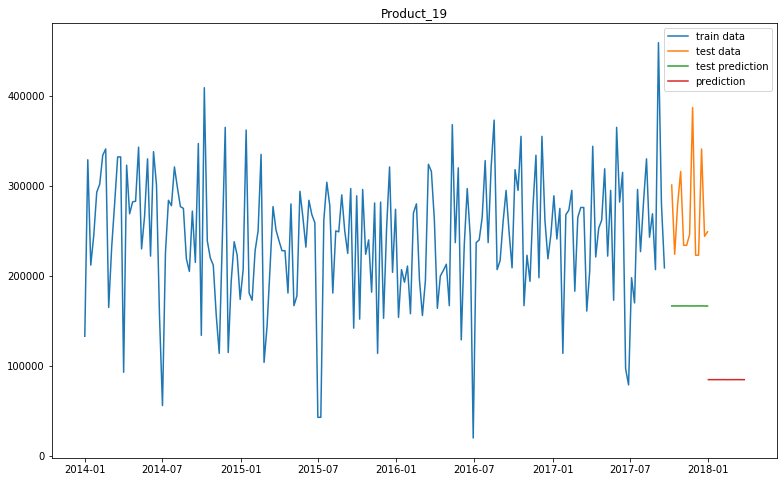

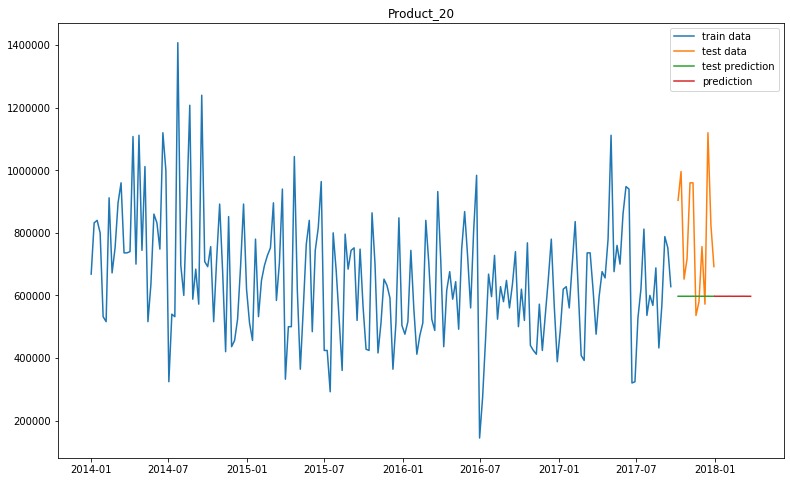

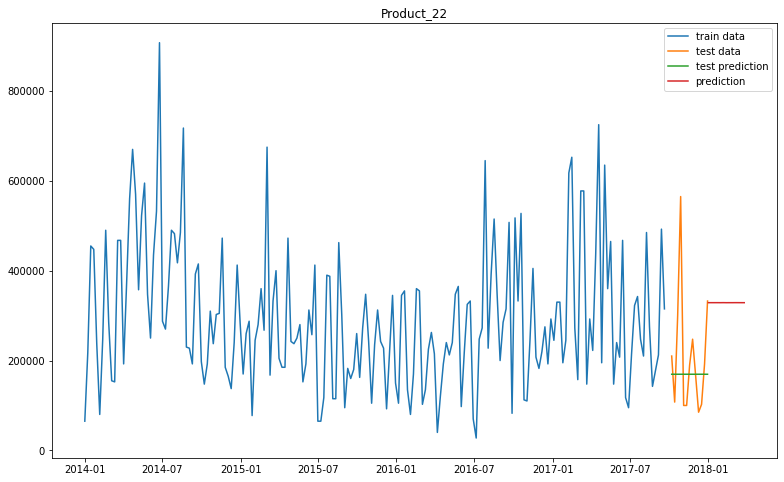

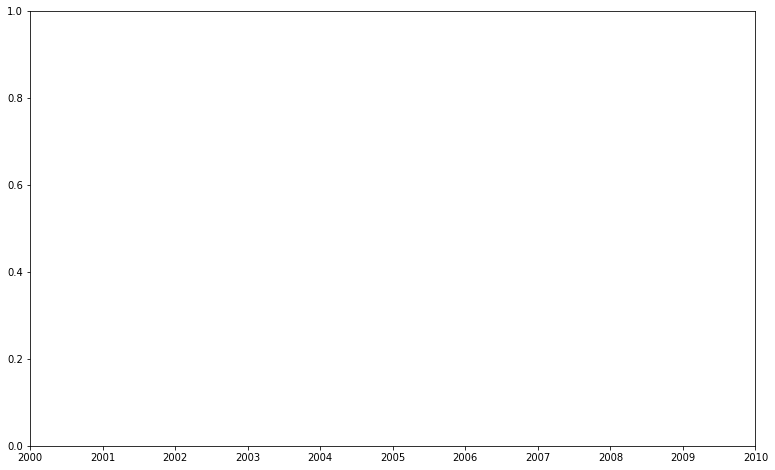

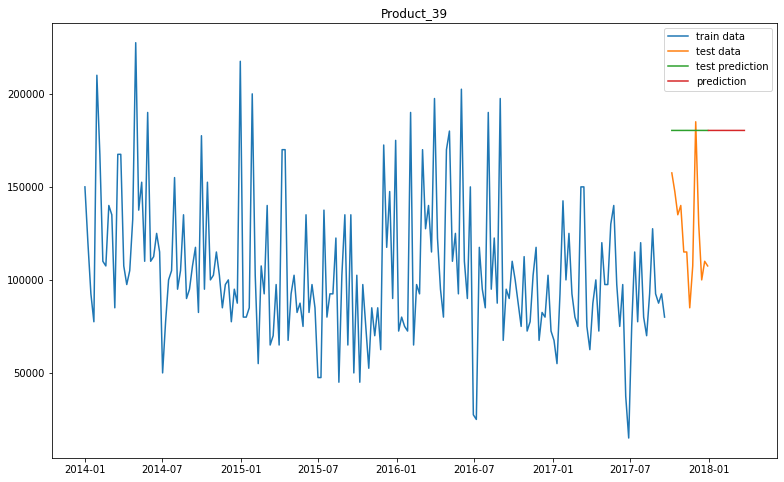

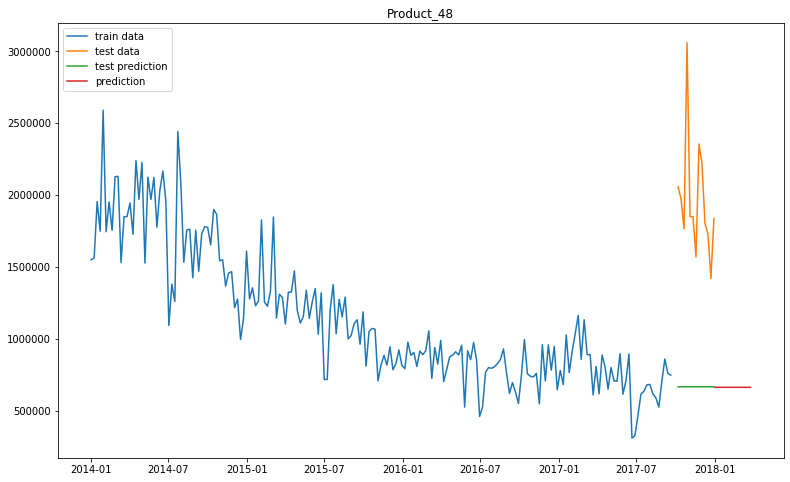

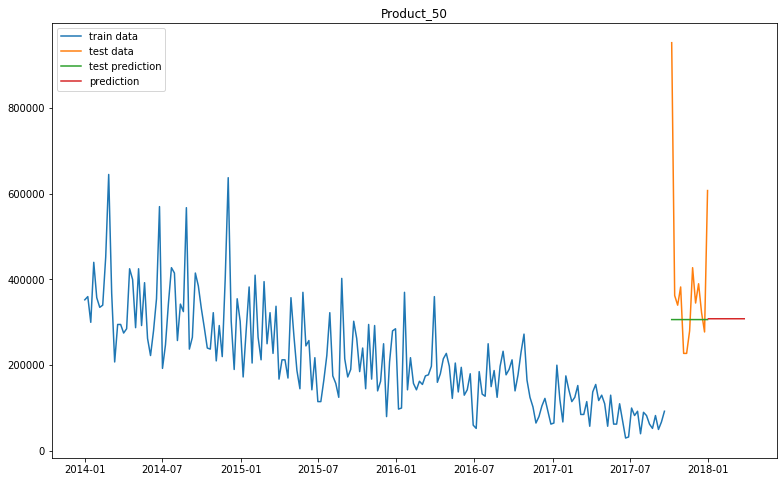

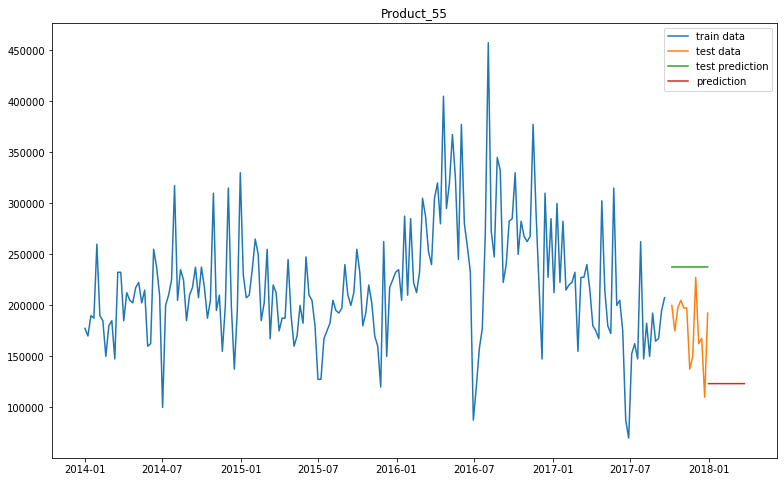

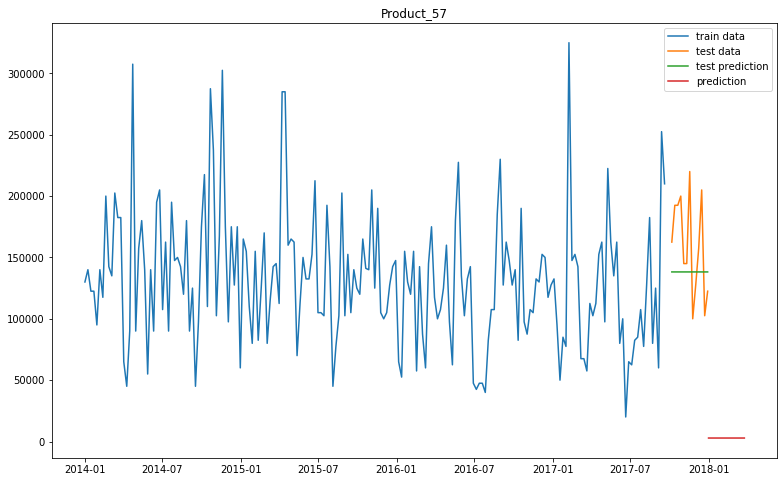

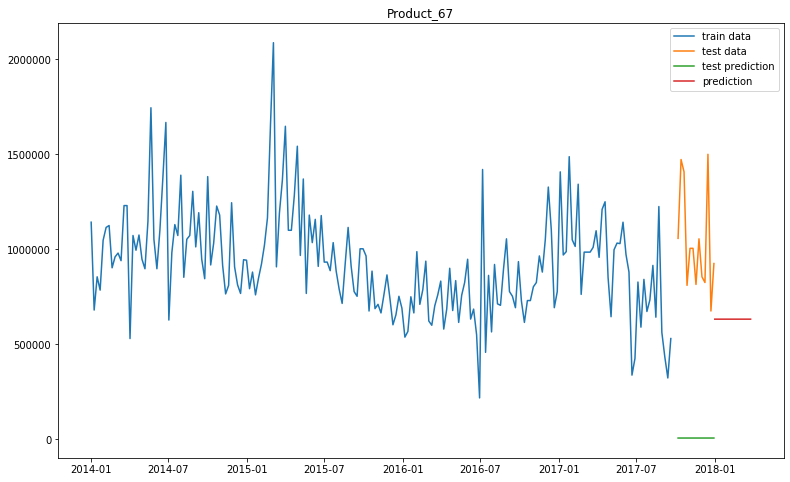

In [53]:
# BEST RESULT: PICS FOLDER median ds/norm_NOretrain
# Stats available here: stats_mean_NOnorm_retrain.json

trainer = Trainer(name='mean_NOnorm_retrain', norm=True, retrain=False)
trainer(trains_loaders, tests_loaders, trains, tests, predictions, 0.01, 15)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [79299090075.77719]
Epoch [1/15], Step [20/182], Loss: [56420606344.67904]
Epoch [1/15], Step [30/182], Loss: [8798705591.165752]
Epoch [1/15], Step [40/182], Loss: [8890844775.71145]
Epoch [1/15], Step [50/182], Loss: [5706272757.117627]
Epoch [1/15], Step [60/182], Loss: [4160710881.80181]
Epoch [1/15], Step [70/182], Loss: [7616126465.0214]
Epoch [1/15], Step [80/182], Loss: [5586689830.949896]
Epoch [1/15], Step [90/182], Loss: [4132208661.854579]
Epoch [1/15], Step [100/182], Loss: [3170578622.2037687]
Epoch [1/15], Step [110/182], Loss: [6826683676.593741]
Epoch [1/15], Step [120/182], Loss: [7008695158.871565]
Epoch [1/15], Step [130/182], Loss: [6622082081.841048]
Epoch [1/15], Step [140/182], Loss: [3080174652.920964]
Epoch [1/15], Step [150/182], Loss: [3687397022.4159822]
Epoch [1/15], Step [160/182], Loss: [4642388562.281157]
Epoch [1/15], Step [170/182], Loss: [5231325357.976521]
Epoch [1/15], Step [180/182], Loss: [5744333768.546162]
Epo

Epoch [9/15], Step [50/182], Loss: [4653333259.795825]
Epoch [9/15], Step [60/182], Loss: [3675043471.2791986]
Epoch [9/15], Step [70/182], Loss: [7345039940.999896]
Epoch [9/15], Step [80/182], Loss: [5205747353.09246]
Epoch [9/15], Step [90/182], Loss: [4279995423.5902157]
Epoch [9/15], Step [100/182], Loss: [2916702211.070465]
Epoch [9/15], Step [110/182], Loss: [3105475669.809769]
Epoch [9/15], Step [120/182], Loss: [7000143874.581389]
Epoch [9/15], Step [130/182], Loss: [6594557377.799396]
Epoch [9/15], Step [140/182], Loss: [3270938308.4071007]
Epoch [9/15], Step [150/182], Loss: [3883221630.234403]
Epoch [9/15], Step [160/182], Loss: [3636759369.87384]
Epoch [9/15], Step [170/182], Loss: [5105261227.216104]
Epoch [9/15], Step [180/182], Loss: [5735774090.041846]
Epoch [10/15], Step [10/182], Loss: [4217764380.356737]
Epoch [10/15], Step [20/182], Loss: [5770163976.284533]
Epoch [10/15], Step [30/182], Loss: [4629555121.296657]
Epoch [10/15], Step [40/182], Loss: [7279708584.1084

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [715203662438.6309]
Epoch [1/15], Step [20/182], Loss: [647919675532.537]
Epoch [1/15], Step [30/182], Loss: [736229381233.4464]
Epoch [1/15], Step [40/182], Loss: [456259872928.52386]
Epoch [1/15], Step [50/182], Loss: [469047006483.65356]
Epoch [1/15], Step [60/182], Loss: [472635354212.41705]
Epoch [1/15], Step [70/182], Loss: [429428594047.2399]
Epoch [1/15], Step [80/182], Loss: [395390903128.231]
Epoch [1/15], Step [90/182], Loss: [345391466567.3522]
Epoch [1/15], Step [100/182], Loss: [317519872344.42175]
Epoch [1/15], Step [110/182], Loss: [393566132378.222]
Epoch [1/15], Step [120/182], Loss: [438381705937.1209]
Epoch [1/15], Step [130/182], Loss: [365326220740.10925]
Epoch [1/15], Step [140/182], Loss: [325397470249.2633]
Epoch [1/15], Step [150/182], Loss: [329731780987.1482]
Epoch [1/15], Step [160/182], Loss: [392907834259.7964]
Epoch [1/15], Step [170/182], Loss: [574050451727.2601]
Epoch [1/15], Step [180/182], Loss: [404958366734.8397]

Epoch [9/15], Step [40/182], Loss: [453748895338.2659]
Epoch [9/15], Step [50/182], Loss: [466435589704.6627]
Epoch [9/15], Step [60/182], Loss: [470315773673.7387]
Epoch [9/15], Step [70/182], Loss: [426935677948.44446]
Epoch [9/15], Step [80/182], Loss: [392928191483.4605]
Epoch [9/15], Step [90/182], Loss: [343044823414.5213]
Epoch [9/15], Step [100/182], Loss: [315229482318.06903]
Epoch [9/15], Step [110/182], Loss: [392835392079.34204]
Epoch [9/15], Step [120/182], Loss: [435706025573.0451]
Epoch [9/15], Step [130/182], Loss: [363363635768.42615]
Epoch [9/15], Step [140/182], Loss: [322938440632.7869]
Epoch [9/15], Step [150/182], Loss: [327221605169.2162]
Epoch [9/15], Step [160/182], Loss: [390138157514.97833]
Epoch [9/15], Step [170/182], Loss: [571078220041.3726]
Epoch [9/15], Step [180/182], Loss: [402158690161.99164]
Epoch [10/15], Step [10/182], Loss: [711290011438.613]
Epoch [10/15], Step [20/182], Loss: [644289509396.7452]
Epoch [10/15], Step [30/182], Loss: [732258495608

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [201784527632.137]
Epoch [1/15], Step [20/182], Loss: [234047271879.7978]
Epoch [1/15], Step [30/182], Loss: [151003773913.40012]
Epoch [1/15], Step [40/182], Loss: [74324340362.59053]
Epoch [1/15], Step [50/182], Loss: [100524853987.47636]
Epoch [1/15], Step [60/182], Loss: [112831853970.06659]
Epoch [1/15], Step [70/182], Loss: [63452289726.587715]
Epoch [1/15], Step [80/182], Loss: [63080568757.34393]
Epoch [1/15], Step [90/182], Loss: [52984934945.28183]
Epoch [1/15], Step [100/182], Loss: [57468378362.46805]
Epoch [1/15], Step [110/182], Loss: [45850040177.14117]
Epoch [1/15], Step [120/182], Loss: [57257059647.039734]
Epoch [1/15], Step [130/182], Loss: [113836077579.80945]
Epoch [1/15], Step [140/182], Loss: [110234728418.96463]
Epoch [1/15], Step [150/182], Loss: [70980966804.94289]
Epoch [1/15], Step [160/182], Loss: [163693679708.09702]
Epoch [1/15], Step [170/182], Loss: [153374002744.3371]
Epoch [1/15], Step [180/182], Loss: [78424453555.6

Epoch [9/15], Step [70/182], Loss: [46146717516.17396]
Epoch [9/15], Step [80/182], Loss: [46454677436.73565]
Epoch [9/15], Step [90/182], Loss: [52718416013.15019]
Epoch [9/15], Step [100/182], Loss: [40540968520.90131]
Epoch [9/15], Step [110/182], Loss: [30958167017.462994]
Epoch [9/15], Step [120/182], Loss: [40278151600.79436]
Epoch [9/15], Step [130/182], Loss: [100626917621.43987]
Epoch [9/15], Step [140/182], Loss: [85615771855.82709]
Epoch [9/15], Step [150/182], Loss: [49274195624.63392]
Epoch [9/15], Step [160/182], Loss: [131826063486.53741]
Epoch [9/15], Step [170/182], Loss: [122605119057.3842]
Epoch [9/15], Step [180/182], Loss: [56091420146.15827]
Epoch [10/15], Step [10/182], Loss: [162902859876.6153]
Epoch [10/15], Step [20/182], Loss: [190579637550.31403]
Epoch [10/15], Step [30/182], Loss: [116848362476.41887]
Epoch [10/15], Step [40/182], Loss: [73961429806.41423]
Epoch [10/15], Step [50/182], Loss: [85309349486.48865]
Epoch [10/15], Step [60/182], Loss: [823016039

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/180], Loss: [243596081439.7885]
Epoch [1/15], Step [20/180], Loss: [207845037867.07355]
Epoch [1/15], Step [30/180], Loss: [177149775980.56564]
Epoch [1/15], Step [40/180], Loss: [130607432210.46178]
Epoch [1/15], Step [50/180], Loss: [161292429843.04578]
Epoch [1/15], Step [60/180], Loss: [199828846851.80496]
Epoch [1/15], Step [70/180], Loss: [149020667732.7813]
Epoch [1/15], Step [80/180], Loss: [146664346006.48428]
Epoch [1/15], Step [90/180], Loss: [176034670844.92664]
Epoch [1/15], Step [100/180], Loss: [158466010817.42493]
Epoch [1/15], Step [110/180], Loss: [194693343699.50357]
Epoch [1/15], Step [120/180], Loss: [182491374227.7739]
Epoch [1/15], Step [130/180], Loss: [160646665518.00143]
Epoch [1/15], Step [140/180], Loss: [200571906917.81876]
Epoch [1/15], Step [150/180], Loss: [205988150275.1058]
Epoch [1/15], Step [160/180], Loss: [266043650101.22827]
Epoch [1/15], Step [170/180], Loss: [212722072516.7879]
Epoch [1/15], Step [180/180], Loss: [14565159

Epoch [9/15], Step [20/180], Loss: [207832319947.6012]
Epoch [9/15], Step [30/180], Loss: [177137889361.41275]
Epoch [9/15], Step [40/180], Loss: [130597142562.90976]
Epoch [9/15], Step [50/180], Loss: [161281051622.32132]
Epoch [9/15], Step [60/180], Loss: [199816231740.36496]
Epoch [9/15], Step [70/180], Loss: [149009846571.0235]
Epoch [9/15], Step [80/180], Loss: [146653508662.95566]
Epoch [9/15], Step [90/180], Loss: [176022802308.84436]
Epoch [9/15], Step [100/180], Loss: [158454734409.0598]
Epoch [9/15], Step [110/180], Loss: [194680893606.3553]
Epoch [9/15], Step [120/180], Loss: [182479676373.12933]
Epoch [9/15], Step [130/180], Loss: [160635758200.60742]
Epoch [9/15], Step [140/180], Loss: [200559208414.77588]
Epoch [9/15], Step [150/180], Loss: [205975332122.91858]
Epoch [9/15], Step [160/180], Loss: [266029211636.68677]
Epoch [9/15], Step [170/180], Loss: [212709128746.9227]
Epoch [9/15], Step [180/180], Loss: [145641014292.34076]
Epoch [10/15], Step [10/180], Loss: [2435803

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch [1/15], Step [40/182], Loss: [12110916167.078444]
Epoch [1/15], Step [50/182], Loss: [14096866925.990541]
Epoch [1/15], Step [60/182], Loss: [11599133712.006548]
Epoch [1/15], Step [70/182], Loss: [8517243919.456748]
Epoch [1/15], Step [80/182], Loss: [9683872166.04386]
Epoch [1/15], Step [90/182], Loss: [9072875353.84411]
Epoch [1/15], Step [100/182], Loss: [13868639181.14384]
Epoch [1/15], Step [110/182], Loss: [18050920410.468575]
Epoch [1/15], Step [120/182], Loss: [15233849237.54066]
Epoch [1/15], Step [130/182], Loss: [13403569011.24046]
Epoch [1/15], Step [140/182], Loss: [11093778609.584833]
Epoch [1/15], Step [150/182], Loss: [8476754317.335985]
Epoch [1/15], Step [160/182], Loss: [11317761473.51]
Epoch [1/15], Step [170/182], Loss: [9433574833.15464]
Epoch [1/15], Step [180/182], Loss: [7743791042.863482]
Epoch [2/15], Step [10/182], Loss: [21000689165.601498]
Epoch [2/15], Step [20/182], Loss: [14419787306.988276]
Epoch [2/15], Step [30/182], Loss: [14310484148.885048

Epoch [9/15], Step [80/182], Loss: [3845613073.072746]
Epoch [9/15], Step [90/182], Loss: [3537986549.8234572]
Epoch [9/15], Step [100/182], Loss: [6615627202.293379]
Epoch [9/15], Step [110/182], Loss: [9102597120.975933]
Epoch [9/15], Step [120/182], Loss: [10793534686.180794]
Epoch [9/15], Step [130/182], Loss: [6268223109.7604065]
Epoch [9/15], Step [140/182], Loss: [7062797207.786006]
Epoch [9/15], Step [150/182], Loss: [2526238941.8319173]
Epoch [9/15], Step [160/182], Loss: [4122689430.3728375]
Epoch [9/15], Step [170/182], Loss: [9325823510.052256]
Epoch [9/15], Step [180/182], Loss: [4345087971.097945]
Epoch [10/15], Step [10/182], Loss: [20844663520.63625]
Epoch [10/15], Step [20/182], Loss: [5747015705.253985]
Epoch [10/15], Step [30/182], Loss: [5438846524.674875]
Epoch [10/15], Step [40/182], Loss: [4075713670.152101]
Epoch [10/15], Step [50/182], Loss: [5701025088.427455]
Epoch [10/15], Step [60/182], Loss: [11461338975.44483]
Epoch [10/15], Step [70/182], Loss: [20836166

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [3814241065399.5845]
Epoch [1/15], Step [20/182], Loss: [3544559412553.5894]
Epoch [1/15], Step [30/182], Loss: [3214591267560.326]
Epoch [1/15], Step [40/182], Loss: [2254536192317.739]
Epoch [1/15], Step [50/182], Loss: [1899843191338.2693]
Epoch [1/15], Step [60/182], Loss: [1712526652789.136]
Epoch [1/15], Step [70/182], Loss: [1359518377772.217]
Epoch [1/15], Step [80/182], Loss: [1264089385586.9744]
Epoch [1/15], Step [90/182], Loss: [907474014692.0801]
Epoch [1/15], Step [100/182], Loss: [757286473241.7864]
Epoch [1/15], Step [110/182], Loss: [767464242188.6307]
Epoch [1/15], Step [120/182], Loss: [670506538475.637]
Epoch [1/15], Step [130/182], Loss: [574083928472.6001]
Epoch [1/15], Step [140/182], Loss: [550877133856.3551]
Epoch [1/15], Step [150/182], Loss: [668830756699.6824]
Epoch [1/15], Step [160/182], Loss: [822788113276.1183]
Epoch [1/15], Step [170/182], Loss: [547235520147.3602]
Epoch [1/15], Step [180/182], Loss: [379902534957.9675

Epoch [9/15], Step [80/182], Loss: [1264059706526.6975]
Epoch [9/15], Step [90/182], Loss: [907448857450.7876]
Epoch [9/15], Step [100/182], Loss: [757263254101.5181]
Epoch [9/15], Step [110/182], Loss: [767440931624.181]
Epoch [9/15], Step [120/182], Loss: [670485076971.7491]
Epoch [9/15], Step [130/182], Loss: [574063924652.1265]
Epoch [9/15], Step [140/182], Loss: [550857534711.8362]
Epoch [9/15], Step [150/182], Loss: [668809140364.5792]
Epoch [9/15], Step [160/182], Loss: [822764180713.4008]
Epoch [9/15], Step [170/182], Loss: [547216104040.12836]
Epoch [9/15], Step [180/182], Loss: [379886518129.5234]
Epoch [10/15], Step [10/182], Loss: [3814183673313.33]
Epoch [10/15], Step [20/182], Loss: [3544504770595.963]
Epoch [10/15], Step [30/182], Loss: [3214538462267.999]
Epoch [10/15], Step [40/182], Loss: [2254492087970.75]
Epoch [10/15], Step [50/182], Loss: [1899802592617.5696]
Epoch [10/15], Step [60/182], Loss: [1712487824117.5063]
Epoch [10/15], Step [70/182], Loss: [135948390942

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [107655158055.78557]
Epoch [1/15], Step [20/182], Loss: [100057772815.09814]
Epoch [1/15], Step [30/182], Loss: [55894830019.6734]
Epoch [1/15], Step [40/182], Loss: [12572971947.773582]
Epoch [1/15], Step [50/182], Loss: [11358002063.203533]
Epoch [1/15], Step [60/182], Loss: [5233169138.260437]
Epoch [1/15], Step [70/182], Loss: [6538023114.103988]
Epoch [1/15], Step [80/182], Loss: [7414398046.1841135]
Epoch [1/15], Step [90/182], Loss: [4702751597.060291]
Epoch [1/15], Step [100/182], Loss: [7001785812.31177]
Epoch [1/15], Step [110/182], Loss: [2955501941.1985955]
Epoch [1/15], Step [120/182], Loss: [2991651869.4073424]
Epoch [1/15], Step [130/182], Loss: [3331537144.147263]
Epoch [1/15], Step [140/182], Loss: [3012588057.8292127]
Epoch [1/15], Step [150/182], Loss: [2898906888.5235415]
Epoch [1/15], Step [160/182], Loss: [2132626040.1926668]
Epoch [1/15], Step [170/182], Loss: [1534976536.2355075]
Epoch [1/15], Step [180/182], Loss: [624882223.7

Epoch [9/15], Step [60/182], Loss: [5256358607.521554]
Epoch [9/15], Step [70/182], Loss: [6497717756.786819]
Epoch [9/15], Step [80/182], Loss: [6971258883.803972]
Epoch [9/15], Step [90/182], Loss: [4568051553.888418]
Epoch [9/15], Step [100/182], Loss: [6887199850.670668]
Epoch [9/15], Step [110/182], Loss: [2965119312.0970497]
Epoch [9/15], Step [120/182], Loss: [2926503797.4046774]
Epoch [9/15], Step [130/182], Loss: [3202355603.7693276]
Epoch [9/15], Step [140/182], Loss: [3024355259.5191092]
Epoch [9/15], Step [150/182], Loss: [2063636842.7645578]
Epoch [9/15], Step [160/182], Loss: [3096334536.6925626]
Epoch [9/15], Step [170/182], Loss: [1465586400.8650022]
Epoch [9/15], Step [180/182], Loss: [725807590.4613266]
Epoch [10/15], Step [10/182], Loss: [4541572579.276208]
Epoch [10/15], Step [20/182], Loss: [10019783572.091574]
Epoch [10/15], Step [30/182], Loss: [8330060456.671921]
Epoch [10/15], Step [40/182], Loss: [12846297968.832844]
Epoch [10/15], Step [50/182], Loss: [637028

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [41242215191.26699]
Epoch [1/15], Step [20/182], Loss: [45563324359.90984]
Epoch [1/15], Step [30/182], Loss: [51020479752.02027]
Epoch [1/15], Step [40/182], Loss: [47638233613.490326]
Epoch [1/15], Step [50/182], Loss: [51853079860.75649]
Epoch [1/15], Step [60/182], Loss: [39494419201.09193]
Epoch [1/15], Step [70/182], Loss: [33452100575.808575]
Epoch [1/15], Step [80/182], Loss: [39710208807.80115]
Epoch [1/15], Step [90/182], Loss: [40261614069.49256]
Epoch [1/15], Step [100/182], Loss: [50590849529.62611]
Epoch [1/15], Step [110/182], Loss: [80911329054.96822]
Epoch [1/15], Step [120/182], Loss: [84297810317.69618]
Epoch [1/15], Step [130/182], Loss: [68217071525.35504]
Epoch [1/15], Step [140/182], Loss: [82193327502.17583]
Epoch [1/15], Step [150/182], Loss: [69768348267.2906]
Epoch [1/15], Step [160/182], Loss: [47836711183.47024]
Epoch [1/15], Step [170/182], Loss: [42824233904.67895]
Epoch [1/15], Step [180/182], Loss: [28258964797.771263]

Epoch [9/15], Step [40/182], Loss: [47632073310.67908]
Epoch [9/15], Step [50/182], Loss: [51846616366.94473]
Epoch [9/15], Step [60/182], Loss: [39488726341.19981]
Epoch [9/15], Step [70/182], Loss: [33446888506.352974]
Epoch [9/15], Step [80/182], Loss: [39704515490.80668]
Epoch [9/15], Step [90/182], Loss: [40255929266.77666]
Epoch [9/15], Step [100/182], Loss: [50584484610.214714]
Epoch [9/15], Step [110/182], Loss: [80903240956.58864]
Epoch [9/15], Step [120/182], Loss: [84289835994.4012]
Epoch [9/15], Step [130/182], Loss: [68210052742.907776]
Epoch [9/15], Step [140/182], Loss: [82185138287.88829]
Epoch [9/15], Step [150/182], Loss: [69760901881.8244]
Epoch [9/15], Step [160/182], Loss: [47830462538.43858]
Epoch [9/15], Step [170/182], Loss: [42818484127.265945]
Epoch [9/15], Step [180/182], Loss: [28254302623.748203]
Epoch [10/15], Step [10/182], Loss: [41235638961.873726]
Epoch [10/15], Step [20/182], Loss: [45556552971.16802]
Epoch [10/15], Step [30/182], Loss: [51013192919.3

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch [1/15], Step [20/182], Loss: [7436390519.346408]
Epoch [1/15], Step [30/182], Loss: [5752099975.906293]
Epoch [1/15], Step [40/182], Loss: [7728562062.603625]
Epoch [1/15], Step [50/182], Loss: [2704646867.2178354]
Epoch [1/15], Step [60/182], Loss: [5565728703.848503]
Epoch [1/15], Step [70/182], Loss: [1513220351.6375499]
Epoch [1/15], Step [80/182], Loss: [3496272240.789109]
Epoch [1/15], Step [90/182], Loss: [1025919184.2521275]
Epoch [1/15], Step [100/182], Loss: [1517382663.261103]
Epoch [1/15], Step [110/182], Loss: [1765358044.2777057]
Epoch [1/15], Step [120/182], Loss: [2718697402.6906815]
Epoch [1/15], Step [130/182], Loss: [3828968173.2064247]
Epoch [1/15], Step [140/182], Loss: [2361516718.2249236]
Epoch [1/15], Step [150/182], Loss: [818642898.9939319]
Epoch [1/15], Step [160/182], Loss: [4776917439.906923]
Epoch [1/15], Step [170/182], Loss: [2411245780.7046933]
Epoch [1/15], Step [180/182], Loss: [1806913398.2775629]
Epoch [2/15], Step [10/182], Loss: [5437479839

Epoch [9/15], Step [50/182], Loss: [1597986866.321752]
Epoch [9/15], Step [60/182], Loss: [3971464306.4901385]
Epoch [9/15], Step [70/182], Loss: [1469831430.054219]
Epoch [9/15], Step [80/182], Loss: [1752750048.426069]
Epoch [9/15], Step [90/182], Loss: [1034458837.8229468]
Epoch [9/15], Step [100/182], Loss: [1346556322.326819]
Epoch [9/15], Step [110/182], Loss: [1422016567.5121405]
Epoch [9/15], Step [120/182], Loss: [2556766801.3943176]
Epoch [9/15], Step [130/182], Loss: [3571735694.0298705]
Epoch [9/15], Step [140/182], Loss: [1645144281.4374783]
Epoch [9/15], Step [150/182], Loss: [818693437.8743286]
Epoch [9/15], Step [160/182], Loss: [4812858263.976823]
Epoch [9/15], Step [170/182], Loss: [2347919601.9380827]
Epoch [9/15], Step [180/182], Loss: [1406322895.7392523]
Epoch [10/15], Step [10/182], Loss: [5044161854.78126]
Epoch [10/15], Step [20/182], Loss: [1977763569.3585494]
Epoch [10/15], Step [30/182], Loss: [2063624439.4652367]
Epoch [10/15], Step [40/182], Loss: [3999505

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [1201492805567.2644]
Epoch [1/15], Step [20/182], Loss: [1431398126269.7874]
Epoch [1/15], Step [30/182], Loss: [1203715084039.4792]
Epoch [1/15], Step [40/182], Loss: [1024050892513.0057]
Epoch [1/15], Step [50/182], Loss: [1234957269644.7122]
Epoch [1/15], Step [60/182], Loss: [1885357419324.822]
Epoch [1/15], Step [70/182], Loss: [1184398474185.1953]
Epoch [1/15], Step [80/182], Loss: [826923425371.5479]
Epoch [1/15], Step [90/182], Loss: [646578425800.7533]
Epoch [1/15], Step [100/182], Loss: [526542383572.6237]
Epoch [1/15], Step [110/182], Loss: [581865952591.0181]
Epoch [1/15], Step [120/182], Loss: [630868370070.4304]
Epoch [1/15], Step [130/182], Loss: [659532463849.4728]
Epoch [1/15], Step [140/182], Loss: [664636361516.5331]
Epoch [1/15], Step [150/182], Loss: [1135871707044.4492]
Epoch [1/15], Step [160/182], Loss: [1170621717012.1594]
Epoch [1/15], Step [170/182], Loss: [965375795714.2072]
Epoch [1/15], Step [180/182], Loss: [600803305835

Epoch [9/15], Step [50/182], Loss: [1233695725164.701]
Epoch [9/15], Step [60/182], Loss: [1883725244841.4478]
Epoch [9/15], Step [70/182], Loss: [1004373155162.9325]
Epoch [9/15], Step [80/182], Loss: [673400217257.4469]
Epoch [9/15], Step [90/182], Loss: [510271211201.50397]
Epoch [9/15], Step [100/182], Loss: [402542121142.1606]
Epoch [9/15], Step [110/182], Loss: [545745122547.60254]
Epoch [9/15], Step [120/182], Loss: [497065114061.6259]
Epoch [9/15], Step [130/182], Loss: [521809846650.9817]
Epoch [9/15], Step [140/182], Loss: [516064494935.8334]
Epoch [9/15], Step [150/182], Loss: [985640667269.7988]
Epoch [9/15], Step [160/182], Loss: [965626471051.5277]
Epoch [9/15], Step [170/182], Loss: [780158193448.429]
Epoch [9/15], Step [180/182], Loss: [457621510778.6554]
Epoch [10/15], Step [10/182], Loss: [1199988255924.527]
Epoch [10/15], Step [20/182], Loss: [1193710418482.0034]
Epoch [10/15], Step [30/182], Loss: [1031125983600.2411]
Epoch [10/15], Step [40/182], Loss: [81417048575

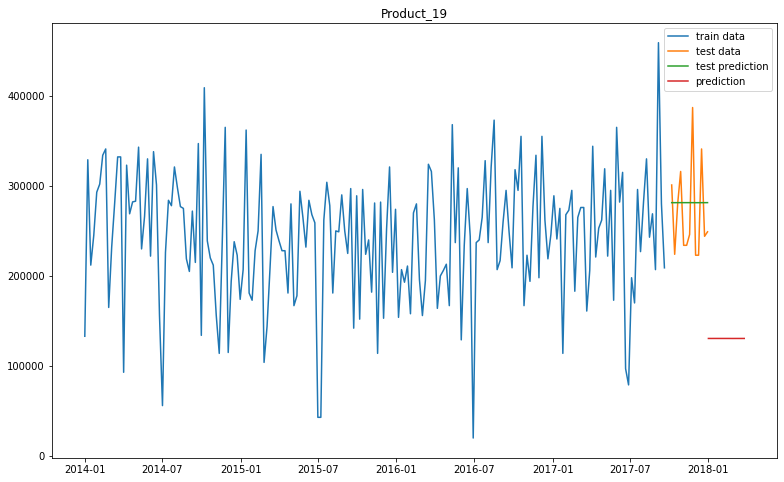

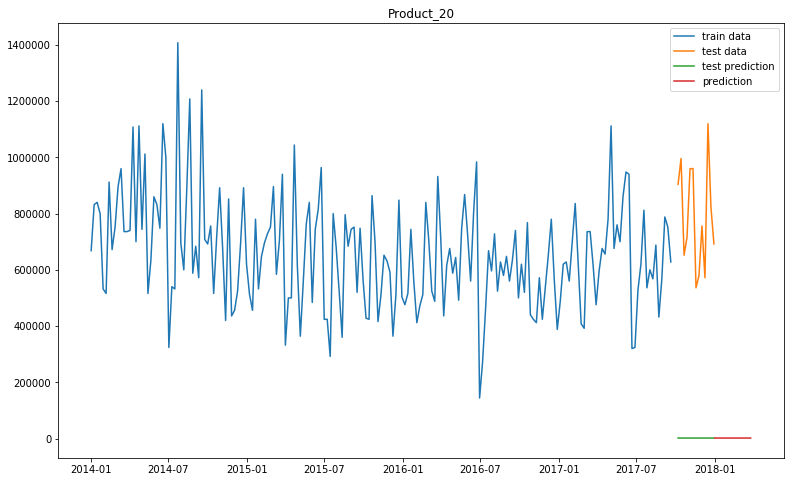

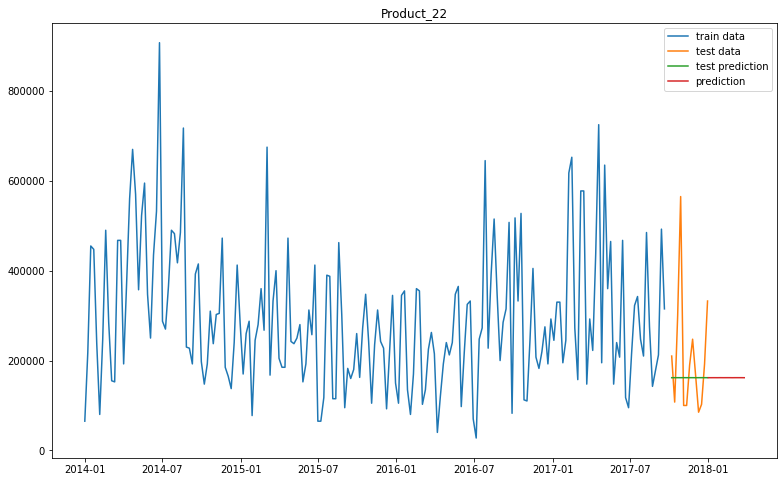

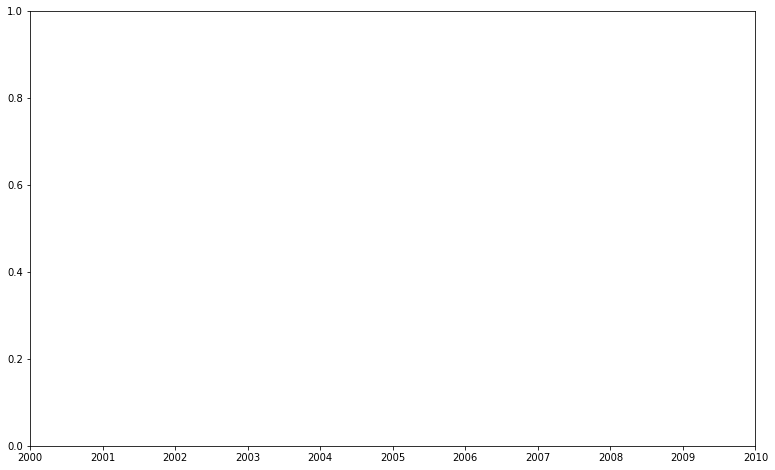

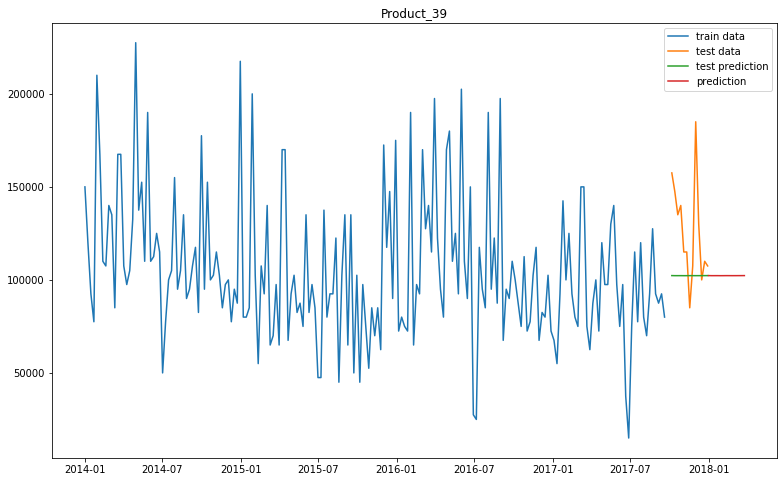

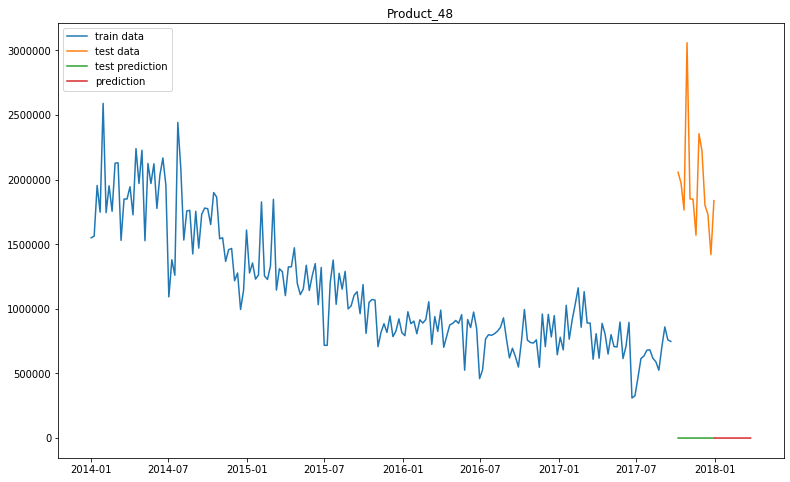

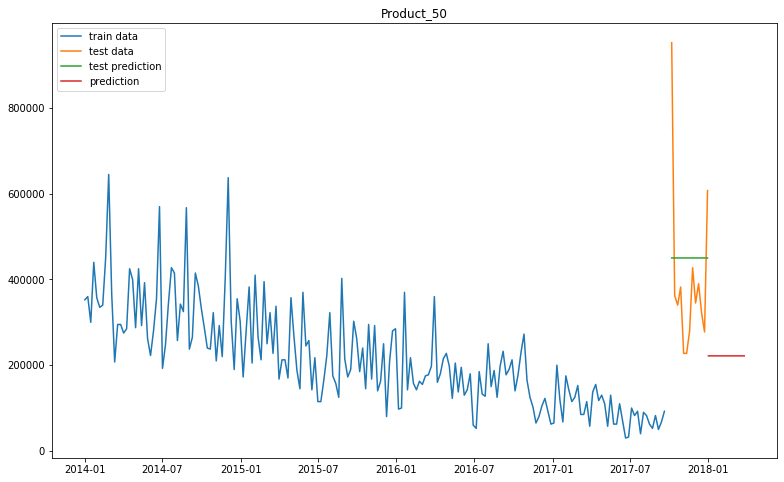

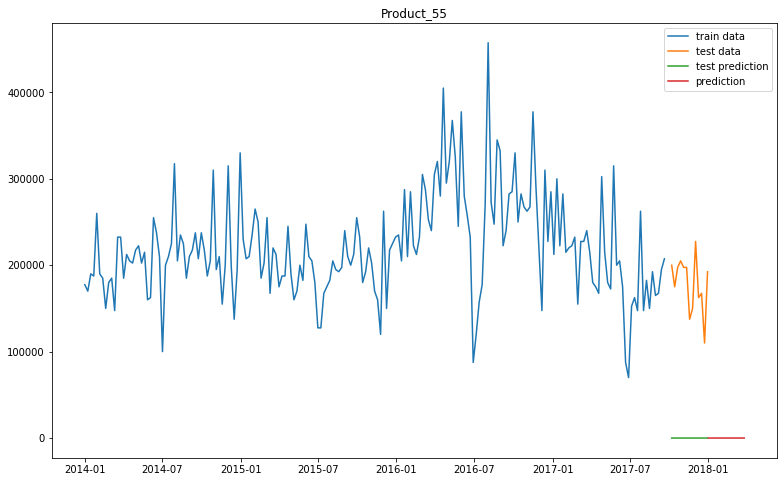

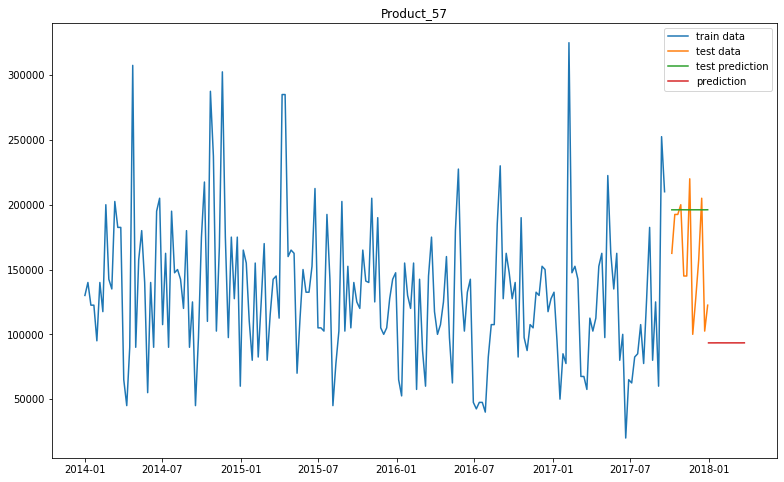

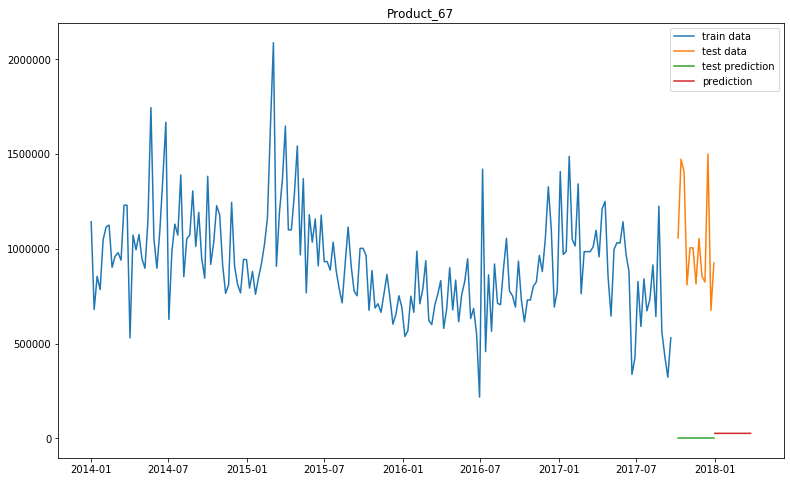

In [54]:
trainer = Trainer(name='mean_norm_retrain', norm=True, retrain=True)
trainer(trains_loaders, tests_loaders, trains, tests, predictions, 0.01, 15)

- check stats stats_mean_NOnorm_retrain.json
- check why looks so shitty Product_39, Product_48, Product_50, Product_55, Product_67 